In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# batch size
batch_size = 5
# input vector size
hidden_size = 300
# unroll rnn with truncated bp,
# with a fixed number of number(num_step) cells
num_steps = 53
# forget bias
forget_bias = 1.0
# keep probability
keep_prob = 0.5
# num of layers in multiple layer lstm
num_layers = 2
# num of output classes 
num_classes = 6
# max epoch
max_epoch = 30

In [3]:
"""
data = np.load("../labeledEmbedding.npy")
assert data.shape[1] == hidden_size, "hidden_size shoule be equal to data.shape[0]"
label = np.genfromtxt("../EmbeddingLabel.csv", usecols=[1], delimiter=",", dtype=np.int32)
batch_len = data.shape[0] // batch_size
data = np.reshape(data[0: batch_size*batch_len], [batch_size, batch_len, -1])
label = label[0: batch_size*batch_len].reshape(batch_size, -1)
epoch_size = (batch_len - 1) // num_steps

# input data
def input_producer(data, label, epoch_size, batch_size, num_steps):
    data = tf.convert_to_tensor(data, name="data", dtype=tf.float32)
    label = tf.convert_to_tensor(label, name="label", dtype=tf.int32)
    assertion = tf.assert_positive(
        epoch_size,
        message="epoch_size == 0, decrease batch_size or num_steps")
    with tf.control_dependencies([assertion]):
        epoch_size = tf.identity(epoch_size, name="epoch_size") 
    i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()
    x = tf.strided_slice(data, [0, i * num_steps, 0], [batch_size, (i + 1) * num_steps, hidden_size])
    x.set_shape([batch_size, num_steps, hidden_size])
    y = tf.strided_slice(label, [0, i * num_steps], [batch_size, (i + 1) * num_steps])
    y.set_shape([batch_size, num_steps])
    return x, y  

inputs, labels = input_producer(data, label, epoch_size, batch_size, num_steps)
inputs = tf.unstack(inputs, num=num_steps, axis=1)
"""

'\ndata = np.load("../labeledEmbedding.npy")\nassert data.shape[1] == hidden_size, "hidden_size shoule be equal to data.shape[0]"\nlabel = np.genfromtxt("../EmbeddingLabel.csv", usecols=[1], delimiter=",", dtype=np.int32)\nbatch_len = data.shape[0] // batch_size\ndata = np.reshape(data[0: batch_size*batch_len], [batch_size, batch_len, -1])\nlabel = label[0: batch_size*batch_len].reshape(batch_size, -1)\nepoch_size = (batch_len - 1) // num_steps\n\n# input data\ndef input_producer(data, label, epoch_size, batch_size, num_steps):\n    data = tf.convert_to_tensor(data, name="data", dtype=tf.float32)\n    label = tf.convert_to_tensor(label, name="label", dtype=tf.int32)\n    assertion = tf.assert_positive(\n        epoch_size,\n        message="epoch_size == 0, decrease batch_size or num_steps")\n    with tf.control_dependencies([assertion]):\n        epoch_size = tf.identity(epoch_size, name="epoch_size") \n    i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()\n    x 

In [4]:
data = np.load("../Embedding3D.npy")
sequence_length = data.any(axis=2).sum(axis=1)

l = np.genfromtxt("../EmbeddingLabel.csv", delimiter=",", usecols=[1], dtype=np.int32)
l += 1

label = np.zeros([134, 53], dtype=np.int32)

y_begin = 0
for i, m in enumerate(sequence_length):
    y_end = y_begin + m
    label[i][:m] = l[y_begin: y_end]
    y_begin = y_end

In [5]:
def input_producer(data, label, epoch_size, batch_size, num_steps):
    data = tf.convert_to_tensor(data, name="data", dtype=tf.float32)
    label = tf.convert_to_tensor(label, name="label", dtype=tf.int32)
    i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()
    x = tf.strided_slice(data, [i * batch_size, 0, 0], [(i + 1) * batch_size, num_steps, hidden_size])
    x.set_shape([batch_size, num_steps, hidden_size])
    y = tf.strided_slice(label, [i * batch_size, 0], [(i + 1) * batch_size, num_steps])
    y.set_shape([batch_size, num_steps])
    return x, y  

epoch_size = data.shape[0] // batch_size

inputs, labels = input_producer(data, label, epoch_size, batch_size, num_steps)
inputs = tf.unstack(inputs, num=num_steps, axis=1)

In [6]:
# inference
lstm_fw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_fw = tf.contrib.rnn.DropoutWrapper(lstm_fw, output_keep_prob=keep_prob)

multi_lstm_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw] * num_layers)

initial_state_fw = multi_lstm_fw.zero_state(batch_size, tf.float32)

lstm_bw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_bw = tf.contrib.rnn.DropoutWrapper(lstm_bw, output_keep_prob=keep_prob)

multi_lstm_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw] * num_layers)

initial_state_bw = multi_lstm_bw.zero_state(batch_size, tf.float32)


In [7]:
outputs, output_state_fw, output_state_bw = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=multi_lstm_fw, cell_bw=multi_lstm_bw, inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)

#outputs, output_state_fw, output_state_bw = tf.nn.bidirectional_dynamic_rnn(
#    cell_fw=lstm_fw, cell_bw=lstm_bw, sequence_length=[2, 3, 3,3, 5],
#    inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)

#outputs

In [8]:
softmax_w = tf.get_variable("softmax_w", [2*hidden_size, num_classes], dtype=tf.float32)
softmax_b = tf.get_variable("softmax_b", [num_classes], dtype=tf.float32)

output = tf.reshape(tf.concat(outputs, 1), [-1, 2 * hidden_size])
logits = tf.matmul(output, softmax_w) + softmax_b
label_flat = tf.reshape(labels, [-1])

weights = tf.to_float(tf.clip_by_value(label_flat, clip_value_min=0, clip_value_max=2))
weights = tf.square(weights)

mask = tf.sign(weights)

loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    logits=[logits],
    targets=[label_flat],
    weights=[mask])

cost = tf.reduce_sum(loss) / batch_size

optimizer = tf.train.GradientDescentOptimizer(0.1)
train_op = optimizer.minimize(cost)

In [9]:
prediction = tf.argmax(logits, 1) * tf.to_int64(mask)

In [10]:
def run_epoch(sess):
    sess.run(initial_state_fw)

    start_time = time.time()
    costs = 0.0
    iters = 0.0
    
    state_fw = sess.run(initial_state_fw)
    state_bw = sess.run(initial_state_bw)
    
    preds = []
    
    for step in range(epoch_size):
        feed_dict = {}
        for i, (c, h) in enumerate(initial_state_fw):
            feed_dict[c] = state_fw[i].c
            feed_dict[h] = state_fw[i].h
        for i, (c, h) in enumerate(initial_state_bw):
            feed_dict[c] = state_bw[i].c
            feed_dict[h] = state_bw[i].h
            
        c, state_fw, state_bw, _, pred = sess.run(
            [cost, output_state_fw, output_state_bw, train_op, prediction],
            feed_dict)
    
        costs += c
        iters += num_steps
    
        preds.append(pred)
    
        if step % (epoch_size // 10) == 0:
            print("%.3f perplexity: %.3f speed: %.0f wps" %
                (step * 1.0 / epoch_size, np.exp(costs / iters),
                 iters * batch_size / (time.time() - start_time)))

    return preds

epoch:    0
0.000 perplexity: 1.184 speed: 63 wps
0.077 perplexity: 1.207 speed: 132 wps
0.154 perplexity: 1.202 speed: 169 wps
0.231 perplexity: 1.192 speed: 192 wps
0.308 perplexity: 1.199 speed: 209 wps
0.385 perplexity: 1.197 speed: 220 wps
0.462 perplexity: 1.199 speed: 229 wps
0.538 perplexity: 1.188 speed: 236 wps
0.615 perplexity: 1.179 speed: 242 wps
0.692 perplexity: 1.184 speed: 246 wps
0.769 perplexity: 1.190 speed: 250 wps
0.846 perplexity: 1.193 speed: 253 wps
0.923 perplexity: 1.190 speed: 256 wps


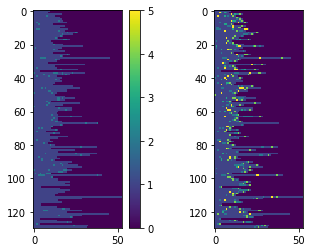

epoch:    1
0.000 perplexity: 1.168 speed: 182 wps
0.077 perplexity: 1.199 speed: 198 wps
0.154 perplexity: 1.200 speed: 223 wps
0.231 perplexity: 1.196 speed: 239 wps
0.308 perplexity: 1.199 speed: 249 wps
0.385 perplexity: 1.200 speed: 257 wps
0.462 perplexity: 1.202 speed: 262 wps
0.538 perplexity: 1.191 speed: 265 wps
0.615 perplexity: 1.182 speed: 269 wps
0.692 perplexity: 1.184 speed: 271 wps
0.769 perplexity: 1.181 speed: 273 wps
0.846 perplexity: 1.181 speed: 275 wps
0.923 perplexity: 1.178 speed: 276 wps


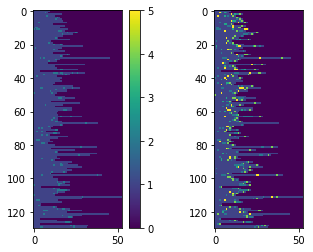

epoch:    2
0.000 perplexity: 1.180 speed: 285 wps
0.077 perplexity: 1.197 speed: 292 wps
0.154 perplexity: 1.199 speed: 293 wps
0.231 perplexity: 1.194 speed: 295 wps
0.308 perplexity: 1.207 speed: 295 wps
0.385 perplexity: 1.206 speed: 295 wps
0.462 perplexity: 1.206 speed: 295 wps
0.538 perplexity: 1.194 speed: 295 wps
0.615 perplexity: 1.184 speed: 295 wps
0.692 perplexity: 1.188 speed: 295 wps
0.769 perplexity: 1.184 speed: 295 wps
0.846 perplexity: 1.185 speed: 295 wps
0.923 perplexity: 1.182 speed: 295 wps


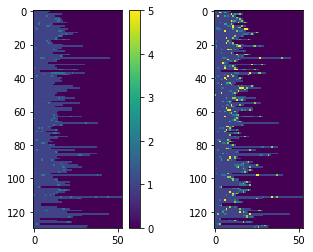

epoch:    3
0.000 perplexity: 1.176 speed: 274 wps
0.077 perplexity: 1.204 speed: 289 wps
0.154 perplexity: 1.199 speed: 291 wps
0.231 perplexity: 1.191 speed: 293 wps
0.308 perplexity: 1.194 speed: 293 wps
0.385 perplexity: 1.200 speed: 293 wps
0.462 perplexity: 1.201 speed: 294 wps
0.538 perplexity: 1.189 speed: 294 wps
0.615 perplexity: 1.179 speed: 294 wps
0.692 perplexity: 1.187 speed: 292 wps
0.769 perplexity: 1.185 speed: 292 wps
0.846 perplexity: 1.184 speed: 292 wps
0.923 perplexity: 1.184 speed: 292 wps


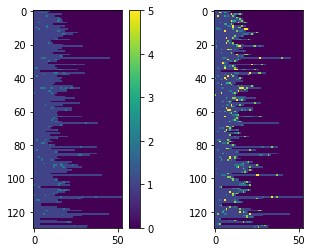

epoch:    4
0.000 perplexity: 1.172 speed: 279 wps
0.077 perplexity: 1.201 speed: 291 wps
0.154 perplexity: 1.194 speed: 293 wps
0.231 perplexity: 1.182 speed: 294 wps
0.308 perplexity: 1.181 speed: 294 wps
0.385 perplexity: 1.192 speed: 294 wps
0.462 perplexity: 1.196 speed: 294 wps
0.538 perplexity: 1.183 speed: 294 wps
0.615 perplexity: 1.175 speed: 294 wps
0.692 perplexity: 1.180 speed: 295 wps
0.769 perplexity: 1.177 speed: 295 wps
0.846 perplexity: 1.178 speed: 295 wps
0.923 perplexity: 1.177 speed: 295 wps


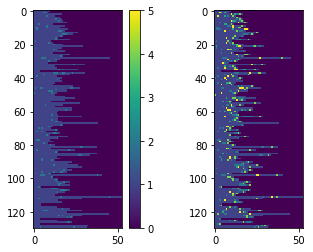

epoch:    5
0.000 perplexity: 1.184 speed: 293 wps
0.077 perplexity: 1.190 speed: 295 wps
0.154 perplexity: 1.189 speed: 298 wps
0.231 perplexity: 1.183 speed: 297 wps
0.308 perplexity: 1.181 speed: 296 wps
0.385 perplexity: 1.179 speed: 296 wps
0.462 perplexity: 1.187 speed: 297 wps
0.538 perplexity: 1.178 speed: 297 wps
0.615 perplexity: 1.169 speed: 297 wps
0.692 perplexity: 1.175 speed: 297 wps
0.769 perplexity: 1.172 speed: 297 wps
0.846 perplexity: 1.171 speed: 297 wps
0.923 perplexity: 1.168 speed: 297 wps


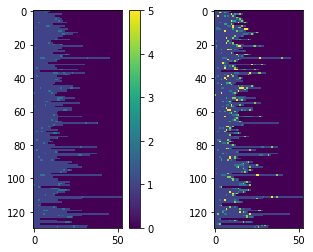

epoch:    6
0.000 perplexity: 1.170 speed: 290 wps
0.077 perplexity: 1.191 speed: 295 wps
0.154 perplexity: 1.187 speed: 298 wps
0.231 perplexity: 1.176 speed: 298 wps
0.308 perplexity: 1.176 speed: 297 wps
0.385 perplexity: 1.182 speed: 297 wps
0.462 perplexity: 1.190 speed: 297 wps
0.538 perplexity: 1.181 speed: 298 wps
0.615 perplexity: 1.171 speed: 298 wps
0.692 perplexity: 1.175 speed: 298 wps
0.769 perplexity: 1.171 speed: 298 wps
0.846 perplexity: 1.171 speed: 298 wps
0.923 perplexity: 1.169 speed: 298 wps


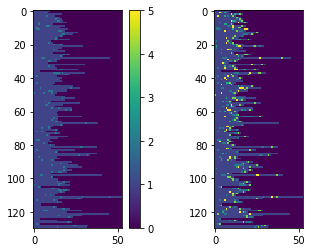

epoch:    7
0.000 perplexity: 1.193 speed: 291 wps
0.077 perplexity: 1.201 speed: 296 wps
0.154 perplexity: 1.195 speed: 298 wps
0.231 perplexity: 1.182 speed: 298 wps
0.308 perplexity: 1.188 speed: 298 wps
0.385 perplexity: 1.185 speed: 298 wps
0.462 perplexity: 1.190 speed: 298 wps
0.538 perplexity: 1.179 speed: 299 wps
0.615 perplexity: 1.171 speed: 299 wps
0.692 perplexity: 1.177 speed: 298 wps
0.769 perplexity: 1.174 speed: 298 wps
0.846 perplexity: 1.172 speed: 298 wps
0.923 perplexity: 1.171 speed: 298 wps


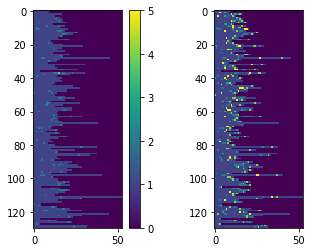

epoch:    8
0.000 perplexity: 1.164 speed: 294 wps
0.077 perplexity: 1.185 speed: 297 wps
0.154 perplexity: 1.187 speed: 296 wps
0.231 perplexity: 1.179 speed: 297 wps
0.308 perplexity: 1.179 speed: 297 wps
0.385 perplexity: 1.179 speed: 297 wps
0.462 perplexity: 1.180 speed: 296 wps
0.538 perplexity: 1.169 speed: 296 wps
0.615 perplexity: 1.162 speed: 297 wps
0.692 perplexity: 1.167 speed: 297 wps
0.769 perplexity: 1.167 speed: 297 wps
0.846 perplexity: 1.166 speed: 296 wps
0.923 perplexity: 1.164 speed: 296 wps


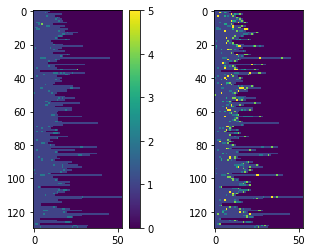

epoch:    9
0.000 perplexity: 1.160 speed: 291 wps
0.077 perplexity: 1.183 speed: 296 wps
0.154 perplexity: 1.184 speed: 298 wps
0.231 perplexity: 1.174 speed: 298 wps
0.308 perplexity: 1.176 speed: 298 wps
0.385 perplexity: 1.177 speed: 298 wps
0.462 perplexity: 1.178 speed: 298 wps
0.538 perplexity: 1.169 speed: 298 wps
0.615 perplexity: 1.162 speed: 298 wps
0.692 perplexity: 1.165 speed: 298 wps
0.769 perplexity: 1.161 speed: 298 wps
0.846 perplexity: 1.161 speed: 298 wps
0.923 perplexity: 1.159 speed: 297 wps


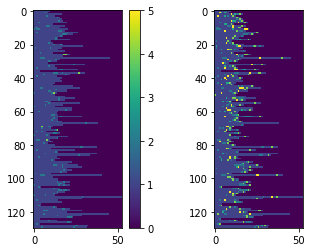

epoch:   10
0.000 perplexity: 1.159 speed: 295 wps
0.077 perplexity: 1.192 speed: 297 wps
0.154 perplexity: 1.184 speed: 297 wps
0.231 perplexity: 1.172 speed: 297 wps
0.308 perplexity: 1.168 speed: 296 wps
0.385 perplexity: 1.171 speed: 296 wps
0.462 perplexity: 1.174 speed: 297 wps
0.538 perplexity: 1.165 speed: 297 wps
0.615 perplexity: 1.156 speed: 297 wps
0.692 perplexity: 1.159 speed: 297 wps
0.769 perplexity: 1.157 speed: 297 wps
0.846 perplexity: 1.156 speed: 297 wps
0.923 perplexity: 1.155 speed: 297 wps


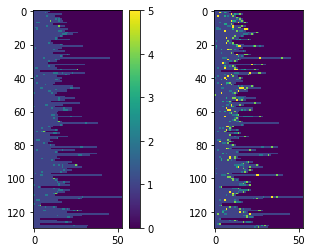

epoch:   11
0.000 perplexity: 1.175 speed: 289 wps
0.077 perplexity: 1.183 speed: 295 wps
0.154 perplexity: 1.177 speed: 297 wps
0.231 perplexity: 1.164 speed: 297 wps
0.308 perplexity: 1.163 speed: 297 wps
0.385 perplexity: 1.164 speed: 297 wps
0.462 perplexity: 1.166 speed: 297 wps
0.538 perplexity: 1.157 speed: 297 wps
0.615 perplexity: 1.151 speed: 298 wps
0.692 perplexity: 1.155 speed: 298 wps
0.769 perplexity: 1.153 speed: 298 wps
0.846 perplexity: 1.153 speed: 298 wps
0.923 perplexity: 1.150 speed: 298 wps


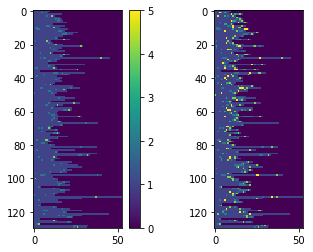

epoch:   12
0.000 perplexity: 1.153 speed: 297 wps
0.077 perplexity: 1.178 speed: 299 wps
0.154 perplexity: 1.179 speed: 298 wps
0.231 perplexity: 1.167 speed: 298 wps
0.308 perplexity: 1.166 speed: 298 wps
0.385 perplexity: 1.167 speed: 299 wps
0.462 perplexity: 1.171 speed: 299 wps
0.538 perplexity: 1.165 speed: 298 wps
0.615 perplexity: 1.157 speed: 298 wps
0.692 perplexity: 1.162 speed: 298 wps
0.769 perplexity: 1.158 speed: 298 wps
0.846 perplexity: 1.154 speed: 298 wps
0.923 perplexity: 1.154 speed: 298 wps


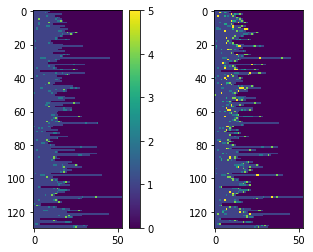

epoch:   13
0.000 perplexity: 1.157 speed: 291 wps
0.077 perplexity: 1.167 speed: 294 wps
0.154 perplexity: 1.176 speed: 296 wps
0.231 perplexity: 1.164 speed: 296 wps
0.308 perplexity: 1.160 speed: 296 wps
0.385 perplexity: 1.161 speed: 296 wps
0.462 perplexity: 1.167 speed: 296 wps
0.538 perplexity: 1.159 speed: 296 wps
0.615 perplexity: 1.151 speed: 296 wps
0.692 perplexity: 1.153 speed: 297 wps
0.769 perplexity: 1.150 speed: 297 wps
0.846 perplexity: 1.149 speed: 297 wps
0.923 perplexity: 1.150 speed: 285 wps


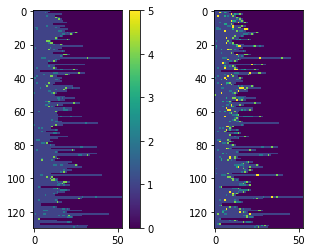

epoch:   14
0.000 perplexity: 1.146 speed: 187 wps
0.077 perplexity: 1.166 speed: 186 wps
0.154 perplexity: 1.179 speed: 198 wps
0.231 perplexity: 1.170 speed: 216 wps
0.308 perplexity: 1.167 speed: 226 wps
0.385 perplexity: 1.164 speed: 238 wps
0.462 perplexity: 1.166 speed: 247 wps
0.538 perplexity: 1.155 speed: 254 wps
0.615 perplexity: 1.147 speed: 259 wps
0.692 perplexity: 1.152 speed: 264 wps
0.769 perplexity: 1.150 speed: 268 wps
0.846 perplexity: 1.150 speed: 271 wps
0.923 perplexity: 1.152 speed: 274 wps


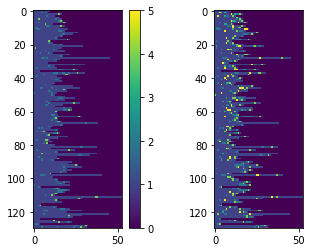

epoch:   15
0.000 perplexity: 1.191 speed: 302 wps
0.077 perplexity: 1.179 speed: 307 wps
0.154 perplexity: 1.175 speed: 309 wps
0.231 perplexity: 1.164 speed: 310 wps
0.308 perplexity: 1.164 speed: 310 wps
0.385 perplexity: 1.164 speed: 310 wps
0.462 perplexity: 1.165 speed: 307 wps
0.538 perplexity: 1.157 speed: 306 wps
0.615 perplexity: 1.150 speed: 305 wps
0.692 perplexity: 1.155 speed: 304 wps
0.769 perplexity: 1.153 speed: 303 wps
0.846 perplexity: 1.153 speed: 297 wps
0.923 perplexity: 1.150 speed: 294 wps


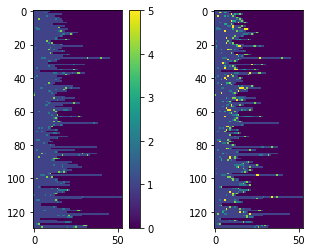

epoch:   16
0.000 perplexity: 1.161 speed: 290 wps
0.077 perplexity: 1.173 speed: 294 wps
0.154 perplexity: 1.175 speed: 294 wps
0.231 perplexity: 1.163 speed: 296 wps
0.308 perplexity: 1.163 speed: 295 wps
0.385 perplexity: 1.161 speed: 296 wps
0.462 perplexity: 1.160 speed: 296 wps
0.538 perplexity: 1.151 speed: 296 wps
0.615 perplexity: 1.145 speed: 296 wps
0.692 perplexity: 1.151 speed: 296 wps
0.769 perplexity: 1.149 speed: 296 wps
0.846 perplexity: 1.147 speed: 297 wps
0.923 perplexity: 1.148 speed: 297 wps


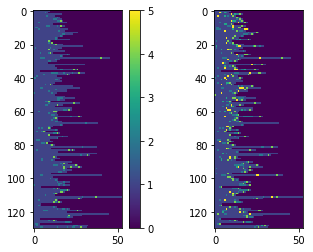

epoch:   17
0.000 perplexity: 1.209 speed: 294 wps
0.077 perplexity: 1.203 speed: 297 wps
0.154 perplexity: 1.191 speed: 297 wps
0.231 perplexity: 1.171 speed: 298 wps
0.308 perplexity: 1.165 speed: 297 wps
0.385 perplexity: 1.166 speed: 298 wps
0.462 perplexity: 1.168 speed: 298 wps
0.538 perplexity: 1.159 speed: 298 wps
0.615 perplexity: 1.151 speed: 298 wps
0.692 perplexity: 1.154 speed: 298 wps
0.769 perplexity: 1.151 speed: 298 wps
0.846 perplexity: 1.149 speed: 299 wps
0.923 perplexity: 1.147 speed: 298 wps


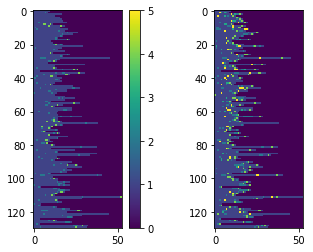

epoch:   18
0.000 perplexity: 1.144 speed: 291 wps
0.077 perplexity: 1.158 speed: 296 wps
0.154 perplexity: 1.160 speed: 297 wps
0.231 perplexity: 1.155 speed: 297 wps
0.308 perplexity: 1.158 speed: 297 wps
0.385 perplexity: 1.156 speed: 297 wps
0.462 perplexity: 1.160 speed: 298 wps
0.538 perplexity: 1.149 speed: 297 wps
0.615 perplexity: 1.142 speed: 298 wps
0.692 perplexity: 1.145 speed: 298 wps
0.769 perplexity: 1.143 speed: 298 wps
0.846 perplexity: 1.141 speed: 298 wps
0.923 perplexity: 1.140 speed: 297 wps


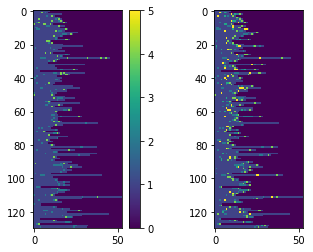

epoch:   19
0.000 perplexity: 1.144 speed: 295 wps
0.077 perplexity: 1.180 speed: 298 wps
0.154 perplexity: 1.180 speed: 298 wps
0.231 perplexity: 1.166 speed: 297 wps
0.308 perplexity: 1.160 speed: 298 wps
0.385 perplexity: 1.157 speed: 298 wps
0.462 perplexity: 1.161 speed: 298 wps
0.538 perplexity: 1.152 speed: 298 wps
0.615 perplexity: 1.144 speed: 298 wps
0.692 perplexity: 1.148 speed: 298 wps
0.769 perplexity: 1.146 speed: 298 wps
0.846 perplexity: 1.148 speed: 298 wps
0.923 perplexity: 1.145 speed: 298 wps


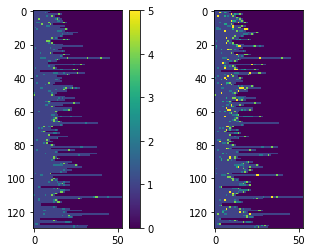

epoch:   20
0.000 perplexity: 1.122 speed: 293 wps
0.077 perplexity: 1.138 speed: 296 wps
0.154 perplexity: 1.156 speed: 297 wps
0.231 perplexity: 1.147 speed: 297 wps
0.308 perplexity: 1.149 speed: 297 wps
0.385 perplexity: 1.150 speed: 297 wps
0.462 perplexity: 1.155 speed: 298 wps
0.538 perplexity: 1.143 speed: 298 wps
0.615 perplexity: 1.137 speed: 298 wps
0.692 perplexity: 1.142 speed: 297 wps
0.769 perplexity: 1.139 speed: 297 wps
0.846 perplexity: 1.139 speed: 297 wps
0.923 perplexity: 1.137 speed: 297 wps


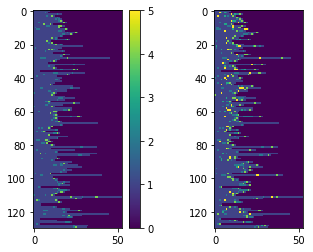

epoch:   21
0.000 perplexity: 1.147 speed: 291 wps
0.077 perplexity: 1.177 speed: 298 wps
0.154 perplexity: 1.174 speed: 299 wps
0.231 perplexity: 1.162 speed: 298 wps
0.308 perplexity: 1.157 speed: 298 wps
0.385 perplexity: 1.160 speed: 298 wps
0.462 perplexity: 1.161 speed: 299 wps
0.538 perplexity: 1.150 speed: 299 wps
0.615 perplexity: 1.142 speed: 299 wps
0.692 perplexity: 1.147 speed: 299 wps
0.769 perplexity: 1.144 speed: 299 wps
0.846 perplexity: 1.143 speed: 299 wps
0.923 perplexity: 1.141 speed: 299 wps


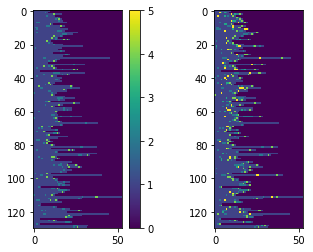

epoch:   22
0.000 perplexity: 1.173 speed: 292 wps
0.077 perplexity: 1.167 speed: 296 wps
0.154 perplexity: 1.174 speed: 297 wps
0.231 perplexity: 1.158 speed: 297 wps
0.308 perplexity: 1.156 speed: 298 wps
0.385 perplexity: 1.151 speed: 298 wps
0.462 perplexity: 1.155 speed: 298 wps
0.538 perplexity: 1.146 speed: 297 wps
0.615 perplexity: 1.138 speed: 297 wps
0.692 perplexity: 1.143 speed: 297 wps
0.769 perplexity: 1.140 speed: 298 wps
0.846 perplexity: 1.139 speed: 298 wps
0.923 perplexity: 1.140 speed: 298 wps


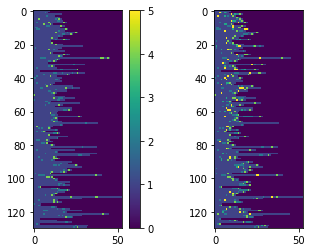

epoch:   23
0.000 perplexity: 1.143 speed: 292 wps
0.077 perplexity: 1.170 speed: 298 wps
0.154 perplexity: 1.171 speed: 265 wps
0.231 perplexity: 1.157 speed: 270 wps
0.308 perplexity: 1.154 speed: 275 wps
0.385 perplexity: 1.153 speed: 279 wps
0.462 perplexity: 1.155 speed: 282 wps
0.538 perplexity: 1.145 speed: 284 wps
0.615 perplexity: 1.139 speed: 286 wps
0.692 perplexity: 1.143 speed: 288 wps
0.769 perplexity: 1.139 speed: 289 wps
0.846 perplexity: 1.144 speed: 290 wps
0.923 perplexity: 1.142 speed: 290 wps


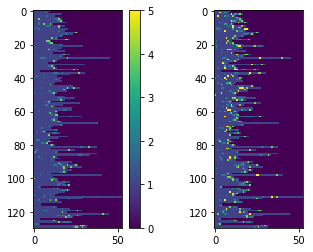

epoch:   24
0.000 perplexity: 1.252 speed: 300 wps
0.077 perplexity: 1.211 speed: 294 wps
0.154 perplexity: 1.193 speed: 295 wps
0.231 perplexity: 1.177 speed: 296 wps
0.308 perplexity: 1.171 speed: 297 wps
0.385 perplexity: 1.172 speed: 296 wps
0.462 perplexity: 1.172 speed: 296 wps
0.538 perplexity: 1.161 speed: 296 wps
0.615 perplexity: 1.153 speed: 297 wps
0.692 perplexity: 1.154 speed: 297 wps
0.769 perplexity: 1.149 speed: 297 wps
0.846 perplexity: 1.147 speed: 297 wps
0.923 perplexity: 1.146 speed: 297 wps


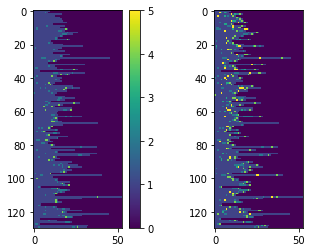

epoch:   25
0.000 perplexity: 1.136 speed: 297 wps
0.077 perplexity: 1.163 speed: 284 wps
0.154 perplexity: 1.184 speed: 220 wps
0.231 perplexity: 1.169 speed: 238 wps
0.308 perplexity: 1.167 speed: 249 wps
0.385 perplexity: 1.168 speed: 256 wps
0.462 perplexity: 1.169 speed: 262 wps
0.538 perplexity: 1.159 speed: 266 wps
0.615 perplexity: 1.153 speed: 269 wps
0.692 perplexity: 1.155 speed: 272 wps
0.769 perplexity: 1.149 speed: 274 wps
0.846 perplexity: 1.146 speed: 276 wps
0.923 perplexity: 1.147 speed: 277 wps


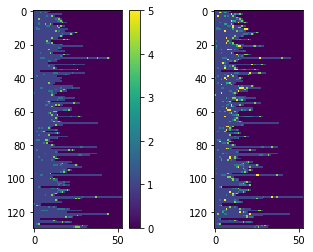

epoch:   26
0.000 perplexity: 1.137 speed: 290 wps
0.077 perplexity: 1.153 speed: 295 wps
0.154 perplexity: 1.160 speed: 296 wps
0.231 perplexity: 1.150 speed: 296 wps
0.308 perplexity: 1.147 speed: 297 wps
0.385 perplexity: 1.147 speed: 298 wps
0.462 perplexity: 1.148 speed: 298 wps
0.538 perplexity: 1.142 speed: 298 wps
0.615 perplexity: 1.136 speed: 299 wps
0.692 perplexity: 1.145 speed: 299 wps
0.769 perplexity: 1.148 speed: 299 wps
0.846 perplexity: 1.150 speed: 299 wps
0.923 perplexity: 1.148 speed: 299 wps


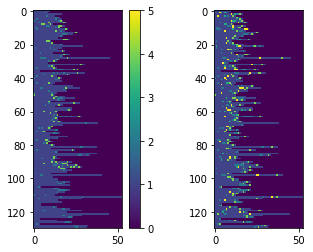

epoch:   27
0.000 perplexity: 1.142 speed: 288 wps
0.077 perplexity: 1.205 speed: 296 wps
0.154 perplexity: 1.187 speed: 296 wps
0.231 perplexity: 1.174 speed: 297 wps
0.308 perplexity: 1.171 speed: 296 wps
0.385 perplexity: 1.164 speed: 297 wps
0.462 perplexity: 1.165 speed: 297 wps
0.538 perplexity: 1.153 speed: 297 wps
0.615 perplexity: 1.145 speed: 297 wps
0.692 perplexity: 1.148 speed: 297 wps
0.769 perplexity: 1.147 speed: 298 wps
0.846 perplexity: 1.145 speed: 298 wps
0.923 perplexity: 1.143 speed: 298 wps


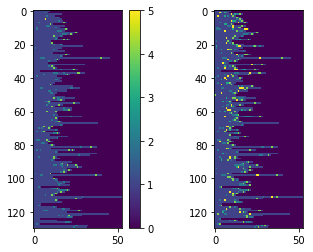

epoch:   28
0.000 perplexity: 1.134 speed: 289 wps
0.077 perplexity: 1.167 speed: 294 wps
0.154 perplexity: 1.164 speed: 295 wps
0.231 perplexity: 1.149 speed: 296 wps
0.308 perplexity: 1.146 speed: 297 wps
0.385 perplexity: 1.149 speed: 297 wps
0.462 perplexity: 1.149 speed: 297 wps
0.538 perplexity: 1.140 speed: 296 wps
0.615 perplexity: 1.132 speed: 287 wps
0.692 perplexity: 1.135 speed: 273 wps
0.769 perplexity: 1.133 speed: 262 wps
0.846 perplexity: 1.133 speed: 253 wps
0.923 perplexity: 1.132 speed: 253 wps


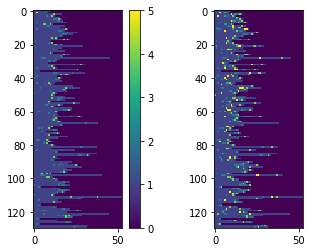

epoch:   29
0.000 perplexity: 1.117 speed: 251 wps
0.077 perplexity: 1.140 speed: 288 wps
0.154 perplexity: 1.152 speed: 297 wps
0.231 perplexity: 1.145 speed: 300 wps
0.308 perplexity: 1.145 speed: 304 wps
0.385 perplexity: 1.145 speed: 304 wps
0.462 perplexity: 1.146 speed: 305 wps
0.538 perplexity: 1.138 speed: 306 wps
0.615 perplexity: 1.133 speed: 307 wps
0.692 perplexity: 1.139 speed: 307 wps
0.769 perplexity: 1.135 speed: 307 wps
0.846 perplexity: 1.135 speed: 307 wps
0.923 perplexity: 1.136 speed: 308 wps


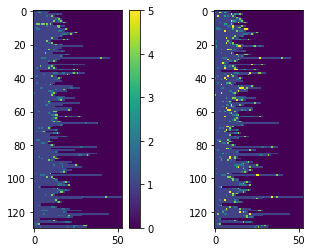

epoch:   30
0.000 perplexity: 1.177 speed: 306 wps
0.077 perplexity: 1.172 speed: 310 wps
0.154 perplexity: 1.169 speed: 311 wps
0.231 perplexity: 1.152 speed: 311 wps
0.308 perplexity: 1.150 speed: 311 wps
0.385 perplexity: 1.146 speed: 311 wps
0.462 perplexity: 1.150 speed: 311 wps
0.538 perplexity: 1.141 speed: 311 wps
0.615 perplexity: 1.134 speed: 311 wps
0.692 perplexity: 1.136 speed: 311 wps
0.769 perplexity: 1.133 speed: 311 wps
0.846 perplexity: 1.130 speed: 311 wps
0.923 perplexity: 1.129 speed: 311 wps


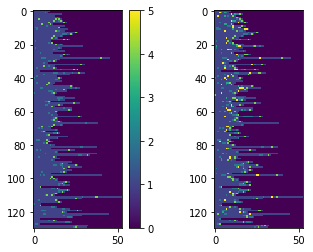

epoch:   31
0.000 perplexity: 1.131 speed: 307 wps
0.077 perplexity: 1.143 speed: 309 wps
0.154 perplexity: 1.147 speed: 308 wps
0.231 perplexity: 1.139 speed: 308 wps
0.308 perplexity: 1.137 speed: 309 wps
0.385 perplexity: 1.138 speed: 309 wps
0.462 perplexity: 1.139 speed: 309 wps
0.538 perplexity: 1.130 speed: 309 wps
0.615 perplexity: 1.124 speed: 309 wps
0.692 perplexity: 1.130 speed: 309 wps
0.769 perplexity: 1.128 speed: 310 wps
0.846 perplexity: 1.127 speed: 310 wps
0.923 perplexity: 1.127 speed: 310 wps


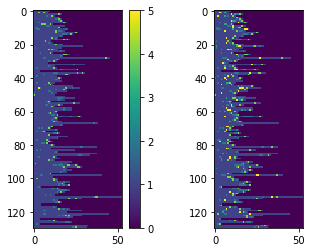

epoch:   32
0.000 perplexity: 1.105 speed: 304 wps
0.077 perplexity: 1.151 speed: 307 wps
0.154 perplexity: 1.153 speed: 309 wps
0.231 perplexity: 1.144 speed: 309 wps
0.308 perplexity: 1.141 speed: 310 wps
0.385 perplexity: 1.143 speed: 310 wps
0.462 perplexity: 1.147 speed: 310 wps
0.538 perplexity: 1.138 speed: 310 wps
0.615 perplexity: 1.132 speed: 311 wps
0.692 perplexity: 1.138 speed: 311 wps
0.769 perplexity: 1.135 speed: 310 wps
0.846 perplexity: 1.134 speed: 310 wps
0.923 perplexity: 1.132 speed: 310 wps


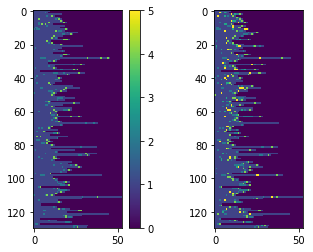

epoch:   33
0.000 perplexity: 1.117 speed: 308 wps
0.077 perplexity: 1.134 speed: 311 wps
0.154 perplexity: 1.140 speed: 309 wps
0.231 perplexity: 1.131 speed: 309 wps
0.308 perplexity: 1.131 speed: 309 wps
0.385 perplexity: 1.137 speed: 310 wps
0.462 perplexity: 1.139 speed: 311 wps
0.538 perplexity: 1.128 speed: 310 wps
0.615 perplexity: 1.123 speed: 311 wps
0.692 perplexity: 1.127 speed: 311 wps
0.769 perplexity: 1.124 speed: 311 wps
0.846 perplexity: 1.124 speed: 310 wps
0.923 perplexity: 1.124 speed: 311 wps


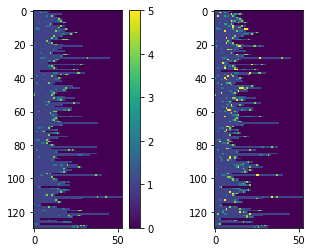

epoch:   34
0.000 perplexity: 1.144 speed: 302 wps
0.077 perplexity: 1.145 speed: 311 wps
0.154 perplexity: 1.143 speed: 301 wps
0.231 perplexity: 1.130 speed: 301 wps
0.308 perplexity: 1.130 speed: 303 wps
0.385 perplexity: 1.129 speed: 305 wps
0.462 perplexity: 1.140 speed: 306 wps
0.538 perplexity: 1.133 speed: 306 wps
0.615 perplexity: 1.128 speed: 307 wps
0.692 perplexity: 1.129 speed: 308 wps
0.769 perplexity: 1.126 speed: 308 wps
0.846 perplexity: 1.125 speed: 309 wps
0.923 perplexity: 1.123 speed: 309 wps


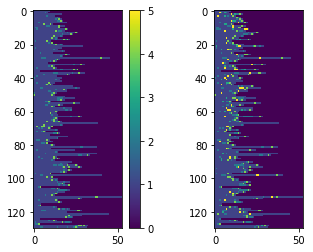

epoch:   35
0.000 perplexity: 1.207 speed: 304 wps
0.077 perplexity: 1.197 speed: 311 wps
0.154 perplexity: 1.184 speed: 311 wps
0.231 perplexity: 1.163 speed: 310 wps
0.308 perplexity: 1.156 speed: 311 wps
0.385 perplexity: 1.154 speed: 312 wps
0.462 perplexity: 1.152 speed: 311 wps
0.538 perplexity: 1.142 speed: 310 wps
0.615 perplexity: 1.133 speed: 311 wps
0.692 perplexity: 1.137 speed: 311 wps
0.769 perplexity: 1.132 speed: 311 wps
0.846 perplexity: 1.132 speed: 311 wps
0.923 perplexity: 1.130 speed: 311 wps


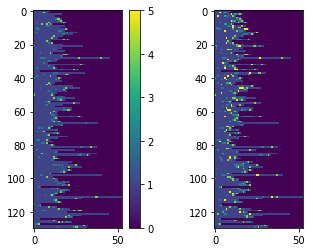

epoch:   36
0.000 perplexity: 1.137 speed: 304 wps
0.077 perplexity: 1.153 speed: 311 wps
0.154 perplexity: 1.160 speed: 311 wps
0.231 perplexity: 1.149 speed: 311 wps
0.308 perplexity: 1.146 speed: 312 wps
0.385 perplexity: 1.144 speed: 312 wps
0.462 perplexity: 1.141 speed: 312 wps
0.538 perplexity: 1.131 speed: 311 wps
0.615 perplexity: 1.124 speed: 311 wps
0.692 perplexity: 1.129 speed: 311 wps
0.769 perplexity: 1.126 speed: 311 wps
0.846 perplexity: 1.124 speed: 311 wps
0.923 perplexity: 1.123 speed: 311 wps


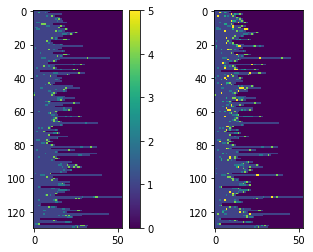

epoch:   37
0.000 perplexity: 1.107 speed: 309 wps
0.077 perplexity: 1.127 speed: 312 wps
0.154 perplexity: 1.139 speed: 312 wps
0.231 perplexity: 1.132 speed: 312 wps
0.308 perplexity: 1.134 speed: 313 wps
0.385 perplexity: 1.133 speed: 312 wps
0.462 perplexity: 1.134 speed: 311 wps
0.538 perplexity: 1.124 speed: 311 wps
0.615 perplexity: 1.120 speed: 311 wps
0.692 perplexity: 1.122 speed: 311 wps
0.769 perplexity: 1.119 speed: 311 wps
0.846 perplexity: 1.118 speed: 311 wps
0.923 perplexity: 1.117 speed: 311 wps


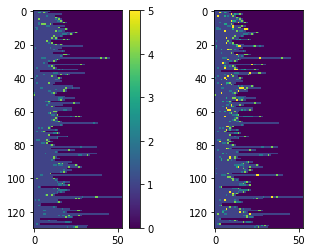

epoch:   38
0.000 perplexity: 1.099 speed: 300 wps
0.077 perplexity: 1.120 speed: 307 wps
0.154 perplexity: 1.129 speed: 308 wps
0.231 perplexity: 1.120 speed: 309 wps
0.308 perplexity: 1.118 speed: 310 wps
0.385 perplexity: 1.119 speed: 310 wps
0.462 perplexity: 1.125 speed: 310 wps
0.538 perplexity: 1.116 speed: 310 wps
0.615 perplexity: 1.110 speed: 310 wps
0.692 perplexity: 1.113 speed: 310 wps
0.769 perplexity: 1.111 speed: 310 wps
0.846 perplexity: 1.109 speed: 310 wps
0.923 perplexity: 1.109 speed: 310 wps


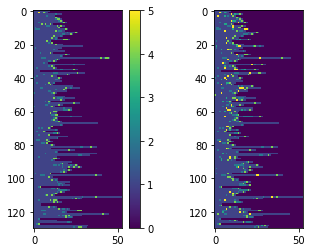

epoch:   39
0.000 perplexity: 1.123 speed: 302 wps
0.077 perplexity: 1.143 speed: 308 wps
0.154 perplexity: 1.140 speed: 309 wps
0.231 perplexity: 1.128 speed: 309 wps
0.308 perplexity: 1.125 speed: 310 wps
0.385 perplexity: 1.125 speed: 310 wps
0.462 perplexity: 1.127 speed: 306 wps
0.538 perplexity: 1.119 speed: 306 wps
0.615 perplexity: 1.119 speed: 305 wps
0.692 perplexity: 1.127 speed: 306 wps
0.769 perplexity: 1.130 speed: 307 wps
0.846 perplexity: 1.132 speed: 307 wps
0.923 perplexity: 1.132 speed: 307 wps


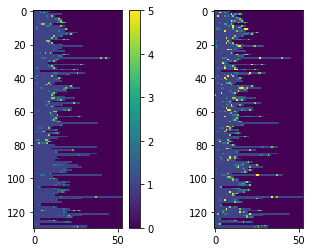

epoch:   40
0.000 perplexity: 1.148 speed: 306 wps
0.077 perplexity: 1.186 speed: 308 wps
0.154 perplexity: 1.186 speed: 310 wps
0.231 perplexity: 1.172 speed: 310 wps
0.308 perplexity: 1.168 speed: 310 wps
0.385 perplexity: 1.169 speed: 310 wps
0.462 perplexity: 1.168 speed: 310 wps
0.538 perplexity: 1.155 speed: 310 wps
0.615 perplexity: 1.148 speed: 310 wps
0.692 perplexity: 1.151 speed: 310 wps
0.769 perplexity: 1.147 speed: 310 wps
0.846 perplexity: 1.144 speed: 310 wps
0.923 perplexity: 1.143 speed: 310 wps


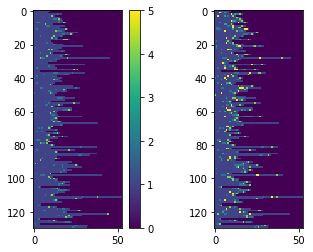

epoch:   41
0.000 perplexity: 1.130 speed: 299 wps
0.077 perplexity: 1.165 speed: 308 wps
0.154 perplexity: 1.166 speed: 310 wps
0.231 perplexity: 1.151 speed: 309 wps
0.308 perplexity: 1.153 speed: 310 wps
0.385 perplexity: 1.152 speed: 311 wps
0.462 perplexity: 1.151 speed: 311 wps
0.538 perplexity: 1.141 speed: 311 wps
0.615 perplexity: 1.134 speed: 311 wps
0.692 perplexity: 1.139 speed: 311 wps
0.769 perplexity: 1.138 speed: 311 wps
0.846 perplexity: 1.139 speed: 311 wps
0.923 perplexity: 1.138 speed: 311 wps


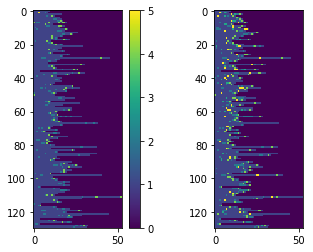

epoch:   42
0.000 perplexity: 1.163 speed: 301 wps
0.077 perplexity: 1.158 speed: 308 wps
0.154 perplexity: 1.158 speed: 308 wps
0.231 perplexity: 1.146 speed: 309 wps
0.308 perplexity: 1.143 speed: 310 wps
0.385 perplexity: 1.141 speed: 310 wps
0.462 perplexity: 1.139 speed: 310 wps
0.538 perplexity: 1.133 speed: 311 wps
0.615 perplexity: 1.127 speed: 311 wps
0.692 perplexity: 1.131 speed: 311 wps
0.769 perplexity: 1.126 speed: 311 wps
0.846 perplexity: 1.126 speed: 311 wps
0.923 perplexity: 1.125 speed: 311 wps


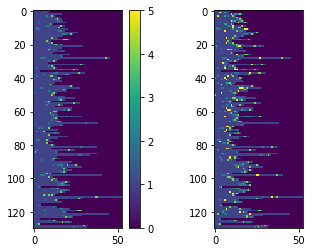

epoch:   43
0.000 perplexity: 1.119 speed: 301 wps
0.077 perplexity: 1.142 speed: 308 wps
0.154 perplexity: 1.146 speed: 309 wps
0.231 perplexity: 1.136 speed: 308 wps
0.308 perplexity: 1.135 speed: 306 wps
0.385 perplexity: 1.148 speed: 292 wps
0.462 perplexity: 1.161 speed: 288 wps
0.538 perplexity: 1.151 speed: 285 wps
0.615 perplexity: 1.142 speed: 281 wps
0.692 perplexity: 1.144 speed: 273 wps
0.769 perplexity: 1.139 speed: 269 wps
0.846 perplexity: 1.136 speed: 269 wps
0.923 perplexity: 1.135 speed: 268 wps


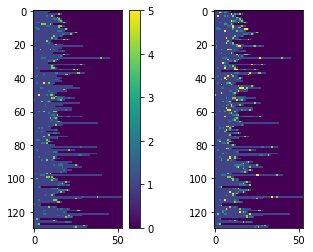

epoch:   44
0.000 perplexity: 1.110 speed: 264 wps
0.077 perplexity: 1.124 speed: 232 wps
0.154 perplexity: 1.133 speed: 243 wps
0.231 perplexity: 1.130 speed: 246 wps
0.308 perplexity: 1.142 speed: 247 wps
0.385 perplexity: 1.146 speed: 250 wps
0.462 perplexity: 1.151 speed: 256 wps
0.538 perplexity: 1.145 speed: 257 wps
0.615 perplexity: 1.139 speed: 258 wps
0.692 perplexity: 1.144 speed: 260 wps
0.769 perplexity: 1.142 speed: 263 wps
0.846 perplexity: 1.142 speed: 265 wps
0.923 perplexity: 1.143 speed: 264 wps


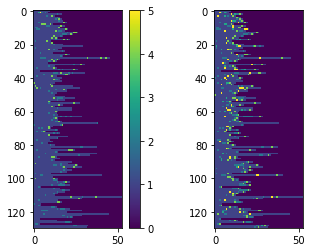

epoch:   45
0.000 perplexity: 1.134 speed: 243 wps
0.077 perplexity: 1.155 speed: 257 wps
0.154 perplexity: 1.166 speed: 245 wps
0.231 perplexity: 1.152 speed: 246 wps
0.308 perplexity: 1.149 speed: 240 wps
0.385 perplexity: 1.146 speed: 244 wps
0.462 perplexity: 1.148 speed: 246 wps
0.538 perplexity: 1.140 speed: 243 wps
0.615 perplexity: 1.132 speed: 243 wps
0.692 perplexity: 1.135 speed: 243 wps
0.769 perplexity: 1.132 speed: 244 wps
0.846 perplexity: 1.131 speed: 245 wps
0.923 perplexity: 1.129 speed: 242 wps


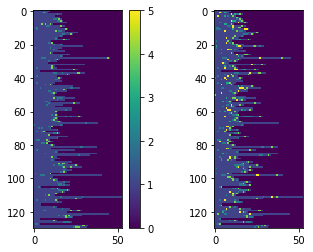

epoch:   46
0.000 perplexity: 1.122 speed: 190 wps
0.077 perplexity: 1.152 speed: 199 wps
0.154 perplexity: 1.155 speed: 207 wps
0.231 perplexity: 1.138 speed: 219 wps
0.308 perplexity: 1.137 speed: 233 wps
0.385 perplexity: 1.138 speed: 242 wps
0.462 perplexity: 1.141 speed: 250 wps
0.538 perplexity: 1.131 speed: 256 wps
0.615 perplexity: 1.125 speed: 260 wps
0.692 perplexity: 1.129 speed: 264 wps
0.769 perplexity: 1.125 speed: 267 wps
0.846 perplexity: 1.125 speed: 270 wps
0.923 perplexity: 1.123 speed: 272 wps


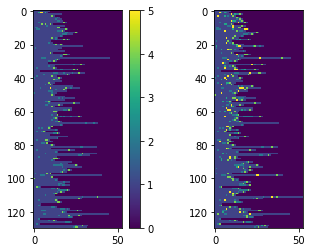

epoch:   47
0.000 perplexity: 1.139 speed: 297 wps
0.077 perplexity: 1.145 speed: 298 wps
0.154 perplexity: 1.152 speed: 300 wps
0.231 perplexity: 1.139 speed: 301 wps
0.308 perplexity: 1.140 speed: 301 wps
0.385 perplexity: 1.141 speed: 301 wps
0.462 perplexity: 1.140 speed: 301 wps
0.538 perplexity: 1.132 speed: 301 wps
0.615 perplexity: 1.127 speed: 301 wps
0.692 perplexity: 1.130 speed: 301 wps
0.769 perplexity: 1.128 speed: 301 wps
0.846 perplexity: 1.126 speed: 301 wps
0.923 perplexity: 1.124 speed: 301 wps


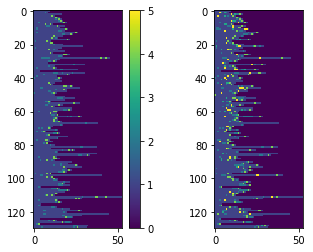

epoch:   48
0.000 perplexity: 1.129 speed: 303 wps
0.077 perplexity: 1.132 speed: 298 wps
0.154 perplexity: 1.143 speed: 300 wps
0.231 perplexity: 1.138 speed: 299 wps
0.308 perplexity: 1.137 speed: 300 wps
0.385 perplexity: 1.137 speed: 301 wps
0.462 perplexity: 1.137 speed: 301 wps
0.538 perplexity: 1.128 speed: 301 wps
0.615 perplexity: 1.121 speed: 301 wps
0.692 perplexity: 1.124 speed: 301 wps
0.769 perplexity: 1.121 speed: 301 wps
0.846 perplexity: 1.119 speed: 301 wps
0.923 perplexity: 1.119 speed: 301 wps


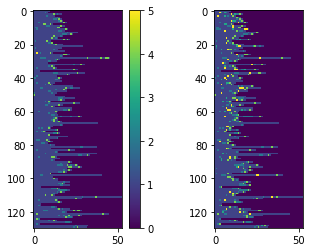

epoch:   49
0.000 perplexity: 1.114 speed: 298 wps
0.077 perplexity: 1.164 speed: 301 wps
0.154 perplexity: 1.185 speed: 300 wps
0.231 perplexity: 1.165 speed: 301 wps
0.308 perplexity: 1.158 speed: 300 wps
0.385 perplexity: 1.155 speed: 299 wps
0.462 perplexity: 1.152 speed: 299 wps
0.538 perplexity: 1.142 speed: 299 wps
0.615 perplexity: 1.136 speed: 300 wps
0.692 perplexity: 1.137 speed: 300 wps
0.769 perplexity: 1.131 speed: 300 wps
0.846 perplexity: 1.128 speed: 300 wps
0.923 perplexity: 1.125 speed: 300 wps


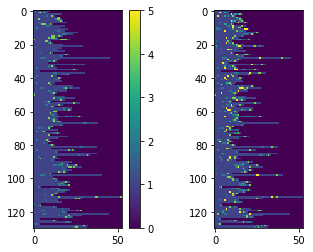

epoch:   50
0.000 perplexity: 1.112 speed: 300 wps
0.077 perplexity: 1.130 speed: 302 wps
0.154 perplexity: 1.141 speed: 301 wps
0.231 perplexity: 1.130 speed: 300 wps
0.308 perplexity: 1.131 speed: 300 wps
0.385 perplexity: 1.128 speed: 301 wps
0.462 perplexity: 1.131 speed: 293 wps
0.538 perplexity: 1.122 speed: 268 wps
0.615 perplexity: 1.117 speed: 271 wps
0.692 perplexity: 1.120 speed: 275 wps
0.769 perplexity: 1.117 speed: 277 wps
0.846 perplexity: 1.117 speed: 279 wps
0.923 perplexity: 1.116 speed: 281 wps


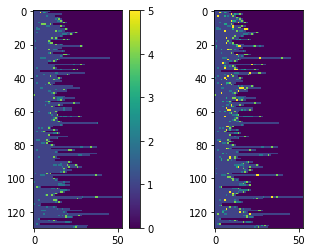

epoch:   51
0.000 perplexity: 1.122 speed: 308 wps
0.077 perplexity: 1.136 speed: 305 wps
0.154 perplexity: 1.164 speed: 304 wps
0.231 perplexity: 1.158 speed: 304 wps
0.308 perplexity: 1.153 speed: 304 wps
0.385 perplexity: 1.151 speed: 304 wps
0.462 perplexity: 1.149 speed: 304 wps
0.538 perplexity: 1.139 speed: 303 wps
0.615 perplexity: 1.131 speed: 303 wps
0.692 perplexity: 1.131 speed: 303 wps
0.769 perplexity: 1.126 speed: 303 wps
0.846 perplexity: 1.123 speed: 303 wps
0.923 perplexity: 1.120 speed: 303 wps


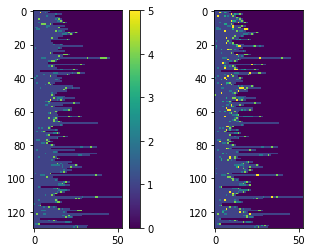

epoch:   52
0.000 perplexity: 1.095 speed: 299 wps
0.077 perplexity: 1.115 speed: 301 wps
0.154 perplexity: 1.131 speed: 301 wps
0.231 perplexity: 1.131 speed: 301 wps
0.308 perplexity: 1.135 speed: 301 wps
0.385 perplexity: 1.134 speed: 291 wps
0.462 perplexity: 1.132 speed: 272 wps
0.538 perplexity: 1.124 speed: 264 wps
0.615 perplexity: 1.117 speed: 263 wps
0.692 perplexity: 1.119 speed: 258 wps
0.769 perplexity: 1.114 speed: 250 wps
0.846 perplexity: 1.112 speed: 243 wps
0.923 perplexity: 1.109 speed: 245 wps


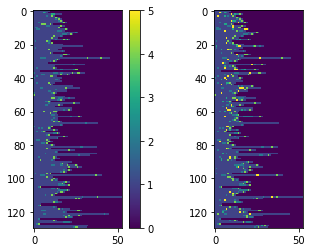

epoch:   53
0.000 perplexity: 1.125 speed: 291 wps
0.077 perplexity: 1.123 speed: 296 wps
0.154 perplexity: 1.137 speed: 298 wps
0.231 perplexity: 1.132 speed: 298 wps
0.308 perplexity: 1.131 speed: 298 wps
0.385 perplexity: 1.127 speed: 298 wps
0.462 perplexity: 1.128 speed: 297 wps
0.538 perplexity: 1.120 speed: 297 wps
0.615 perplexity: 1.114 speed: 297 wps
0.692 perplexity: 1.116 speed: 298 wps
0.769 perplexity: 1.112 speed: 298 wps
0.846 perplexity: 1.110 speed: 298 wps
0.923 perplexity: 1.109 speed: 298 wps


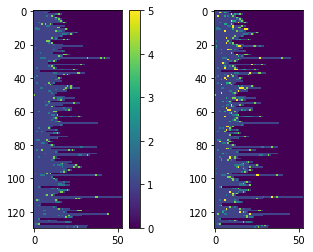

epoch:   54
0.000 perplexity: 1.153 speed: 292 wps
0.077 perplexity: 1.134 speed: 298 wps
0.154 perplexity: 1.137 speed: 295 wps
0.231 perplexity: 1.131 speed: 292 wps
0.308 perplexity: 1.131 speed: 292 wps
0.385 perplexity: 1.129 speed: 292 wps
0.462 perplexity: 1.128 speed: 293 wps
0.538 perplexity: 1.119 speed: 294 wps
0.615 perplexity: 1.113 speed: 294 wps
0.692 perplexity: 1.120 speed: 294 wps
0.769 perplexity: 1.118 speed: 295 wps
0.846 perplexity: 1.117 speed: 295 wps
0.923 perplexity: 1.116 speed: 295 wps


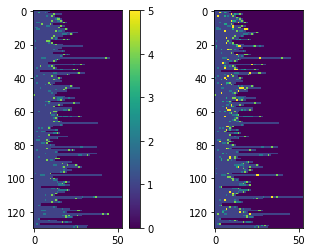

epoch:   55
0.000 perplexity: 1.119 speed: 291 wps
0.077 perplexity: 1.123 speed: 298 wps
0.154 perplexity: 1.135 speed: 298 wps
0.231 perplexity: 1.131 speed: 298 wps
0.308 perplexity: 1.127 speed: 298 wps
0.385 perplexity: 1.124 speed: 298 wps
0.462 perplexity: 1.124 speed: 297 wps
0.538 perplexity: 1.115 speed: 297 wps
0.615 perplexity: 1.108 speed: 297 wps
0.692 perplexity: 1.112 speed: 297 wps
0.769 perplexity: 1.108 speed: 297 wps
0.846 perplexity: 1.106 speed: 297 wps
0.923 perplexity: 1.103 speed: 298 wps


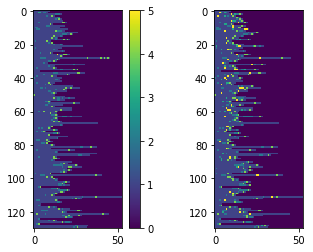

epoch:   56
0.000 perplexity: 1.089 speed: 290 wps
0.077 perplexity: 1.110 speed: 295 wps
0.154 perplexity: 1.129 speed: 296 wps
0.231 perplexity: 1.120 speed: 296 wps
0.308 perplexity: 1.119 speed: 297 wps
0.385 perplexity: 1.122 speed: 297 wps
0.462 perplexity: 1.123 speed: 298 wps
0.538 perplexity: 1.117 speed: 297 wps
0.615 perplexity: 1.111 speed: 297 wps
0.692 perplexity: 1.113 speed: 297 wps
0.769 perplexity: 1.109 speed: 298 wps
0.846 perplexity: 1.107 speed: 297 wps
0.923 perplexity: 1.104 speed: 297 wps


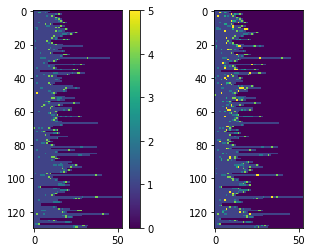

epoch:   57
0.000 perplexity: 1.137 speed: 289 wps
0.077 perplexity: 1.128 speed: 296 wps
0.154 perplexity: 1.131 speed: 296 wps
0.231 perplexity: 1.119 speed: 296 wps
0.308 perplexity: 1.118 speed: 296 wps
0.385 perplexity: 1.118 speed: 296 wps
0.462 perplexity: 1.123 speed: 297 wps
0.538 perplexity: 1.115 speed: 297 wps
0.615 perplexity: 1.110 speed: 297 wps
0.692 perplexity: 1.116 speed: 297 wps
0.769 perplexity: 1.113 speed: 297 wps
0.846 perplexity: 1.110 speed: 297 wps
0.923 perplexity: 1.107 speed: 297 wps


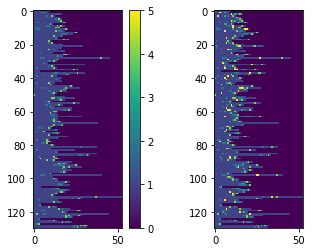

epoch:   58
0.000 perplexity: 1.131 speed: 288 wps
0.077 perplexity: 1.136 speed: 293 wps
0.154 perplexity: 1.132 speed: 295 wps
0.231 perplexity: 1.121 speed: 261 wps
0.308 perplexity: 1.117 speed: 244 wps
0.385 perplexity: 1.113 speed: 245 wps
0.462 perplexity: 1.115 speed: 247 wps
0.538 perplexity: 1.107 speed: 251 wps
0.615 perplexity: 1.102 speed: 255 wps
0.692 perplexity: 1.108 speed: 256 wps
0.769 perplexity: 1.104 speed: 258 wps
0.846 perplexity: 1.103 speed: 260 wps
0.923 perplexity: 1.102 speed: 257 wps


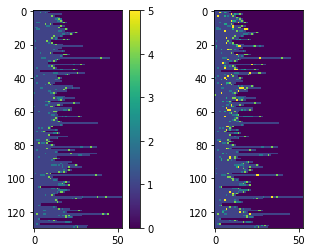

epoch:   59
0.000 perplexity: 1.104 speed: 220 wps
0.077 perplexity: 1.111 speed: 227 wps
0.154 perplexity: 1.130 speed: 248 wps
0.231 perplexity: 1.123 speed: 261 wps
0.308 perplexity: 1.118 speed: 268 wps
0.385 perplexity: 1.116 speed: 273 wps
0.462 perplexity: 1.117 speed: 276 wps
0.538 perplexity: 1.108 speed: 279 wps
0.615 perplexity: 1.103 speed: 281 wps
0.692 perplexity: 1.107 speed: 283 wps
0.769 perplexity: 1.103 speed: 284 wps
0.846 perplexity: 1.110 speed: 285 wps
0.923 perplexity: 1.111 speed: 286 wps


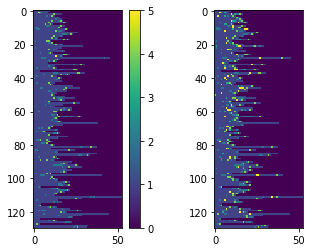

epoch:   60
0.000 perplexity: 1.111 speed: 293 wps
0.077 perplexity: 1.149 speed: 296 wps
0.154 perplexity: 1.150 speed: 297 wps
0.231 perplexity: 1.139 speed: 298 wps
0.308 perplexity: 1.135 speed: 297 wps
0.385 perplexity: 1.137 speed: 297 wps
0.462 perplexity: 1.134 speed: 297 wps
0.538 perplexity: 1.126 speed: 297 wps
0.615 perplexity: 1.119 speed: 297 wps
0.692 perplexity: 1.123 speed: 297 wps
0.769 perplexity: 1.117 speed: 298 wps
0.846 perplexity: 1.116 speed: 298 wps
0.923 perplexity: 1.113 speed: 297 wps


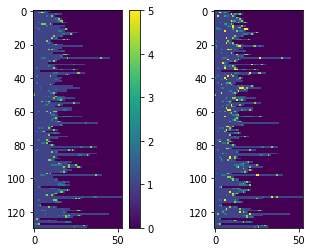

epoch:   61
0.000 perplexity: 1.116 speed: 292 wps
0.077 perplexity: 1.119 speed: 296 wps
0.154 perplexity: 1.126 speed: 295 wps
0.231 perplexity: 1.117 speed: 274 wps
0.308 perplexity: 1.116 speed: 279 wps
0.385 perplexity: 1.112 speed: 276 wps
0.462 perplexity: 1.115 speed: 268 wps
0.538 perplexity: 1.107 speed: 260 wps
0.615 perplexity: 1.104 speed: 257 wps
0.692 perplexity: 1.108 speed: 258 wps
0.769 perplexity: 1.105 speed: 260 wps
0.846 perplexity: 1.104 speed: 261 wps
0.923 perplexity: 1.106 speed: 257 wps


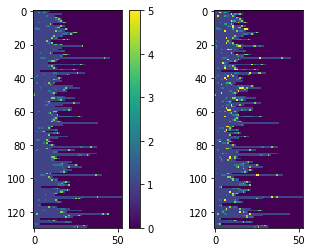

epoch:   62
0.000 perplexity: 1.100 speed: 215 wps
0.077 perplexity: 1.117 speed: 244 wps
0.154 perplexity: 1.126 speed: 232 wps
0.231 perplexity: 1.116 speed: 225 wps
0.308 perplexity: 1.115 speed: 236 wps
0.385 perplexity: 1.116 speed: 238 wps
0.462 perplexity: 1.117 speed: 245 wps
0.538 perplexity: 1.108 speed: 251 wps
0.615 perplexity: 1.103 speed: 255 wps
0.692 perplexity: 1.105 speed: 259 wps
0.769 perplexity: 1.101 speed: 262 wps
0.846 perplexity: 1.100 speed: 265 wps
0.923 perplexity: 1.100 speed: 267 wps


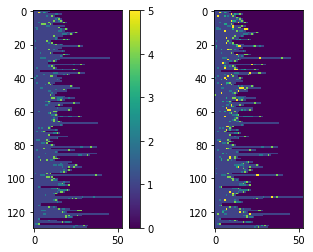

epoch:   63
0.000 perplexity: 1.102 speed: 292 wps
0.077 perplexity: 1.127 speed: 294 wps
0.154 perplexity: 1.127 speed: 296 wps
0.231 perplexity: 1.117 speed: 297 wps
0.308 perplexity: 1.113 speed: 297 wps
0.385 perplexity: 1.113 speed: 298 wps
0.462 perplexity: 1.114 speed: 297 wps
0.538 perplexity: 1.107 speed: 298 wps
0.615 perplexity: 1.103 speed: 297 wps
0.692 perplexity: 1.107 speed: 297 wps
0.769 perplexity: 1.104 speed: 297 wps
0.846 perplexity: 1.102 speed: 297 wps
0.923 perplexity: 1.099 speed: 295 wps


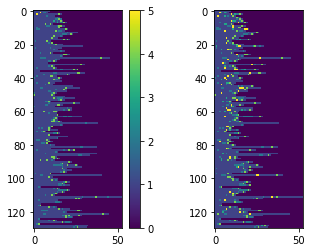

epoch:   64
0.000 perplexity: 1.100 speed: 291 wps
0.077 perplexity: 1.109 speed: 295 wps
0.154 perplexity: 1.126 speed: 296 wps
0.231 perplexity: 1.122 speed: 297 wps
0.308 perplexity: 1.124 speed: 298 wps
0.385 perplexity: 1.124 speed: 298 wps
0.462 perplexity: 1.121 speed: 297 wps
0.538 perplexity: 1.112 speed: 298 wps
0.615 perplexity: 1.106 speed: 298 wps
0.692 perplexity: 1.113 speed: 298 wps
0.769 perplexity: 1.109 speed: 298 wps
0.846 perplexity: 1.110 speed: 298 wps
0.923 perplexity: 1.110 speed: 298 wps


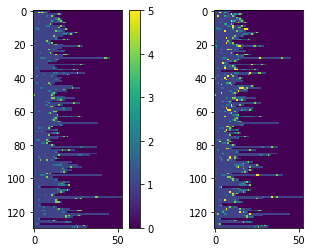

epoch:   65
0.000 perplexity: 1.086 speed: 291 wps
0.077 perplexity: 1.101 speed: 295 wps
0.154 perplexity: 1.119 speed: 293 wps
0.231 perplexity: 1.115 speed: 294 wps
0.308 perplexity: 1.115 speed: 295 wps
0.385 perplexity: 1.116 speed: 295 wps
0.462 perplexity: 1.117 speed: 296 wps
0.538 perplexity: 1.109 speed: 296 wps
0.615 perplexity: 1.104 speed: 296 wps
0.692 perplexity: 1.107 speed: 296 wps
0.769 perplexity: 1.103 speed: 296 wps
0.846 perplexity: 1.104 speed: 297 wps
0.923 perplexity: 1.102 speed: 297 wps


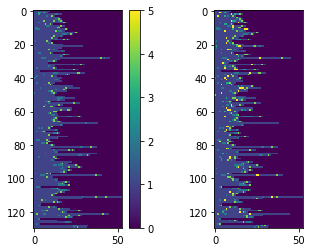

epoch:   66
0.000 perplexity: 1.104 speed: 296 wps
0.077 perplexity: 1.127 speed: 300 wps
0.154 perplexity: 1.128 speed: 300 wps
0.231 perplexity: 1.118 speed: 300 wps
0.308 perplexity: 1.115 speed: 300 wps
0.385 perplexity: 1.112 speed: 299 wps
0.462 perplexity: 1.114 speed: 298 wps
0.538 perplexity: 1.105 speed: 298 wps
0.615 perplexity: 1.102 speed: 298 wps
0.692 perplexity: 1.107 speed: 298 wps
0.769 perplexity: 1.102 speed: 297 wps
0.846 perplexity: 1.100 speed: 297 wps
0.923 perplexity: 1.100 speed: 297 wps


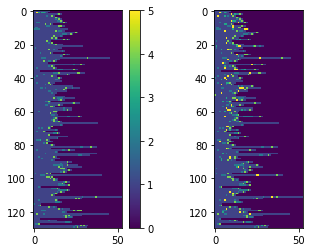

epoch:   67
0.000 perplexity: 1.094 speed: 290 wps
0.077 perplexity: 1.102 speed: 292 wps
0.154 perplexity: 1.119 speed: 294 wps
0.231 perplexity: 1.116 speed: 295 wps
0.308 perplexity: 1.119 speed: 295 wps
0.385 perplexity: 1.134 speed: 296 wps
0.462 perplexity: 1.134 speed: 296 wps
0.538 perplexity: 1.126 speed: 296 wps
0.615 perplexity: 1.119 speed: 296 wps
0.692 perplexity: 1.125 speed: 296 wps
0.769 perplexity: 1.122 speed: 297 wps
0.846 perplexity: 1.120 speed: 297 wps
0.923 perplexity: 1.120 speed: 297 wps


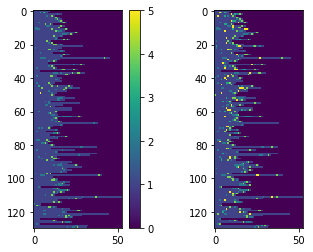

epoch:   68
0.000 perplexity: 1.115 speed: 294 wps
0.077 perplexity: 1.148 speed: 297 wps
0.154 perplexity: 1.148 speed: 297 wps
0.231 perplexity: 1.134 speed: 298 wps
0.308 perplexity: 1.134 speed: 298 wps
0.385 perplexity: 1.133 speed: 299 wps
0.462 perplexity: 1.134 speed: 298 wps
0.538 perplexity: 1.125 speed: 298 wps
0.615 perplexity: 1.119 speed: 298 wps
0.692 perplexity: 1.121 speed: 298 wps
0.769 perplexity: 1.116 speed: 298 wps
0.846 perplexity: 1.115 speed: 298 wps
0.923 perplexity: 1.113 speed: 298 wps


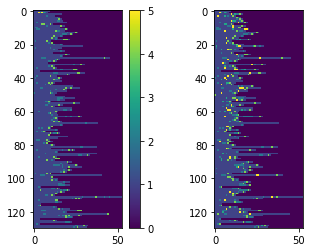

epoch:   69
0.000 perplexity: 1.109 speed: 266 wps
0.077 perplexity: 1.123 speed: 284 wps
0.154 perplexity: 1.140 speed: 290 wps
0.231 perplexity: 1.126 speed: 293 wps
0.308 perplexity: 1.123 speed: 293 wps
0.385 perplexity: 1.118 speed: 294 wps
0.462 perplexity: 1.117 speed: 295 wps
0.538 perplexity: 1.110 speed: 296 wps
0.615 perplexity: 1.104 speed: 296 wps
0.692 perplexity: 1.107 speed: 297 wps
0.769 perplexity: 1.102 speed: 297 wps
0.846 perplexity: 1.100 speed: 297 wps
0.923 perplexity: 1.098 speed: 298 wps


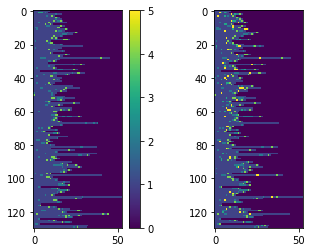

epoch:   70
0.000 perplexity: 1.101 speed: 291 wps
0.077 perplexity: 1.107 speed: 296 wps
0.154 perplexity: 1.116 speed: 297 wps
0.231 perplexity: 1.106 speed: 298 wps
0.308 perplexity: 1.110 speed: 297 wps
0.385 perplexity: 1.112 speed: 297 wps
0.462 perplexity: 1.113 speed: 297 wps
0.538 perplexity: 1.105 speed: 298 wps
0.615 perplexity: 1.098 speed: 298 wps
0.692 perplexity: 1.099 speed: 298 wps
0.769 perplexity: 1.096 speed: 298 wps
0.846 perplexity: 1.095 speed: 298 wps
0.923 perplexity: 1.093 speed: 298 wps


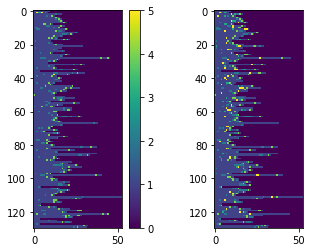

epoch:   71
0.000 perplexity: 1.085 speed: 302 wps
0.077 perplexity: 1.106 speed: 302 wps
0.154 perplexity: 1.110 speed: 300 wps
0.231 perplexity: 1.103 speed: 300 wps
0.308 perplexity: 1.102 speed: 300 wps
0.385 perplexity: 1.099 speed: 299 wps
0.462 perplexity: 1.099 speed: 299 wps
0.538 perplexity: 1.092 speed: 300 wps
0.615 perplexity: 1.089 speed: 299 wps
0.692 perplexity: 1.092 speed: 299 wps
0.769 perplexity: 1.087 speed: 299 wps
0.846 perplexity: 1.086 speed: 299 wps
0.923 perplexity: 1.086 speed: 300 wps


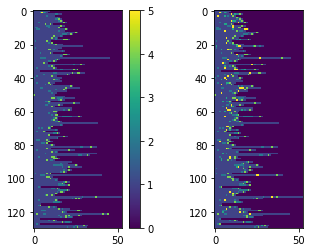

epoch:   72
0.000 perplexity: 1.090 speed: 298 wps
0.077 perplexity: 1.098 speed: 301 wps
0.154 perplexity: 1.100 speed: 302 wps
0.231 perplexity: 1.092 speed: 300 wps
0.308 perplexity: 1.091 speed: 299 wps
0.385 perplexity: 1.093 speed: 300 wps
0.462 perplexity: 1.092 speed: 300 wps
0.538 perplexity: 1.087 speed: 300 wps
0.615 perplexity: 1.085 speed: 300 wps
0.692 perplexity: 1.095 speed: 301 wps
0.769 perplexity: 1.092 speed: 301 wps
0.846 perplexity: 1.091 speed: 300 wps
0.923 perplexity: 1.090 speed: 300 wps


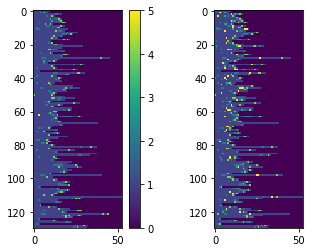

epoch:   73
0.000 perplexity: 1.099 speed: 290 wps
0.077 perplexity: 1.115 speed: 296 wps
0.154 perplexity: 1.145 speed: 297 wps
0.231 perplexity: 1.139 speed: 298 wps
0.308 perplexity: 1.139 speed: 298 wps
0.385 perplexity: 1.133 speed: 298 wps
0.462 perplexity: 1.131 speed: 298 wps
0.538 perplexity: 1.120 speed: 298 wps
0.615 perplexity: 1.113 speed: 298 wps
0.692 perplexity: 1.115 speed: 298 wps
0.769 perplexity: 1.109 speed: 298 wps
0.846 perplexity: 1.107 speed: 299 wps
0.923 perplexity: 1.105 speed: 299 wps


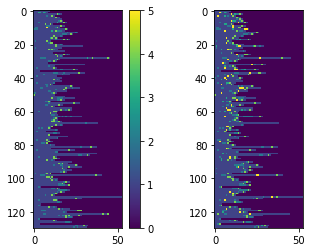

epoch:   74
0.000 perplexity: 1.084 speed: 295 wps
0.077 perplexity: 1.099 speed: 299 wps
0.154 perplexity: 1.112 speed: 288 wps
0.231 perplexity: 1.104 speed: 289 wps
0.308 perplexity: 1.103 speed: 291 wps
0.385 perplexity: 1.104 speed: 293 wps
0.462 perplexity: 1.107 speed: 294 wps
0.538 perplexity: 1.099 speed: 294 wps
0.615 perplexity: 1.094 speed: 295 wps
0.692 perplexity: 1.096 speed: 295 wps
0.769 perplexity: 1.092 speed: 295 wps
0.846 perplexity: 1.091 speed: 295 wps
0.923 perplexity: 1.089 speed: 296 wps


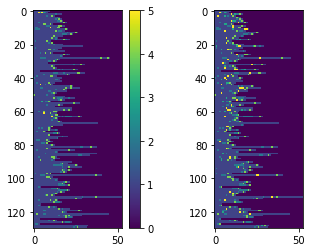

epoch:   75
0.000 perplexity: 1.113 speed: 291 wps
0.077 perplexity: 1.128 speed: 298 wps
0.154 perplexity: 1.133 speed: 282 wps
0.231 perplexity: 1.120 speed: 242 wps
0.308 perplexity: 1.115 speed: 184 wps
0.385 perplexity: 1.111 speed: 192 wps
0.462 perplexity: 1.111 speed: 200 wps
0.538 perplexity: 1.104 speed: 207 wps
0.615 perplexity: 1.099 speed: 215 wps
0.692 perplexity: 1.103 speed: 221 wps
0.769 perplexity: 1.098 speed: 227 wps
0.846 perplexity: 1.096 speed: 231 wps
0.923 perplexity: 1.095 speed: 236 wps


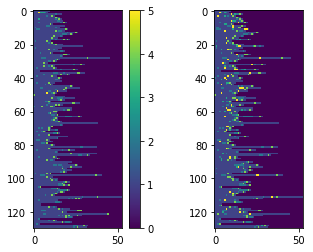

epoch:   76
0.000 perplexity: 1.088 speed: 288 wps
0.077 perplexity: 1.117 speed: 295 wps
0.154 perplexity: 1.117 speed: 297 wps
0.231 perplexity: 1.108 speed: 297 wps
0.308 perplexity: 1.107 speed: 297 wps
0.385 perplexity: 1.104 speed: 298 wps
0.462 perplexity: 1.104 speed: 298 wps
0.538 perplexity: 1.096 speed: 298 wps
0.615 perplexity: 1.092 speed: 299 wps
0.692 perplexity: 1.099 speed: 299 wps
0.769 perplexity: 1.095 speed: 298 wps
0.846 perplexity: 1.093 speed: 299 wps
0.923 perplexity: 1.091 speed: 297 wps


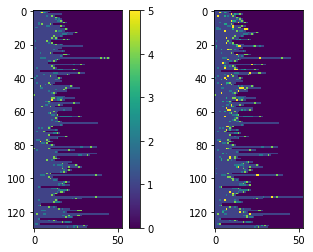

epoch:   77
0.000 perplexity: 1.125 speed: 184 wps
0.077 perplexity: 1.117 speed: 205 wps
0.154 perplexity: 1.115 speed: 207 wps
0.231 perplexity: 1.102 speed: 220 wps
0.308 perplexity: 1.098 speed: 233 wps
0.385 perplexity: 1.099 speed: 243 wps
0.462 perplexity: 1.103 speed: 250 wps
0.538 perplexity: 1.096 speed: 255 wps
0.615 perplexity: 1.095 speed: 260 wps
0.692 perplexity: 1.098 speed: 264 wps
0.769 perplexity: 1.094 speed: 267 wps
0.846 perplexity: 1.091 speed: 269 wps
0.923 perplexity: 1.091 speed: 272 wps


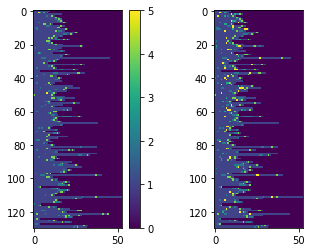

epoch:   78
0.000 perplexity: 1.072 speed: 295 wps
0.077 perplexity: 1.093 speed: 300 wps
0.154 perplexity: 1.098 speed: 300 wps
0.231 perplexity: 1.096 speed: 300 wps
0.308 perplexity: 1.099 speed: 301 wps
0.385 perplexity: 1.099 speed: 301 wps
0.462 perplexity: 1.102 speed: 301 wps
0.538 perplexity: 1.095 speed: 300 wps
0.615 perplexity: 1.091 speed: 300 wps
0.692 perplexity: 1.095 speed: 300 wps
0.769 perplexity: 1.091 speed: 300 wps
0.846 perplexity: 1.089 speed: 300 wps
0.923 perplexity: 1.087 speed: 298 wps


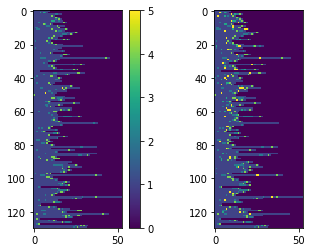

epoch:   79
0.000 perplexity: 1.099 speed: 295 wps
0.077 perplexity: 1.095 speed: 299 wps
0.154 perplexity: 1.099 speed: 299 wps
0.231 perplexity: 1.085 speed: 299 wps
0.308 perplexity: 1.087 speed: 299 wps
0.385 perplexity: 1.088 speed: 299 wps
0.462 perplexity: 1.086 speed: 300 wps
0.538 perplexity: 1.080 speed: 300 wps
0.615 perplexity: 1.078 speed: 300 wps
0.692 perplexity: 1.082 speed: 300 wps
0.769 perplexity: 1.088 speed: 300 wps
0.846 perplexity: 1.093 speed: 300 wps
0.923 perplexity: 1.093 speed: 300 wps


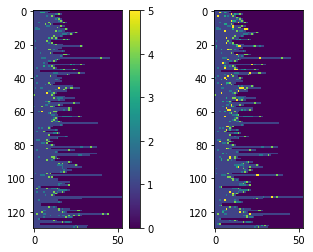

epoch:   80
0.000 perplexity: 1.090 speed: 291 wps
0.077 perplexity: 1.120 speed: 297 wps
0.154 perplexity: 1.129 speed: 295 wps
0.231 perplexity: 1.141 speed: 277 wps
0.308 perplexity: 1.138 speed: 282 wps
0.385 perplexity: 1.135 speed: 284 wps
0.462 perplexity: 1.131 speed: 278 wps
0.538 perplexity: 1.122 speed: 280 wps
0.615 perplexity: 1.114 speed: 271 wps
0.692 perplexity: 1.117 speed: 274 wps
0.769 perplexity: 1.111 speed: 276 wps
0.846 perplexity: 1.108 speed: 278 wps
0.923 perplexity: 1.104 speed: 280 wps


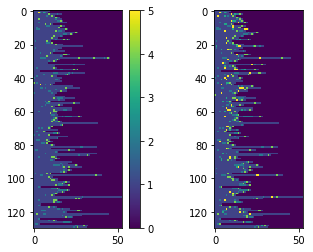

epoch:   81
0.000 perplexity: 1.086 speed: 297 wps
0.077 perplexity: 1.099 speed: 299 wps
0.154 perplexity: 1.108 speed: 300 wps
0.231 perplexity: 1.099 speed: 301 wps
0.308 perplexity: 1.098 speed: 301 wps
0.385 perplexity: 1.099 speed: 300 wps
0.462 perplexity: 1.096 speed: 300 wps
0.538 perplexity: 1.090 speed: 300 wps
0.615 perplexity: 1.086 speed: 300 wps
0.692 perplexity: 1.088 speed: 300 wps
0.769 perplexity: 1.086 speed: 301 wps
0.846 perplexity: 1.087 speed: 300 wps
0.923 perplexity: 1.085 speed: 300 wps


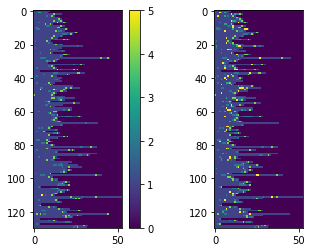

epoch:   82
0.000 perplexity: 1.072 speed: 292 wps
0.077 perplexity: 1.090 speed: 296 wps
0.154 perplexity: 1.099 speed: 298 wps
0.231 perplexity: 1.093 speed: 299 wps
0.308 perplexity: 1.093 speed: 300 wps
0.385 perplexity: 1.093 speed: 299 wps
0.462 perplexity: 1.090 speed: 300 wps
0.538 perplexity: 1.082 speed: 301 wps
0.615 perplexity: 1.080 speed: 301 wps
0.692 perplexity: 1.085 speed: 300 wps
0.769 perplexity: 1.082 speed: 300 wps
0.846 perplexity: 1.080 speed: 300 wps
0.923 perplexity: 1.079 speed: 300 wps


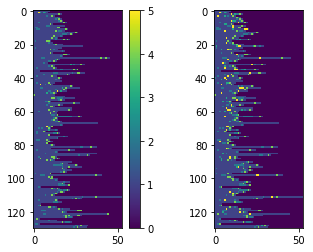

epoch:   83
0.000 perplexity: 1.091 speed: 295 wps
0.077 perplexity: 1.095 speed: 299 wps
0.154 perplexity: 1.098 speed: 301 wps
0.231 perplexity: 1.090 speed: 300 wps
0.308 perplexity: 1.088 speed: 300 wps
0.385 perplexity: 1.086 speed: 300 wps
0.462 perplexity: 1.086 speed: 300 wps
0.538 perplexity: 1.077 speed: 300 wps
0.615 perplexity: 1.075 speed: 301 wps
0.692 perplexity: 1.080 speed: 300 wps
0.769 perplexity: 1.078 speed: 300 wps
0.846 perplexity: 1.078 speed: 300 wps
0.923 perplexity: 1.077 speed: 301 wps


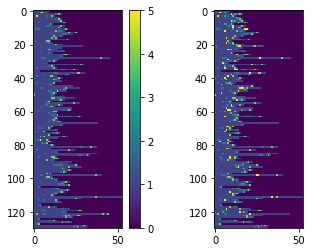

epoch:   84
0.000 perplexity: 1.076 speed: 294 wps
0.077 perplexity: 1.085 speed: 294 wps
0.154 perplexity: 1.101 speed: 296 wps
0.231 perplexity: 1.094 speed: 297 wps
0.308 perplexity: 1.091 speed: 298 wps
0.385 perplexity: 1.090 speed: 297 wps
0.462 perplexity: 1.086 speed: 298 wps
0.538 perplexity: 1.079 speed: 298 wps
0.615 perplexity: 1.075 speed: 298 wps
0.692 perplexity: 1.077 speed: 298 wps
0.769 perplexity: 1.075 speed: 299 wps
0.846 perplexity: 1.076 speed: 299 wps
0.923 perplexity: 1.074 speed: 299 wps


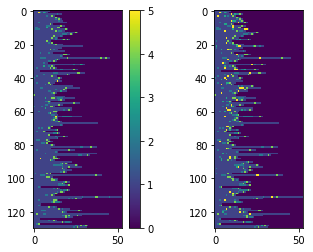

epoch:   85
0.000 perplexity: 1.081 speed: 296 wps
0.077 perplexity: 1.079 speed: 299 wps
0.154 perplexity: 1.096 speed: 299 wps
0.231 perplexity: 1.098 speed: 299 wps
0.308 perplexity: 1.144 speed: 300 wps
0.385 perplexity: 1.147 speed: 300 wps
0.462 perplexity: 1.145 speed: 301 wps
0.538 perplexity: 1.135 speed: 301 wps
0.615 perplexity: 1.126 speed: 301 wps
0.692 perplexity: 1.126 speed: 301 wps
0.769 perplexity: 1.122 speed: 300 wps
0.846 perplexity: 1.119 speed: 300 wps
0.923 perplexity: 1.116 speed: 300 wps


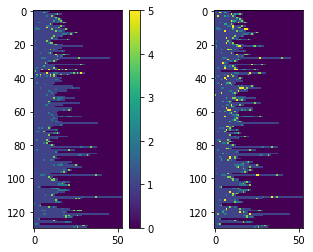

epoch:   86
0.000 perplexity: 1.122 speed: 295 wps
0.077 perplexity: 1.127 speed: 299 wps
0.154 perplexity: 1.131 speed: 300 wps
0.231 perplexity: 1.116 speed: 302 wps
0.308 perplexity: 1.113 speed: 301 wps
0.385 perplexity: 1.113 speed: 301 wps
0.462 perplexity: 1.112 speed: 301 wps
0.538 perplexity: 1.104 speed: 301 wps
0.615 perplexity: 1.098 speed: 301 wps
0.692 perplexity: 1.102 speed: 301 wps
0.769 perplexity: 1.097 speed: 301 wps
0.846 perplexity: 1.096 speed: 300 wps
0.923 perplexity: 1.095 speed: 300 wps


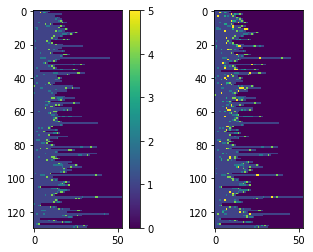

epoch:   87
0.000 perplexity: 1.063 speed: 293 wps
0.077 perplexity: 1.108 speed: 296 wps
0.154 perplexity: 1.114 speed: 298 wps
0.231 perplexity: 1.101 speed: 299 wps
0.308 perplexity: 1.102 speed: 300 wps
0.385 perplexity: 1.104 speed: 300 wps
0.462 perplexity: 1.101 speed: 300 wps
0.538 perplexity: 1.093 speed: 300 wps
0.615 perplexity: 1.088 speed: 300 wps
0.692 perplexity: 1.093 speed: 300 wps
0.769 perplexity: 1.089 speed: 300 wps
0.846 perplexity: 1.089 speed: 300 wps
0.923 perplexity: 1.087 speed: 300 wps


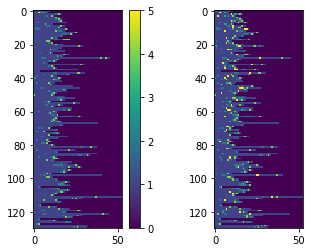

epoch:   88
0.000 perplexity: 1.084 speed: 294 wps
0.077 perplexity: 1.096 speed: 299 wps
0.154 perplexity: 1.106 speed: 299 wps
0.231 perplexity: 1.099 speed: 299 wps
0.308 perplexity: 1.098 speed: 299 wps
0.385 perplexity: 1.099 speed: 299 wps
0.462 perplexity: 1.097 speed: 288 wps
0.538 perplexity: 1.089 speed: 272 wps
0.615 perplexity: 1.086 speed: 267 wps
0.692 perplexity: 1.089 speed: 261 wps
0.769 perplexity: 1.084 speed: 259 wps
0.846 perplexity: 1.082 speed: 262 wps
0.923 perplexity: 1.081 speed: 264 wps


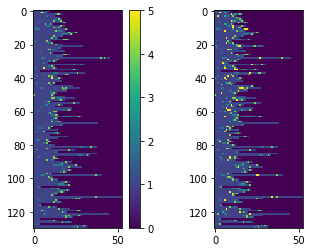

epoch:   89
0.000 perplexity: 1.070 speed: 269 wps
0.077 perplexity: 1.087 speed: 283 wps
0.154 perplexity: 1.094 speed: 289 wps
0.231 perplexity: 1.083 speed: 291 wps
0.308 perplexity: 1.082 speed: 294 wps
0.385 perplexity: 1.083 speed: 295 wps
0.462 perplexity: 1.081 speed: 296 wps
0.538 perplexity: 1.076 speed: 297 wps
0.615 perplexity: 1.074 speed: 297 wps
0.692 perplexity: 1.079 speed: 297 wps
0.769 perplexity: 1.076 speed: 298 wps
0.846 perplexity: 1.075 speed: 298 wps
0.923 perplexity: 1.076 speed: 298 wps


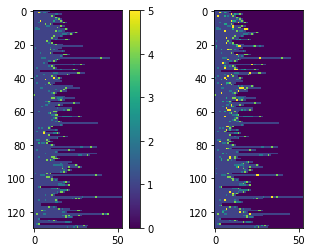

epoch:   90
0.000 perplexity: 1.060 speed: 296 wps
0.077 perplexity: 1.080 speed: 299 wps
0.154 perplexity: 1.098 speed: 299 wps
0.231 perplexity: 1.090 speed: 299 wps
0.308 perplexity: 1.087 speed: 299 wps
0.385 perplexity: 1.087 speed: 299 wps
0.462 perplexity: 1.085 speed: 299 wps
0.538 perplexity: 1.079 speed: 299 wps
0.615 perplexity: 1.075 speed: 299 wps
0.692 perplexity: 1.078 speed: 299 wps
0.769 perplexity: 1.075 speed: 299 wps
0.846 perplexity: 1.074 speed: 299 wps
0.923 perplexity: 1.073 speed: 299 wps


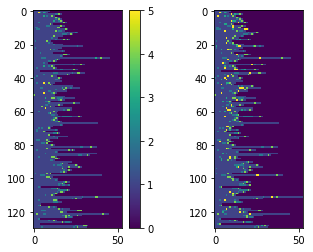

epoch:   91
0.000 perplexity: 1.086 speed: 293 wps
0.077 perplexity: 1.091 speed: 298 wps
0.154 perplexity: 1.100 speed: 299 wps
0.231 perplexity: 1.086 speed: 298 wps
0.308 perplexity: 1.089 speed: 298 wps
0.385 perplexity: 1.092 speed: 298 wps
0.462 perplexity: 1.090 speed: 299 wps
0.538 perplexity: 1.083 speed: 298 wps
0.615 perplexity: 1.081 speed: 299 wps
0.692 perplexity: 1.083 speed: 299 wps
0.769 perplexity: 1.081 speed: 299 wps
0.846 perplexity: 1.080 speed: 299 wps
0.923 perplexity: 1.079 speed: 299 wps


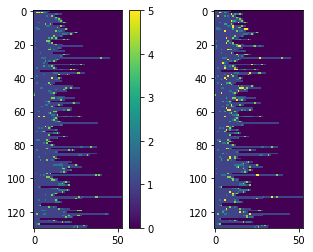

epoch:   92
0.000 perplexity: 1.066 speed: 292 wps
0.077 perplexity: 1.085 speed: 298 wps
0.154 perplexity: 1.105 speed: 298 wps
0.231 perplexity: 1.124 speed: 272 wps
0.308 perplexity: 1.121 speed: 257 wps
0.385 perplexity: 1.118 speed: 253 wps
0.462 perplexity: 1.113 speed: 251 wps
0.538 perplexity: 1.103 speed: 253 wps
0.615 perplexity: 1.099 speed: 258 wps
0.692 perplexity: 1.101 speed: 262 wps
0.769 perplexity: 1.097 speed: 265 wps
0.846 perplexity: 1.093 speed: 267 wps
0.923 perplexity: 1.091 speed: 270 wps


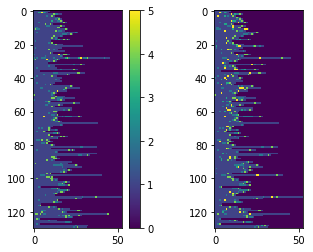

epoch:   93
0.000 perplexity: 1.060 speed: 296 wps
0.077 perplexity: 1.090 speed: 298 wps
0.154 perplexity: 1.102 speed: 301 wps
0.231 perplexity: 1.118 speed: 301 wps
0.308 perplexity: 1.129 speed: 300 wps
0.385 perplexity: 1.130 speed: 300 wps
0.462 perplexity: 1.127 speed: 301 wps
0.538 perplexity: 1.117 speed: 300 wps
0.615 perplexity: 1.111 speed: 301 wps
0.692 perplexity: 1.115 speed: 301 wps
0.769 perplexity: 1.110 speed: 300 wps
0.846 perplexity: 1.107 speed: 300 wps
0.923 perplexity: 1.105 speed: 300 wps


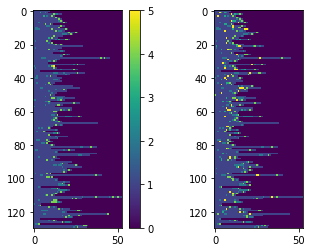

epoch:   94
0.000 perplexity: 1.089 speed: 287 wps
0.077 perplexity: 1.095 speed: 283 wps
0.154 perplexity: 1.107 speed: 287 wps
0.231 perplexity: 1.095 speed: 290 wps
0.308 perplexity: 1.096 speed: 293 wps
0.385 perplexity: 1.098 speed: 290 wps
0.462 perplexity: 1.094 speed: 283 wps
0.538 perplexity: 1.086 speed: 277 wps
0.615 perplexity: 1.082 speed: 277 wps
0.692 perplexity: 1.084 speed: 273 wps
0.769 perplexity: 1.081 speed: 262 wps
0.846 perplexity: 1.081 speed: 256 wps
0.923 perplexity: 1.079 speed: 252 wps


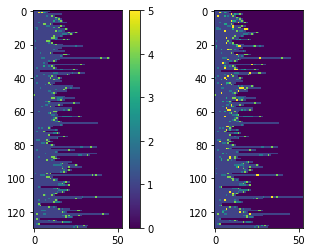

epoch:   95
0.000 perplexity: 1.093 speed: 300 wps
0.077 perplexity: 1.105 speed: 299 wps
0.154 perplexity: 1.103 speed: 299 wps
0.231 perplexity: 1.090 speed: 299 wps
0.308 perplexity: 1.092 speed: 299 wps
0.385 perplexity: 1.094 speed: 298 wps
0.462 perplexity: 1.111 speed: 298 wps
0.538 perplexity: 1.106 speed: 299 wps
0.615 perplexity: 1.110 speed: 299 wps
0.692 perplexity: 1.123 speed: 299 wps
0.769 perplexity: 1.131 speed: 299 wps
0.846 perplexity: 1.131 speed: 299 wps
0.923 perplexity: 1.129 speed: 299 wps


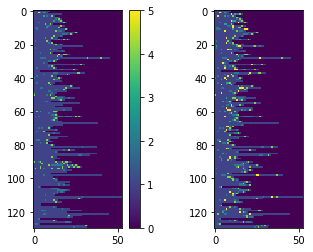

epoch:   96
0.000 perplexity: 1.095 speed: 292 wps
0.077 perplexity: 1.118 speed: 297 wps
0.154 perplexity: 1.137 speed: 299 wps
0.231 perplexity: 1.138 speed: 299 wps
0.308 perplexity: 1.135 speed: 299 wps
0.385 perplexity: 1.133 speed: 299 wps
0.462 perplexity: 1.132 speed: 291 wps
0.538 perplexity: 1.122 speed: 286 wps
0.615 perplexity: 1.116 speed: 287 wps
0.692 perplexity: 1.121 speed: 286 wps
0.769 perplexity: 1.116 speed: 278 wps
0.846 perplexity: 1.113 speed: 278 wps
0.923 perplexity: 1.120 speed: 271 wps


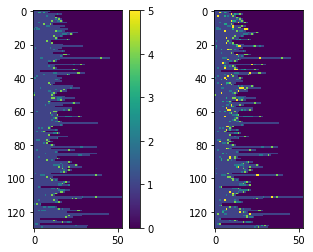

epoch:   97
0.000 perplexity: 1.113 speed: 236 wps
0.077 perplexity: 1.151 speed: 225 wps
0.154 perplexity: 1.152 speed: 230 wps
0.231 perplexity: 1.141 speed: 235 wps
0.308 perplexity: 1.135 speed: 245 wps
0.385 perplexity: 1.142 speed: 246 wps
0.462 perplexity: 1.140 speed: 251 wps
0.538 perplexity: 1.131 speed: 254 wps
0.615 perplexity: 1.124 speed: 257 wps
0.692 perplexity: 1.127 speed: 258 wps
0.769 perplexity: 1.122 speed: 258 wps
0.846 perplexity: 1.131 speed: 260 wps
0.923 perplexity: 1.136 speed: 256 wps


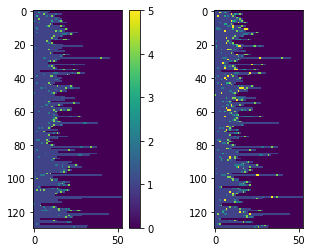

epoch:   98
0.000 perplexity: 1.151 speed: 286 wps
0.077 perplexity: 1.157 speed: 270 wps
0.154 perplexity: 1.156 speed: 268 wps
0.231 perplexity: 1.147 speed: 264 wps
0.308 perplexity: 1.142 speed: 259 wps
0.385 perplexity: 1.139 speed: 261 wps
0.462 perplexity: 1.136 speed: 258 wps
0.538 perplexity: 1.127 speed: 262 wps
0.615 perplexity: 1.121 speed: 266 wps
0.692 perplexity: 1.122 speed: 267 wps
0.769 perplexity: 1.117 speed: 269 wps
0.846 perplexity: 1.117 speed: 271 wps
0.923 perplexity: 1.114 speed: 273 wps


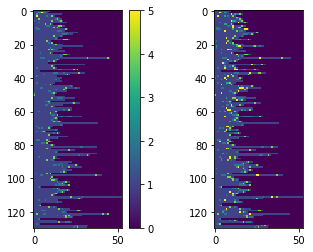

epoch:   99
0.000 perplexity: 1.104 speed: 285 wps
0.077 perplexity: 1.123 speed: 294 wps
0.154 perplexity: 1.125 speed: 294 wps
0.231 perplexity: 1.123 speed: 295 wps
0.308 perplexity: 1.124 speed: 295 wps
0.385 perplexity: 1.123 speed: 295 wps
0.462 perplexity: 1.122 speed: 295 wps
0.538 perplexity: 1.114 speed: 294 wps
0.615 perplexity: 1.107 speed: 295 wps
0.692 perplexity: 1.111 speed: 295 wps
0.769 perplexity: 1.106 speed: 294 wps
0.846 perplexity: 1.106 speed: 269 wps
0.923 perplexity: 1.108 speed: 271 wps


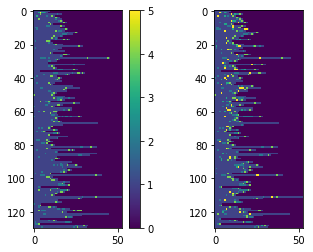

epoch:  100
0.000 perplexity: 1.111 speed: 284 wps
0.077 perplexity: 1.107 speed: 288 wps
0.154 perplexity: 1.114 speed: 290 wps
0.231 perplexity: 1.106 speed: 292 wps
0.308 perplexity: 1.103 speed: 293 wps
0.385 perplexity: 1.104 speed: 294 wps
0.462 perplexity: 1.103 speed: 294 wps
0.538 perplexity: 1.096 speed: 295 wps
0.615 perplexity: 1.092 speed: 295 wps
0.692 perplexity: 1.097 speed: 296 wps
0.769 perplexity: 1.097 speed: 296 wps
0.846 perplexity: 1.097 speed: 296 wps
0.923 perplexity: 1.096 speed: 296 wps


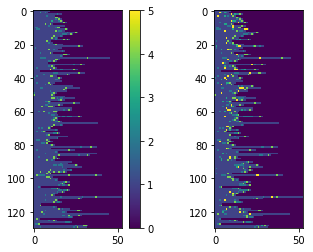

epoch:  101
0.000 perplexity: 1.120 speed: 256 wps
0.077 perplexity: 1.128 speed: 200 wps
0.154 perplexity: 1.125 speed: 205 wps
0.231 perplexity: 1.112 speed: 210 wps
0.308 perplexity: 1.106 speed: 219 wps
0.385 perplexity: 1.106 speed: 230 wps
0.462 perplexity: 1.106 speed: 238 wps
0.538 perplexity: 1.099 speed: 244 wps
0.615 perplexity: 1.093 speed: 250 wps
0.692 perplexity: 1.095 speed: 254 wps
0.769 perplexity: 1.093 speed: 258 wps
0.846 perplexity: 1.093 speed: 261 wps
0.923 perplexity: 1.091 speed: 263 wps


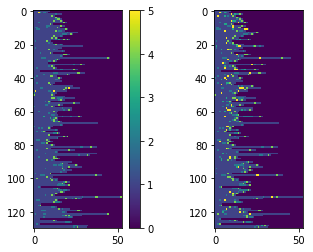

epoch:  102
0.000 perplexity: 1.089 speed: 293 wps
0.077 perplexity: 1.097 speed: 298 wps
0.154 perplexity: 1.112 speed: 285 wps
0.231 perplexity: 1.105 speed: 278 wps
0.308 perplexity: 1.104 speed: 282 wps
0.385 perplexity: 1.103 speed: 285 wps
0.462 perplexity: 1.101 speed: 286 wps
0.538 perplexity: 1.092 speed: 288 wps
0.615 perplexity: 1.089 speed: 289 wps
0.692 perplexity: 1.091 speed: 289 wps
0.769 perplexity: 1.087 speed: 290 wps
0.846 perplexity: 1.089 speed: 291 wps
0.923 perplexity: 1.094 speed: 291 wps


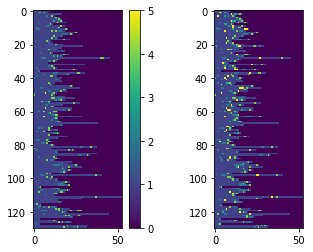

epoch:  103
0.000 perplexity: 1.101 speed: 298 wps
0.077 perplexity: 1.113 speed: 295 wps
0.154 perplexity: 1.115 speed: 297 wps
0.231 perplexity: 1.104 speed: 296 wps
0.308 perplexity: 1.099 speed: 295 wps
0.385 perplexity: 1.099 speed: 294 wps
0.462 perplexity: 1.097 speed: 295 wps
0.538 perplexity: 1.091 speed: 293 wps
0.615 perplexity: 1.087 speed: 293 wps
0.692 perplexity: 1.088 speed: 293 wps
0.769 perplexity: 1.084 speed: 293 wps
0.846 perplexity: 1.085 speed: 294 wps
0.923 perplexity: 1.086 speed: 294 wps


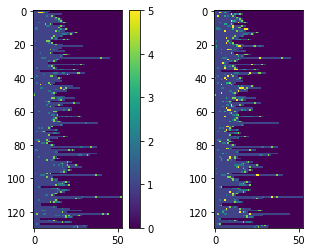

epoch:  104
0.000 perplexity: 1.081 speed: 294 wps
0.077 perplexity: 1.109 speed: 297 wps
0.154 perplexity: 1.113 speed: 297 wps
0.231 perplexity: 1.104 speed: 284 wps
0.308 perplexity: 1.102 speed: 272 wps
0.385 perplexity: 1.103 speed: 262 wps
0.462 perplexity: 1.103 speed: 263 wps
0.538 perplexity: 1.096 speed: 257 wps
0.615 perplexity: 1.091 speed: 248 wps
0.692 perplexity: 1.093 speed: 245 wps
0.769 perplexity: 1.091 speed: 246 wps
0.846 perplexity: 1.090 speed: 250 wps
0.923 perplexity: 1.089 speed: 248 wps


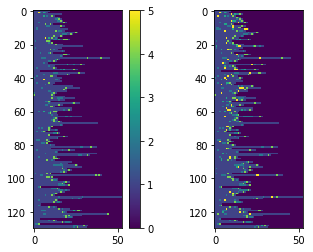

epoch:  105
0.000 perplexity: 1.055 speed: 270 wps
0.077 perplexity: 1.083 speed: 253 wps
0.154 perplexity: 1.093 speed: 261 wps
0.231 perplexity: 1.085 speed: 267 wps
0.308 perplexity: 1.088 speed: 268 wps
0.385 perplexity: 1.092 speed: 269 wps
0.462 perplexity: 1.090 speed: 272 wps
0.538 perplexity: 1.083 speed: 271 wps
0.615 perplexity: 1.080 speed: 271 wps
0.692 perplexity: 1.086 speed: 271 wps
0.769 perplexity: 1.085 speed: 268 wps
0.846 perplexity: 1.087 speed: 269 wps
0.923 perplexity: 1.086 speed: 271 wps


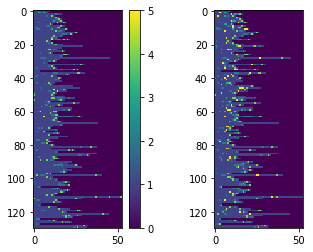

epoch:  106
0.000 perplexity: 1.076 speed: 294 wps
0.077 perplexity: 1.076 speed: 282 wps
0.154 perplexity: 1.090 speed: 277 wps
0.231 perplexity: 1.084 speed: 275 wps
0.308 perplexity: 1.085 speed: 278 wps
0.385 perplexity: 1.089 speed: 280 wps
0.462 perplexity: 1.088 speed: 280 wps
0.538 perplexity: 1.081 speed: 278 wps
0.615 perplexity: 1.079 speed: 280 wps
0.692 perplexity: 1.081 speed: 282 wps
0.769 perplexity: 1.079 speed: 283 wps
0.846 perplexity: 1.078 speed: 285 wps
0.923 perplexity: 1.077 speed: 286 wps


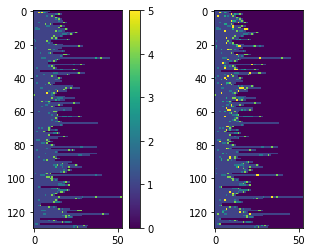

epoch:  107
0.000 perplexity: 1.072 speed: 284 wps
0.077 perplexity: 1.078 speed: 294 wps
0.154 perplexity: 1.083 speed: 291 wps
0.231 perplexity: 1.074 speed: 279 wps
0.308 perplexity: 1.072 speed: 280 wps
0.385 perplexity: 1.073 speed: 279 wps
0.462 perplexity: 1.074 speed: 278 wps
0.538 perplexity: 1.070 speed: 279 wps
0.615 perplexity: 1.068 speed: 280 wps
0.692 perplexity: 1.077 speed: 281 wps
0.769 perplexity: 1.087 speed: 277 wps
0.846 perplexity: 1.094 speed: 272 wps
0.923 perplexity: 1.108 speed: 271 wps


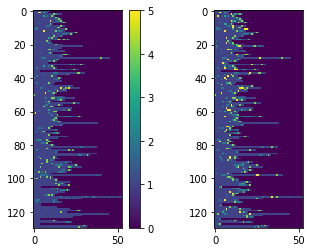

epoch:  108
0.000 perplexity: 1.127 speed: 277 wps
0.077 perplexity: 1.132 speed: 285 wps
0.154 perplexity: 1.144 speed: 282 wps
0.231 perplexity: 1.145 speed: 281 wps
0.308 perplexity: 1.142 speed: 281 wps
0.385 perplexity: 1.138 speed: 282 wps
0.462 perplexity: 1.137 speed: 280 wps
0.538 perplexity: 1.127 speed: 280 wps
0.615 perplexity: 1.119 speed: 280 wps
0.692 perplexity: 1.120 speed: 280 wps
0.769 perplexity: 1.115 speed: 279 wps
0.846 perplexity: 1.115 speed: 277 wps
0.923 perplexity: 1.113 speed: 272 wps


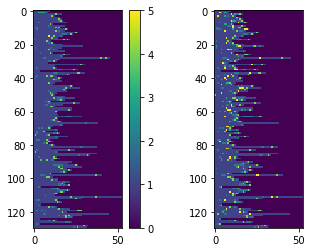

epoch:  109
0.000 perplexity: 1.105 speed: 285 wps
0.077 perplexity: 1.119 speed: 275 wps
0.154 perplexity: 1.127 speed: 279 wps
0.231 perplexity: 1.115 speed: 286 wps
0.308 perplexity: 1.113 speed: 289 wps
0.385 perplexity: 1.112 speed: 291 wps
0.462 perplexity: 1.109 speed: 289 wps
0.538 perplexity: 1.100 speed: 287 wps
0.615 perplexity: 1.096 speed: 288 wps
0.692 perplexity: 1.099 speed: 289 wps
0.769 perplexity: 1.095 speed: 286 wps
0.846 perplexity: 1.093 speed: 275 wps
0.923 perplexity: 1.092 speed: 268 wps


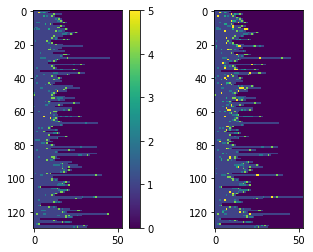

epoch:  110
0.000 perplexity: 1.087 speed: 282 wps
0.077 perplexity: 1.103 speed: 288 wps
0.154 perplexity: 1.115 speed: 288 wps
0.231 perplexity: 1.106 speed: 288 wps
0.308 perplexity: 1.101 speed: 287 wps
0.385 perplexity: 1.099 speed: 284 wps
0.462 perplexity: 1.096 speed: 284 wps
0.538 perplexity: 1.088 speed: 283 wps
0.615 perplexity: 1.085 speed: 282 wps
0.692 perplexity: 1.089 speed: 284 wps
0.769 perplexity: 1.085 speed: 286 wps
0.846 perplexity: 1.085 speed: 287 wps
0.923 perplexity: 1.086 speed: 288 wps


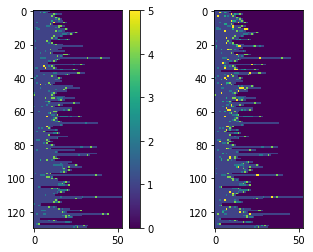

epoch:  111
0.000 perplexity: 1.063 speed: 294 wps
0.077 perplexity: 1.090 speed: 297 wps
0.154 perplexity: 1.096 speed: 284 wps
0.231 perplexity: 1.086 speed: 287 wps
0.308 perplexity: 1.085 speed: 289 wps
0.385 perplexity: 1.087 speed: 290 wps
0.462 perplexity: 1.084 speed: 290 wps
0.538 perplexity: 1.079 speed: 291 wps
0.615 perplexity: 1.076 speed: 291 wps
0.692 perplexity: 1.082 speed: 290 wps
0.769 perplexity: 1.078 speed: 290 wps
0.846 perplexity: 1.079 speed: 289 wps
0.923 perplexity: 1.079 speed: 283 wps


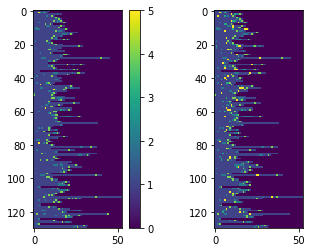

epoch:  112
0.000 perplexity: 1.072 speed: 299 wps
0.077 perplexity: 1.080 speed: 292 wps
0.154 perplexity: 1.091 speed: 293 wps
0.231 perplexity: 1.084 speed: 296 wps
0.308 perplexity: 1.084 speed: 294 wps
0.385 perplexity: 1.085 speed: 296 wps
0.462 perplexity: 1.081 speed: 297 wps
0.538 perplexity: 1.074 speed: 298 wps
0.615 perplexity: 1.073 speed: 298 wps
0.692 perplexity: 1.077 speed: 298 wps
0.769 perplexity: 1.074 speed: 299 wps
0.846 perplexity: 1.073 speed: 299 wps
0.923 perplexity: 1.074 speed: 299 wps


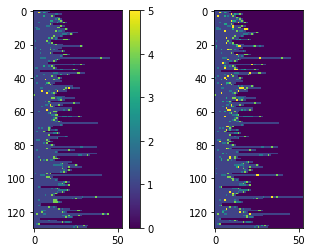

epoch:  113
0.000 perplexity: 1.091 speed: 259 wps
0.077 perplexity: 1.082 speed: 282 wps
0.154 perplexity: 1.092 speed: 288 wps
0.231 perplexity: 1.081 speed: 291 wps
0.308 perplexity: 1.080 speed: 289 wps
0.385 perplexity: 1.081 speed: 288 wps
0.462 perplexity: 1.079 speed: 289 wps
0.538 perplexity: 1.072 speed: 289 wps
0.615 perplexity: 1.071 speed: 291 wps
0.692 perplexity: 1.075 speed: 292 wps
0.769 perplexity: 1.072 speed: 293 wps
0.846 perplexity: 1.072 speed: 294 wps
0.923 perplexity: 1.071 speed: 294 wps


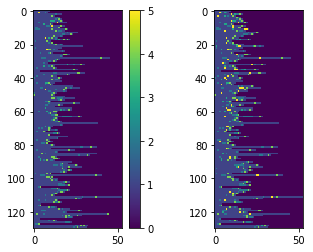

epoch:  114
0.000 perplexity: 1.067 speed: 300 wps
0.077 perplexity: 1.068 speed: 302 wps
0.154 perplexity: 1.076 speed: 302 wps
0.231 perplexity: 1.070 speed: 302 wps
0.308 perplexity: 1.068 speed: 303 wps
0.385 perplexity: 1.070 speed: 303 wps
0.462 perplexity: 1.067 speed: 300 wps
0.538 perplexity: 1.064 speed: 286 wps
0.615 perplexity: 1.062 speed: 277 wps
0.692 perplexity: 1.068 speed: 274 wps
0.769 perplexity: 1.066 speed: 270 wps
0.846 perplexity: 1.079 speed: 265 wps
0.923 perplexity: 1.103 speed: 260 wps


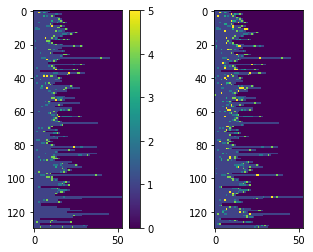

epoch:  115
0.000 perplexity: 1.268 speed: 287 wps
0.077 perplexity: 1.310 speed: 257 wps
0.154 perplexity: 1.306 speed: 271 wps
0.231 perplexity: 1.299 speed: 278 wps
0.308 perplexity: 1.291 speed: 282 wps
0.385 perplexity: 1.285 speed: 283 wps
0.462 perplexity: 1.285 speed: 285 wps
0.538 perplexity: 1.274 speed: 286 wps
0.615 perplexity: 1.260 speed: 286 wps
0.692 perplexity: 1.261 speed: 287 wps
0.769 perplexity: 1.258 speed: 288 wps
0.846 perplexity: 1.258 speed: 288 wps
0.923 perplexity: 1.255 speed: 289 wps


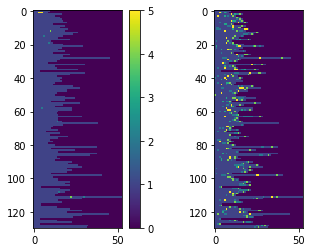

epoch:  116
0.000 perplexity: 1.210 speed: 287 wps
0.077 perplexity: 1.259 speed: 293 wps
0.154 perplexity: 1.246 speed: 294 wps
0.231 perplexity: 1.236 speed: 293 wps
0.308 perplexity: 1.240 speed: 294 wps
0.385 perplexity: 1.235 speed: 295 wps
0.462 perplexity: 1.238 speed: 295 wps
0.538 perplexity: 1.233 speed: 295 wps
0.615 perplexity: 1.226 speed: 281 wps
0.692 perplexity: 1.229 speed: 271 wps
0.769 perplexity: 1.226 speed: 264 wps
0.846 perplexity: 1.226 speed: 258 wps
0.923 perplexity: 1.227 speed: 253 wps


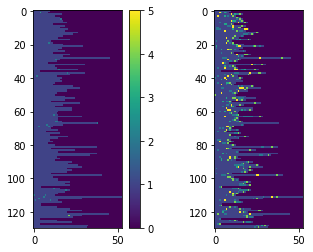

epoch:  117
0.000 perplexity: 1.200 speed: 286 wps
0.077 perplexity: 1.263 speed: 291 wps
0.154 perplexity: 1.254 speed: 291 wps
0.231 perplexity: 1.238 speed: 292 wps
0.308 perplexity: 1.232 speed: 292 wps
0.385 perplexity: 1.233 speed: 293 wps
0.462 perplexity: 1.237 speed: 293 wps
0.538 perplexity: 1.244 speed: 293 wps
0.615 perplexity: 1.237 speed: 294 wps
0.692 perplexity: 1.241 speed: 294 wps
0.769 perplexity: 1.238 speed: 291 wps
0.846 perplexity: 1.241 speed: 291 wps
0.923 perplexity: 1.238 speed: 291 wps


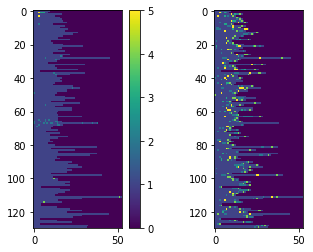

epoch:  118
0.000 perplexity: 1.192 speed: 289 wps
0.077 perplexity: 1.254 speed: 293 wps
0.154 perplexity: 1.239 speed: 295 wps
0.231 perplexity: 1.232 speed: 295 wps
0.308 perplexity: 1.231 speed: 294 wps
0.385 perplexity: 1.229 speed: 294 wps
0.462 perplexity: 1.229 speed: 294 wps
0.538 perplexity: 1.221 speed: 294 wps
0.615 perplexity: 1.213 speed: 286 wps
0.692 perplexity: 1.215 speed: 283 wps
0.769 perplexity: 1.213 speed: 276 wps
0.846 perplexity: 1.214 speed: 265 wps
0.923 perplexity: 1.210 speed: 258 wps


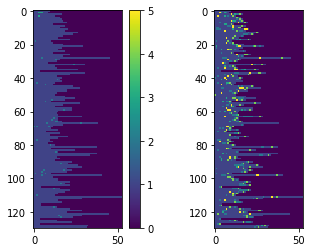

epoch:  119
0.000 perplexity: 1.175 speed: 193 wps
0.077 perplexity: 1.249 speed: 220 wps
0.154 perplexity: 1.247 speed: 226 wps
0.231 perplexity: 1.244 speed: 225 wps
0.308 perplexity: 1.243 speed: 233 wps
0.385 perplexity: 1.245 speed: 239 wps
0.462 perplexity: 1.251 speed: 238 wps
0.538 perplexity: 1.247 speed: 231 wps
0.615 perplexity: 1.238 speed: 228 wps
0.692 perplexity: 1.240 speed: 228 wps
0.769 perplexity: 1.236 speed: 233 wps
0.846 perplexity: 1.237 speed: 238 wps
0.923 perplexity: 1.232 speed: 242 wps


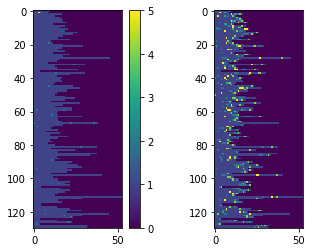

epoch:  120
0.000 perplexity: 1.153 speed: 286 wps
0.077 perplexity: 1.229 speed: 291 wps
0.154 perplexity: 1.220 speed: 293 wps
0.231 perplexity: 1.218 speed: 292 wps
0.308 perplexity: 1.234 speed: 292 wps
0.385 perplexity: 1.243 speed: 292 wps
0.462 perplexity: 1.248 speed: 292 wps
0.538 perplexity: 1.239 speed: 293 wps
0.615 perplexity: 1.228 speed: 292 wps
0.692 perplexity: 1.231 speed: 292 wps
0.769 perplexity: 1.227 speed: 292 wps
0.846 perplexity: 1.226 speed: 293 wps
0.923 perplexity: 1.223 speed: 293 wps


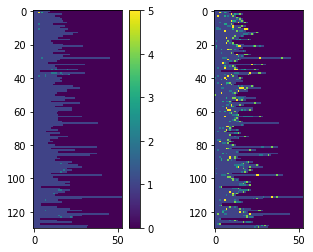

epoch:  121
0.000 perplexity: 1.146 speed: 288 wps
0.077 perplexity: 1.229 speed: 294 wps
0.154 perplexity: 1.236 speed: 294 wps
0.231 perplexity: 1.229 speed: 294 wps
0.308 perplexity: 1.228 speed: 295 wps
0.385 perplexity: 1.225 speed: 295 wps
0.462 perplexity: 1.228 speed: 295 wps
0.538 perplexity: 1.224 speed: 295 wps
0.615 perplexity: 1.213 speed: 295 wps
0.692 perplexity: 1.215 speed: 295 wps
0.769 perplexity: 1.212 speed: 295 wps
0.846 perplexity: 1.211 speed: 295 wps
0.923 perplexity: 1.210 speed: 295 wps


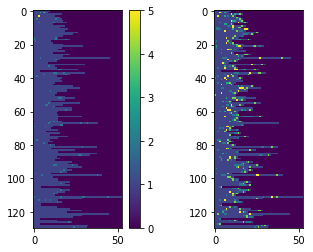

epoch:  122
0.000 perplexity: 1.149 speed: 288 wps
0.077 perplexity: 1.223 speed: 292 wps
0.154 perplexity: 1.214 speed: 293 wps
0.231 perplexity: 1.209 speed: 294 wps
0.308 perplexity: 1.216 speed: 295 wps
0.385 perplexity: 1.217 speed: 295 wps
0.462 perplexity: 1.217 speed: 292 wps
0.538 perplexity: 1.205 speed: 291 wps
0.615 perplexity: 1.196 speed: 291 wps
0.692 perplexity: 1.198 speed: 292 wps
0.769 perplexity: 1.201 speed: 292 wps
0.846 perplexity: 1.201 speed: 292 wps
0.923 perplexity: 1.198 speed: 292 wps


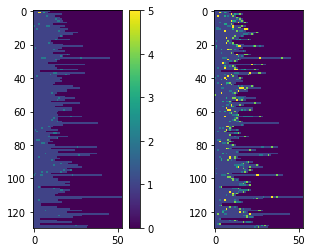

epoch:  123
0.000 perplexity: 1.185 speed: 289 wps
0.077 perplexity: 1.306 speed: 293 wps
0.154 perplexity: 1.281 speed: 294 wps
0.231 perplexity: 1.260 speed: 295 wps
0.308 perplexity: 1.252 speed: 295 wps
0.385 perplexity: 1.244 speed: 296 wps
0.462 perplexity: 1.241 speed: 295 wps
0.538 perplexity: 1.227 speed: 275 wps
0.615 perplexity: 1.214 speed: 270 wps
0.692 perplexity: 1.214 speed: 273 wps
0.769 perplexity: 1.213 speed: 275 wps
0.846 perplexity: 1.210 speed: 273 wps
0.923 perplexity: 1.205 speed: 261 wps


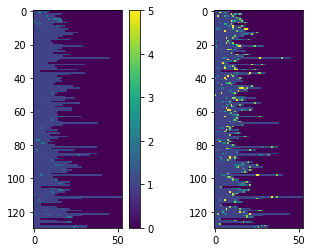

epoch:  124
0.000 perplexity: 1.135 speed: 182 wps
0.077 perplexity: 1.206 speed: 189 wps
0.154 perplexity: 1.212 speed: 206 wps
0.231 perplexity: 1.214 speed: 218 wps
0.308 perplexity: 1.226 speed: 225 wps
0.385 perplexity: 1.220 speed: 234 wps
0.462 perplexity: 1.218 speed: 242 wps
0.538 perplexity: 1.206 speed: 249 wps
0.615 perplexity: 1.195 speed: 254 wps
0.692 perplexity: 1.201 speed: 258 wps
0.769 perplexity: 1.198 speed: 262 wps
0.846 perplexity: 1.196 speed: 265 wps
0.923 perplexity: 1.194 speed: 267 wps


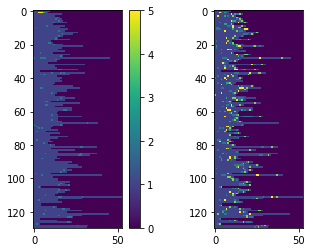

epoch:  125
0.000 perplexity: 1.177 speed: 296 wps
0.077 perplexity: 1.210 speed: 301 wps
0.154 perplexity: 1.202 speed: 301 wps
0.231 perplexity: 1.197 speed: 302 wps
0.308 perplexity: 1.199 speed: 302 wps
0.385 perplexity: 1.203 speed: 302 wps
0.462 perplexity: 1.203 speed: 302 wps
0.538 perplexity: 1.192 speed: 302 wps
0.615 perplexity: 1.183 speed: 302 wps
0.692 perplexity: 1.186 speed: 302 wps
0.769 perplexity: 1.182 speed: 302 wps
0.846 perplexity: 1.182 speed: 302 wps
0.923 perplexity: 1.181 speed: 302 wps


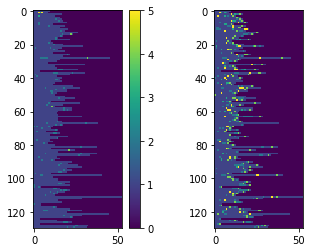

epoch:  126
0.000 perplexity: 1.188 speed: 299 wps
0.077 perplexity: 1.211 speed: 249 wps
0.154 perplexity: 1.208 speed: 267 wps
0.231 perplexity: 1.192 speed: 277 wps
0.308 perplexity: 1.200 speed: 282 wps
0.385 perplexity: 1.198 speed: 285 wps
0.462 perplexity: 1.203 speed: 288 wps
0.538 perplexity: 1.200 speed: 290 wps
0.615 perplexity: 1.191 speed: 291 wps
0.692 perplexity: 1.194 speed: 292 wps
0.769 perplexity: 1.191 speed: 293 wps
0.846 perplexity: 1.189 speed: 293 wps
0.923 perplexity: 1.188 speed: 294 wps


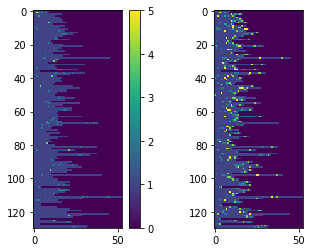

epoch:  127
0.000 perplexity: 1.142 speed: 297 wps
0.077 perplexity: 1.193 speed: 300 wps
0.154 perplexity: 1.192 speed: 301 wps
0.231 perplexity: 1.179 speed: 296 wps
0.308 perplexity: 1.187 speed: 294 wps
0.385 perplexity: 1.194 speed: 294 wps
0.462 perplexity: 1.198 speed: 296 wps
0.538 perplexity: 1.186 speed: 296 wps
0.615 perplexity: 1.178 speed: 297 wps
0.692 perplexity: 1.187 speed: 298 wps
0.769 perplexity: 1.189 speed: 298 wps
0.846 perplexity: 1.192 speed: 299 wps
0.923 perplexity: 1.192 speed: 299 wps


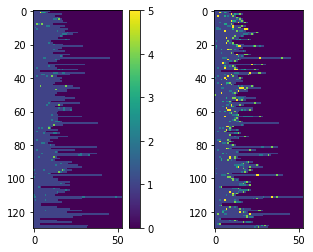

epoch:  128
0.000 perplexity: 1.155 speed: 298 wps
0.077 perplexity: 1.212 speed: 298 wps
0.154 perplexity: 1.213 speed: 300 wps
0.231 perplexity: 1.200 speed: 301 wps
0.308 perplexity: 1.200 speed: 302 wps
0.385 perplexity: 1.197 speed: 302 wps
0.462 perplexity: 1.196 speed: 302 wps
0.538 perplexity: 1.184 speed: 303 wps
0.615 perplexity: 1.176 speed: 303 wps
0.692 perplexity: 1.178 speed: 303 wps
0.769 perplexity: 1.175 speed: 303 wps
0.846 perplexity: 1.174 speed: 303 wps
0.923 perplexity: 1.174 speed: 302 wps


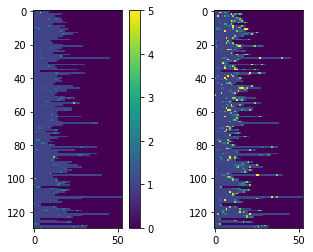

epoch:  129
0.000 perplexity: 1.164 speed: 302 wps
0.077 perplexity: 1.188 speed: 303 wps
0.154 perplexity: 1.189 speed: 303 wps
0.231 perplexity: 1.188 speed: 304 wps
0.308 perplexity: 1.188 speed: 303 wps
0.385 perplexity: 1.187 speed: 303 wps
0.462 perplexity: 1.185 speed: 303 wps
0.538 perplexity: 1.173 speed: 303 wps
0.615 perplexity: 1.168 speed: 303 wps
0.692 perplexity: 1.174 speed: 304 wps
0.769 perplexity: 1.173 speed: 304 wps
0.846 perplexity: 1.174 speed: 303 wps
0.923 perplexity: 1.172 speed: 303 wps


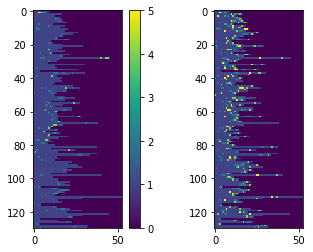

epoch:  130
0.000 perplexity: 1.146 speed: 299 wps
0.077 perplexity: 1.188 speed: 302 wps
0.154 perplexity: 1.186 speed: 303 wps
0.231 perplexity: 1.177 speed: 303 wps
0.308 perplexity: 1.183 speed: 303 wps
0.385 perplexity: 1.181 speed: 304 wps
0.462 perplexity: 1.183 speed: 303 wps
0.538 perplexity: 1.175 speed: 303 wps
0.615 perplexity: 1.167 speed: 304 wps
0.692 perplexity: 1.172 speed: 304 wps
0.769 perplexity: 1.171 speed: 304 wps
0.846 perplexity: 1.170 speed: 304 wps
0.923 perplexity: 1.169 speed: 304 wps


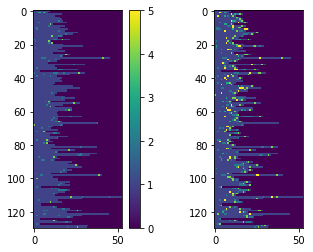

epoch:  131
0.000 perplexity: 1.134 speed: 299 wps
0.077 perplexity: 1.180 speed: 304 wps
0.154 perplexity: 1.189 speed: 303 wps
0.231 perplexity: 1.186 speed: 303 wps
0.308 perplexity: 1.182 speed: 304 wps
0.385 perplexity: 1.181 speed: 304 wps
0.462 perplexity: 1.187 speed: 304 wps
0.538 perplexity: 1.189 speed: 294 wps
0.615 perplexity: 1.179 speed: 280 wps
0.692 perplexity: 1.182 speed: 268 wps
0.769 perplexity: 1.177 speed: 260 wps
0.846 perplexity: 1.177 speed: 253 wps
0.923 perplexity: 1.173 speed: 250 wps


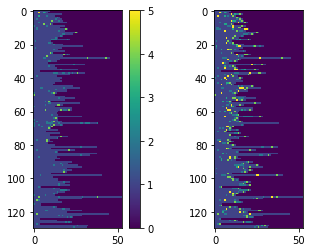

epoch:  132
0.000 perplexity: 1.126 speed: 280 wps
0.077 perplexity: 1.169 speed: 287 wps
0.154 perplexity: 1.173 speed: 292 wps
0.231 perplexity: 1.172 speed: 286 wps
0.308 perplexity: 1.177 speed: 288 wps
0.385 perplexity: 1.179 speed: 290 wps
0.462 perplexity: 1.176 speed: 292 wps
0.538 perplexity: 1.167 speed: 294 wps
0.615 perplexity: 1.160 speed: 295 wps
0.692 perplexity: 1.166 speed: 296 wps
0.769 perplexity: 1.163 speed: 297 wps
0.846 perplexity: 1.161 speed: 297 wps
0.923 perplexity: 1.160 speed: 298 wps


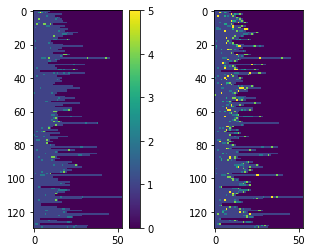

epoch:  133
0.000 perplexity: 1.126 speed: 297 wps
0.077 perplexity: 1.167 speed: 301 wps
0.154 perplexity: 1.175 speed: 302 wps
0.231 perplexity: 1.175 speed: 302 wps
0.308 perplexity: 1.191 speed: 302 wps
0.385 perplexity: 1.196 speed: 302 wps
0.462 perplexity: 1.195 speed: 303 wps
0.538 perplexity: 1.182 speed: 303 wps
0.615 perplexity: 1.170 speed: 303 wps
0.692 perplexity: 1.174 speed: 303 wps
0.769 perplexity: 1.168 speed: 303 wps
0.846 perplexity: 1.167 speed: 303 wps
0.923 perplexity: 1.167 speed: 304 wps


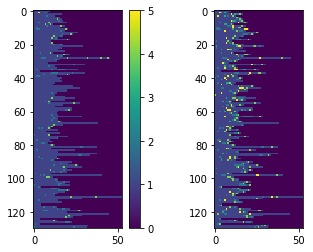

epoch:  134
0.000 perplexity: 1.146 speed: 297 wps
0.077 perplexity: 1.175 speed: 303 wps
0.154 perplexity: 1.175 speed: 303 wps
0.231 perplexity: 1.165 speed: 304 wps
0.308 perplexity: 1.164 speed: 304 wps
0.385 perplexity: 1.168 speed: 303 wps
0.462 perplexity: 1.168 speed: 304 wps
0.538 perplexity: 1.157 speed: 304 wps
0.615 perplexity: 1.148 speed: 304 wps
0.692 perplexity: 1.158 speed: 304 wps
0.769 perplexity: 1.156 speed: 304 wps
0.846 perplexity: 1.158 speed: 304 wps
0.923 perplexity: 1.158 speed: 304 wps


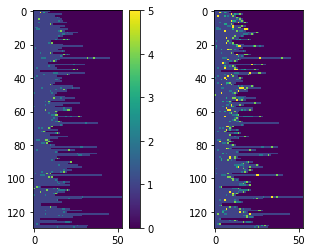

epoch:  135
0.000 perplexity: 1.162 speed: 299 wps
0.077 perplexity: 1.196 speed: 304 wps
0.154 perplexity: 1.200 speed: 301 wps
0.231 perplexity: 1.187 speed: 259 wps
0.308 perplexity: 1.183 speed: 244 wps
0.385 perplexity: 1.182 speed: 247 wps
0.462 perplexity: 1.185 speed: 253 wps
0.538 perplexity: 1.175 speed: 255 wps
0.615 perplexity: 1.165 speed: 254 wps
0.692 perplexity: 1.171 speed: 257 wps
0.769 perplexity: 1.166 speed: 261 wps
0.846 perplexity: 1.166 speed: 264 wps
0.923 perplexity: 1.164 speed: 266 wps


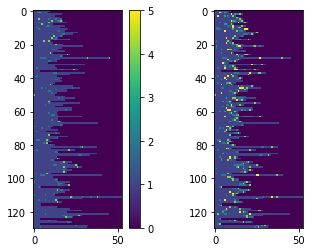

epoch:  136
0.000 perplexity: 1.141 speed: 297 wps
0.077 perplexity: 1.156 speed: 303 wps
0.154 perplexity: 1.167 speed: 304 wps
0.231 perplexity: 1.164 speed: 304 wps
0.308 perplexity: 1.165 speed: 305 wps
0.385 perplexity: 1.162 speed: 304 wps
0.462 perplexity: 1.168 speed: 304 wps
0.538 perplexity: 1.163 speed: 305 wps
0.615 perplexity: 1.153 speed: 304 wps
0.692 perplexity: 1.155 speed: 304 wps
0.769 perplexity: 1.155 speed: 300 wps
0.846 perplexity: 1.155 speed: 299 wps
0.923 perplexity: 1.154 speed: 299 wps


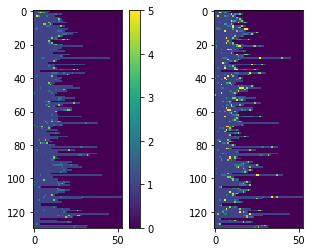

epoch:  137
0.000 perplexity: 1.116 speed: 300 wps
0.077 perplexity: 1.161 speed: 304 wps
0.154 perplexity: 1.169 speed: 304 wps
0.231 perplexity: 1.163 speed: 303 wps
0.308 perplexity: 1.162 speed: 282 wps
0.385 perplexity: 1.162 speed: 273 wps
0.462 perplexity: 1.163 speed: 270 wps
0.538 perplexity: 1.152 speed: 253 wps
0.615 perplexity: 1.144 speed: 255 wps
0.692 perplexity: 1.148 speed: 253 wps
0.769 perplexity: 1.142 speed: 250 wps
0.846 perplexity: 1.140 speed: 246 wps
0.923 perplexity: 1.140 speed: 247 wps


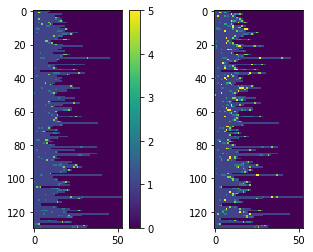

epoch:  138
0.000 perplexity: 1.118 speed: 296 wps
0.077 perplexity: 1.160 speed: 304 wps
0.154 perplexity: 1.169 speed: 305 wps
0.231 perplexity: 1.166 speed: 306 wps
0.308 perplexity: 1.169 speed: 305 wps
0.385 perplexity: 1.163 speed: 306 wps
0.462 perplexity: 1.163 speed: 306 wps
0.538 perplexity: 1.153 speed: 306 wps
0.615 perplexity: 1.144 speed: 307 wps
0.692 perplexity: 1.150 speed: 302 wps
0.769 perplexity: 1.146 speed: 288 wps
0.846 perplexity: 1.146 speed: 289 wps
0.923 perplexity: 1.146 speed: 289 wps


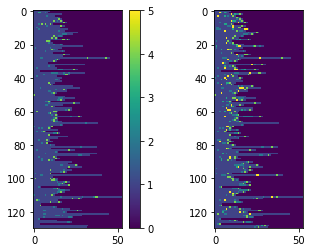

epoch:  139
0.000 perplexity: 1.107 speed: 294 wps
0.077 perplexity: 1.154 speed: 281 wps
0.154 perplexity: 1.163 speed: 291 wps
0.231 perplexity: 1.172 speed: 295 wps
0.308 perplexity: 1.165 speed: 297 wps
0.385 perplexity: 1.161 speed: 286 wps
0.462 perplexity: 1.159 speed: 283 wps
0.538 perplexity: 1.149 speed: 283 wps
0.615 perplexity: 1.141 speed: 286 wps
0.692 perplexity: 1.146 speed: 289 wps
0.769 perplexity: 1.145 speed: 291 wps
0.846 perplexity: 1.144 speed: 292 wps
0.923 perplexity: 1.143 speed: 294 wps


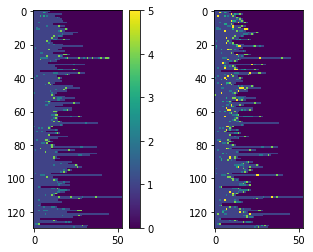

epoch:  140
0.000 perplexity: 1.117 speed: 309 wps
0.077 perplexity: 1.158 speed: 312 wps
0.154 perplexity: 1.164 speed: 312 wps
0.231 perplexity: 1.156 speed: 313 wps
0.308 perplexity: 1.156 speed: 313 wps
0.385 perplexity: 1.151 speed: 313 wps
0.462 perplexity: 1.158 speed: 312 wps
0.538 perplexity: 1.153 speed: 312 wps
0.615 perplexity: 1.148 speed: 312 wps
0.692 perplexity: 1.151 speed: 310 wps
0.769 perplexity: 1.151 speed: 295 wps
0.846 perplexity: 1.152 speed: 285 wps
0.923 perplexity: 1.149 speed: 287 wps


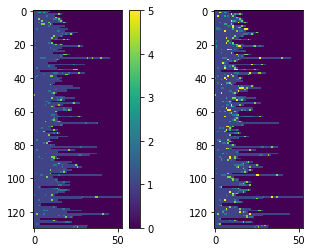

epoch:  141
0.000 perplexity: 1.142 speed: 246 wps
0.077 perplexity: 1.166 speed: 237 wps
0.154 perplexity: 1.163 speed: 220 wps
0.231 perplexity: 1.152 speed: 216 wps
0.308 perplexity: 1.151 speed: 230 wps
0.385 perplexity: 1.147 speed: 242 wps
0.462 perplexity: 1.152 speed: 243 wps
0.538 perplexity: 1.143 speed: 248 wps
0.615 perplexity: 1.136 speed: 254 wps
0.692 perplexity: 1.140 speed: 255 wps
0.769 perplexity: 1.139 speed: 256 wps
0.846 perplexity: 1.142 speed: 258 wps
0.923 perplexity: 1.142 speed: 260 wps


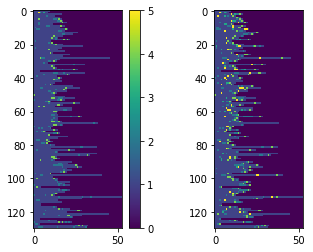

epoch:  142
0.000 perplexity: 1.136 speed: 240 wps
0.077 perplexity: 1.164 speed: 246 wps
0.154 perplexity: 1.172 speed: 234 wps
0.231 perplexity: 1.160 speed: 223 wps
0.308 perplexity: 1.159 speed: 230 wps
0.385 perplexity: 1.161 speed: 239 wps
0.462 perplexity: 1.181 speed: 247 wps
0.538 perplexity: 1.172 speed: 248 wps
0.615 perplexity: 1.163 speed: 246 wps
0.692 perplexity: 1.166 speed: 243 wps
0.769 perplexity: 1.168 speed: 241 wps
0.846 perplexity: 1.168 speed: 237 wps
0.923 perplexity: 1.164 speed: 233 wps


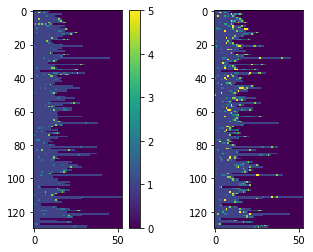

epoch:  143
0.000 perplexity: 1.103 speed: 195 wps
0.077 perplexity: 1.157 speed: 214 wps
0.154 perplexity: 1.162 speed: 239 wps
0.231 perplexity: 1.154 speed: 244 wps
0.308 perplexity: 1.159 speed: 247 wps
0.385 perplexity: 1.168 speed: 254 wps
0.462 perplexity: 1.178 speed: 255 wps
0.538 perplexity: 1.166 speed: 253 wps
0.615 perplexity: 1.158 speed: 253 wps
0.692 perplexity: 1.162 speed: 258 wps
0.769 perplexity: 1.158 speed: 259 wps
0.846 perplexity: 1.157 speed: 258 wps
0.923 perplexity: 1.154 speed: 256 wps


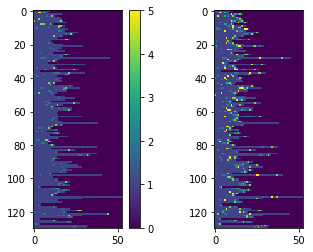

epoch:  144
0.000 perplexity: 1.130 speed: 243 wps
0.077 perplexity: 1.167 speed: 231 wps
0.154 perplexity: 1.167 speed: 223 wps
0.231 perplexity: 1.170 speed: 226 wps
0.308 perplexity: 1.167 speed: 221 wps
0.385 perplexity: 1.164 speed: 229 wps
0.462 perplexity: 1.163 speed: 229 wps
0.538 perplexity: 1.157 speed: 230 wps
0.615 perplexity: 1.149 speed: 237 wps
0.692 perplexity: 1.154 speed: 244 wps
0.769 perplexity: 1.151 speed: 249 wps
0.846 perplexity: 1.149 speed: 253 wps
0.923 perplexity: 1.148 speed: 257 wps


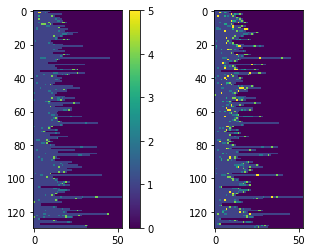

epoch:  145
0.000 perplexity: 1.129 speed: 311 wps
0.077 perplexity: 1.141 speed: 313 wps
0.154 perplexity: 1.152 speed: 314 wps
0.231 perplexity: 1.147 speed: 315 wps
0.308 perplexity: 1.152 speed: 315 wps
0.385 perplexity: 1.147 speed: 316 wps
0.462 perplexity: 1.151 speed: 316 wps
0.538 perplexity: 1.142 speed: 316 wps
0.615 perplexity: 1.137 speed: 315 wps
0.692 perplexity: 1.141 speed: 316 wps
0.769 perplexity: 1.142 speed: 316 wps
0.846 perplexity: 1.143 speed: 316 wps
0.923 perplexity: 1.141 speed: 316 wps


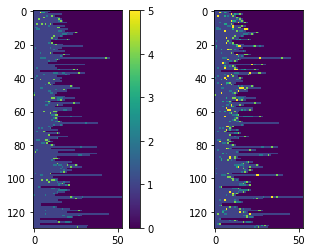

epoch:  146
0.000 perplexity: 1.090 speed: 186 wps
0.077 perplexity: 1.148 speed: 240 wps
0.154 perplexity: 1.157 speed: 266 wps
0.231 perplexity: 1.148 speed: 279 wps
0.308 perplexity: 1.147 speed: 287 wps
0.385 perplexity: 1.144 speed: 293 wps
0.462 perplexity: 1.147 speed: 297 wps
0.538 perplexity: 1.143 speed: 295 wps
0.615 perplexity: 1.135 speed: 297 wps
0.692 perplexity: 1.143 speed: 298 wps
0.769 perplexity: 1.138 speed: 300 wps
0.846 perplexity: 1.139 speed: 302 wps
0.923 perplexity: 1.139 speed: 297 wps


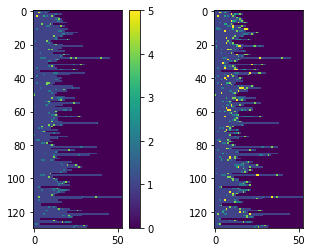

epoch:  147
0.000 perplexity: 1.113 speed: 240 wps
0.077 perplexity: 1.185 speed: 281 wps
0.154 perplexity: 1.181 speed: 289 wps
0.231 perplexity: 1.161 speed: 259 wps
0.308 perplexity: 1.158 speed: 249 wps
0.385 perplexity: 1.156 speed: 257 wps
0.462 perplexity: 1.154 speed: 249 wps
0.538 perplexity: 1.146 speed: 256 wps
0.615 perplexity: 1.138 speed: 251 wps
0.692 perplexity: 1.145 speed: 251 wps
0.769 perplexity: 1.142 speed: 256 wps
0.846 perplexity: 1.140 speed: 261 wps
0.923 perplexity: 1.137 speed: 265 wps


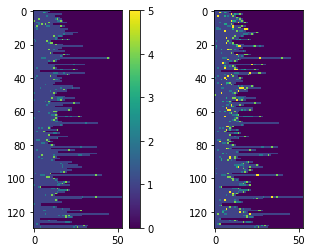

epoch:  148
0.000 perplexity: 1.116 speed: 313 wps
0.077 perplexity: 1.182 speed: 317 wps
0.154 perplexity: 1.187 speed: 319 wps
0.231 perplexity: 1.183 speed: 320 wps
0.308 perplexity: 1.175 speed: 320 wps
0.385 perplexity: 1.171 speed: 321 wps
0.462 perplexity: 1.169 speed: 321 wps
0.538 perplexity: 1.158 speed: 320 wps
0.615 perplexity: 1.150 speed: 321 wps
0.692 perplexity: 1.156 speed: 321 wps
0.769 perplexity: 1.151 speed: 321 wps
0.846 perplexity: 1.150 speed: 320 wps
0.923 perplexity: 1.148 speed: 320 wps


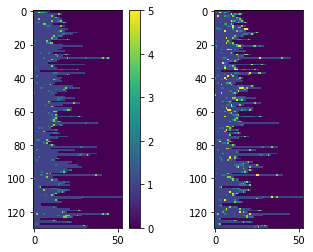

epoch:  149
0.000 perplexity: 1.097 speed: 313 wps
0.077 perplexity: 1.145 speed: 319 wps
0.154 perplexity: 1.154 speed: 319 wps
0.231 perplexity: 1.147 speed: 319 wps
0.308 perplexity: 1.147 speed: 319 wps
0.385 perplexity: 1.144 speed: 319 wps
0.462 perplexity: 1.148 speed: 319 wps
0.538 perplexity: 1.147 speed: 319 wps
0.615 perplexity: 1.140 speed: 319 wps
0.692 perplexity: 1.144 speed: 319 wps
0.769 perplexity: 1.142 speed: 319 wps
0.846 perplexity: 1.142 speed: 319 wps
0.923 perplexity: 1.140 speed: 319 wps


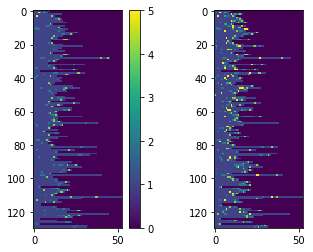

epoch:  150
0.000 perplexity: 1.100 speed: 314 wps
0.077 perplexity: 1.149 speed: 319 wps
0.154 perplexity: 1.145 speed: 320 wps
0.231 perplexity: 1.136 speed: 319 wps
0.308 perplexity: 1.134 speed: 320 wps
0.385 perplexity: 1.134 speed: 320 wps
0.462 perplexity: 1.132 speed: 320 wps
0.538 perplexity: 1.123 speed: 320 wps
0.615 perplexity: 1.116 speed: 320 wps
0.692 perplexity: 1.124 speed: 320 wps
0.769 perplexity: 1.121 speed: 320 wps
0.846 perplexity: 1.122 speed: 320 wps
0.923 perplexity: 1.122 speed: 320 wps


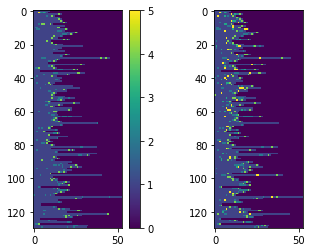

epoch:  151
0.000 perplexity: 1.122 speed: 311 wps
0.077 perplexity: 1.139 speed: 318 wps
0.154 perplexity: 1.156 speed: 318 wps
0.231 perplexity: 1.149 speed: 319 wps
0.308 perplexity: 1.150 speed: 320 wps
0.385 perplexity: 1.152 speed: 320 wps
0.462 perplexity: 1.152 speed: 320 wps
0.538 perplexity: 1.143 speed: 320 wps
0.615 perplexity: 1.137 speed: 320 wps
0.692 perplexity: 1.141 speed: 321 wps
0.769 perplexity: 1.137 speed: 319 wps
0.846 perplexity: 1.137 speed: 317 wps
0.923 perplexity: 1.136 speed: 316 wps


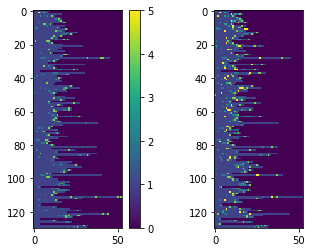

epoch:  152
0.000 perplexity: 1.101 speed: 308 wps
0.077 perplexity: 1.143 speed: 318 wps
0.154 perplexity: 1.144 speed: 319 wps
0.231 perplexity: 1.133 speed: 319 wps
0.308 perplexity: 1.132 speed: 320 wps
0.385 perplexity: 1.130 speed: 319 wps
0.462 perplexity: 1.135 speed: 320 wps
0.538 perplexity: 1.133 speed: 320 wps
0.615 perplexity: 1.130 speed: 320 wps
0.692 perplexity: 1.134 speed: 320 wps
0.769 perplexity: 1.131 speed: 320 wps
0.846 perplexity: 1.134 speed: 320 wps
0.923 perplexity: 1.131 speed: 320 wps


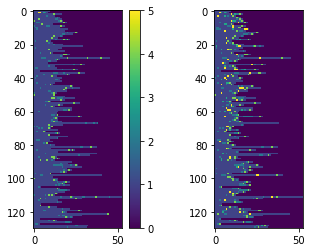

epoch:  153
0.000 perplexity: 1.128 speed: 312 wps
0.077 perplexity: 1.149 speed: 318 wps
0.154 perplexity: 1.158 speed: 318 wps
0.231 perplexity: 1.145 speed: 318 wps
0.308 perplexity: 1.145 speed: 319 wps
0.385 perplexity: 1.143 speed: 318 wps
0.462 perplexity: 1.141 speed: 319 wps
0.538 perplexity: 1.141 speed: 319 wps
0.615 perplexity: 1.135 speed: 319 wps
0.692 perplexity: 1.139 speed: 319 wps
0.769 perplexity: 1.137 speed: 320 wps
0.846 perplexity: 1.137 speed: 320 wps
0.923 perplexity: 1.136 speed: 320 wps


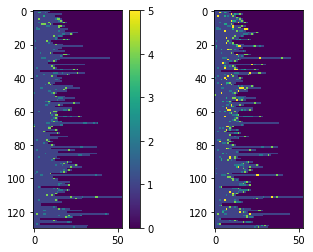

epoch:  154
0.000 perplexity: 1.102 speed: 314 wps
0.077 perplexity: 1.143 speed: 320 wps
0.154 perplexity: 1.155 speed: 321 wps
0.231 perplexity: 1.157 speed: 322 wps
0.308 perplexity: 1.156 speed: 322 wps
0.385 perplexity: 1.152 speed: 323 wps
0.462 perplexity: 1.153 speed: 322 wps
0.538 perplexity: 1.146 speed: 323 wps
0.615 perplexity: 1.139 speed: 322 wps
0.692 perplexity: 1.140 speed: 323 wps
0.769 perplexity: 1.134 speed: 323 wps
0.846 perplexity: 1.134 speed: 323 wps
0.923 perplexity: 1.134 speed: 323 wps


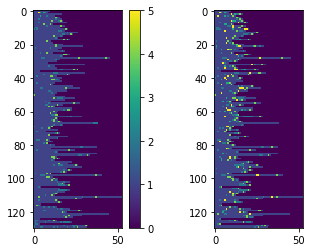

epoch:  155
0.000 perplexity: 1.214 speed: 311 wps
0.077 perplexity: 1.258 speed: 319 wps
0.154 perplexity: 1.235 speed: 320 wps
0.231 perplexity: 1.215 speed: 321 wps
0.308 perplexity: 1.207 speed: 321 wps
0.385 perplexity: 1.197 speed: 321 wps
0.462 perplexity: 1.194 speed: 321 wps
0.538 perplexity: 1.179 speed: 321 wps
0.615 perplexity: 1.169 speed: 321 wps
0.692 perplexity: 1.173 speed: 321 wps
0.769 perplexity: 1.166 speed: 321 wps
0.846 perplexity: 1.163 speed: 322 wps
0.923 perplexity: 1.157 speed: 322 wps


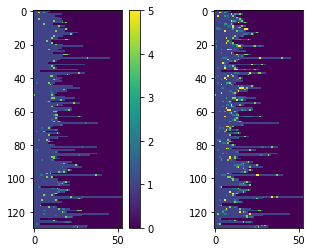

epoch:  156
0.000 perplexity: 1.116 speed: 310 wps
0.077 perplexity: 1.155 speed: 317 wps
0.154 perplexity: 1.161 speed: 318 wps
0.231 perplexity: 1.154 speed: 320 wps
0.308 perplexity: 1.151 speed: 320 wps
0.385 perplexity: 1.147 speed: 320 wps
0.462 perplexity: 1.150 speed: 320 wps
0.538 perplexity: 1.141 speed: 321 wps
0.615 perplexity: 1.135 speed: 321 wps
0.692 perplexity: 1.141 speed: 321 wps
0.769 perplexity: 1.138 speed: 321 wps
0.846 perplexity: 1.139 speed: 321 wps
0.923 perplexity: 1.139 speed: 322 wps


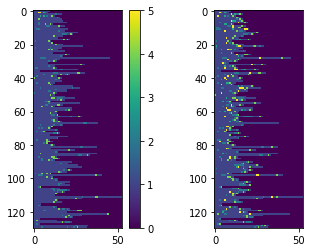

epoch:  157
0.000 perplexity: 1.133 speed: 316 wps
0.077 perplexity: 1.148 speed: 321 wps
0.154 perplexity: 1.156 speed: 323 wps
0.231 perplexity: 1.145 speed: 323 wps
0.308 perplexity: 1.142 speed: 313 wps
0.385 perplexity: 1.138 speed: 315 wps
0.462 perplexity: 1.139 speed: 315 wps
0.538 perplexity: 1.130 speed: 316 wps
0.615 perplexity: 1.123 speed: 317 wps
0.692 perplexity: 1.128 speed: 317 wps
0.769 perplexity: 1.129 speed: 318 wps
0.846 perplexity: 1.129 speed: 319 wps
0.923 perplexity: 1.128 speed: 319 wps


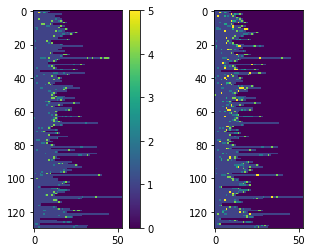

epoch:  158
0.000 perplexity: 1.113 speed: 316 wps
0.077 perplexity: 1.154 speed: 322 wps
0.154 perplexity: 1.158 speed: 323 wps
0.231 perplexity: 1.148 speed: 323 wps
0.308 perplexity: 1.143 speed: 324 wps
0.385 perplexity: 1.145 speed: 324 wps
0.462 perplexity: 1.143 speed: 324 wps
0.538 perplexity: 1.136 speed: 324 wps
0.615 perplexity: 1.128 speed: 324 wps
0.692 perplexity: 1.138 speed: 324 wps
0.769 perplexity: 1.136 speed: 324 wps
0.846 perplexity: 1.136 speed: 324 wps
0.923 perplexity: 1.134 speed: 324 wps


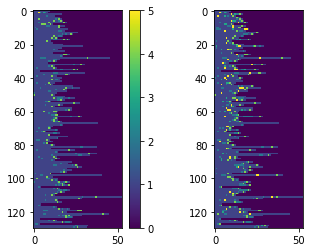

epoch:  159
0.000 perplexity: 1.096 speed: 316 wps
0.077 perplexity: 1.122 speed: 323 wps
0.154 perplexity: 1.140 speed: 321 wps
0.231 perplexity: 1.132 speed: 322 wps
0.308 perplexity: 1.133 speed: 322 wps
0.385 perplexity: 1.134 speed: 323 wps
0.462 perplexity: 1.134 speed: 323 wps
0.538 perplexity: 1.125 speed: 323 wps
0.615 perplexity: 1.119 speed: 323 wps
0.692 perplexity: 1.123 speed: 324 wps
0.769 perplexity: 1.122 speed: 324 wps
0.846 perplexity: 1.121 speed: 324 wps
0.923 perplexity: 1.121 speed: 324 wps


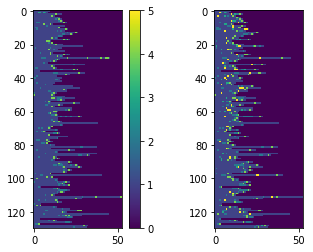

epoch:  160
0.000 perplexity: 1.117 speed: 318 wps
0.077 perplexity: 1.141 speed: 322 wps
0.154 perplexity: 1.150 speed: 323 wps
0.231 perplexity: 1.141 speed: 322 wps
0.308 perplexity: 1.137 speed: 323 wps
0.385 perplexity: 1.133 speed: 323 wps
0.462 perplexity: 1.136 speed: 323 wps
0.538 perplexity: 1.127 speed: 323 wps
0.615 perplexity: 1.120 speed: 323 wps
0.692 perplexity: 1.126 speed: 323 wps
0.769 perplexity: 1.123 speed: 323 wps
0.846 perplexity: 1.124 speed: 323 wps
0.923 perplexity: 1.122 speed: 323 wps


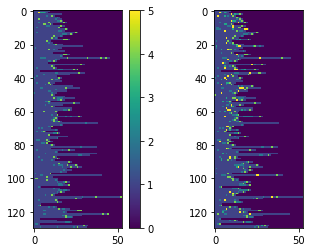

epoch:  161
0.000 perplexity: 1.092 speed: 316 wps
0.077 perplexity: 1.122 speed: 322 wps
0.154 perplexity: 1.133 speed: 323 wps
0.231 perplexity: 1.125 speed: 304 wps
0.308 perplexity: 1.123 speed: 271 wps
0.385 perplexity: 1.126 speed: 254 wps
0.462 perplexity: 1.129 speed: 244 wps
0.538 perplexity: 1.124 speed: 244 wps
0.615 perplexity: 1.118 speed: 249 wps
0.692 perplexity: 1.125 speed: 252 wps
0.769 perplexity: 1.128 speed: 258 wps
0.846 perplexity: 1.129 speed: 264 wps
0.923 perplexity: 1.128 speed: 269 wps


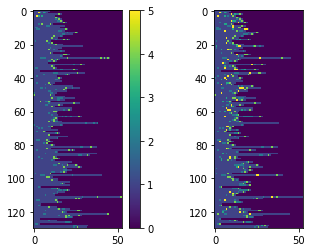

epoch:  162
0.000 perplexity: 1.106 speed: 327 wps
0.077 perplexity: 1.158 speed: 333 wps
0.154 perplexity: 1.156 speed: 335 wps
0.231 perplexity: 1.148 speed: 335 wps
0.308 perplexity: 1.145 speed: 335 wps
0.385 perplexity: 1.145 speed: 335 wps
0.462 perplexity: 1.145 speed: 335 wps
0.538 perplexity: 1.135 speed: 335 wps
0.615 perplexity: 1.128 speed: 335 wps
0.692 perplexity: 1.135 speed: 330 wps
0.769 perplexity: 1.131 speed: 331 wps
0.846 perplexity: 1.134 speed: 330 wps
0.923 perplexity: 1.131 speed: 331 wps


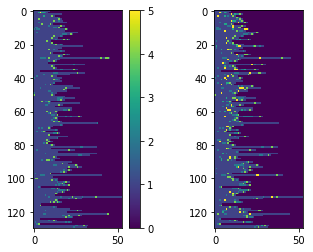

epoch:  163
0.000 perplexity: 1.122 speed: 330 wps
0.077 perplexity: 1.146 speed: 336 wps
0.154 perplexity: 1.146 speed: 338 wps
0.231 perplexity: 1.132 speed: 338 wps
0.308 perplexity: 1.130 speed: 337 wps
0.385 perplexity: 1.127 speed: 337 wps
0.462 perplexity: 1.126 speed: 337 wps
0.538 perplexity: 1.119 speed: 337 wps
0.615 perplexity: 1.114 speed: 337 wps
0.692 perplexity: 1.120 speed: 337 wps
0.769 perplexity: 1.116 speed: 337 wps
0.846 perplexity: 1.115 speed: 337 wps
0.923 perplexity: 1.112 speed: 337 wps


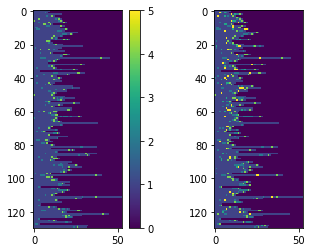

epoch:  164
0.000 perplexity: 1.101 speed: 326 wps
0.077 perplexity: 1.129 speed: 336 wps
0.154 perplexity: 1.129 speed: 337 wps
0.231 perplexity: 1.120 speed: 337 wps
0.308 perplexity: 1.121 speed: 338 wps
0.385 perplexity: 1.122 speed: 337 wps
0.462 perplexity: 1.126 speed: 337 wps
0.538 perplexity: 1.119 speed: 338 wps
0.615 perplexity: 1.115 speed: 338 wps
0.692 perplexity: 1.120 speed: 338 wps
0.769 perplexity: 1.117 speed: 338 wps
0.846 perplexity: 1.120 speed: 338 wps
0.923 perplexity: 1.118 speed: 338 wps


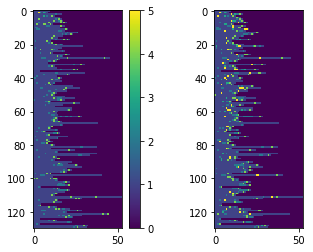

epoch:  165
0.000 perplexity: 1.103 speed: 327 wps
0.077 perplexity: 1.123 speed: 332 wps
0.154 perplexity: 1.136 speed: 334 wps
0.231 perplexity: 1.154 speed: 336 wps
0.308 perplexity: 1.159 speed: 337 wps
0.385 perplexity: 1.159 speed: 337 wps
0.462 perplexity: 1.160 speed: 337 wps
0.538 perplexity: 1.149 speed: 337 wps
0.615 perplexity: 1.140 speed: 337 wps
0.692 perplexity: 1.143 speed: 338 wps
0.769 perplexity: 1.139 speed: 338 wps
0.846 perplexity: 1.141 speed: 338 wps
0.923 perplexity: 1.138 speed: 338 wps


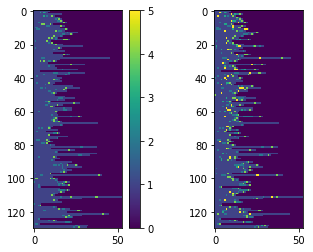

epoch:  166
0.000 perplexity: 1.128 speed: 330 wps
0.077 perplexity: 1.149 speed: 337 wps
0.154 perplexity: 1.150 speed: 337 wps
0.231 perplexity: 1.136 speed: 336 wps
0.308 perplexity: 1.137 speed: 337 wps
0.385 perplexity: 1.136 speed: 337 wps
0.462 perplexity: 1.139 speed: 337 wps
0.538 perplexity: 1.132 speed: 337 wps
0.615 perplexity: 1.125 speed: 337 wps
0.692 perplexity: 1.128 speed: 337 wps
0.769 perplexity: 1.123 speed: 337 wps
0.846 perplexity: 1.124 speed: 337 wps
0.923 perplexity: 1.123 speed: 337 wps


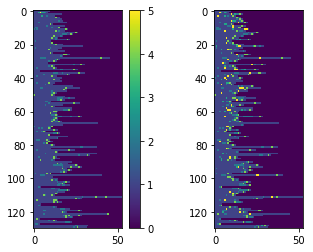

epoch:  167
0.000 perplexity: 1.082 speed: 325 wps
0.077 perplexity: 1.112 speed: 334 wps
0.154 perplexity: 1.132 speed: 335 wps
0.231 perplexity: 1.121 speed: 336 wps
0.308 perplexity: 1.121 speed: 336 wps
0.385 perplexity: 1.121 speed: 336 wps
0.462 perplexity: 1.123 speed: 336 wps
0.538 perplexity: 1.117 speed: 336 wps
0.615 perplexity: 1.114 speed: 336 wps
0.692 perplexity: 1.119 speed: 336 wps
0.769 perplexity: 1.116 speed: 336 wps
0.846 perplexity: 1.116 speed: 336 wps
0.923 perplexity: 1.116 speed: 336 wps


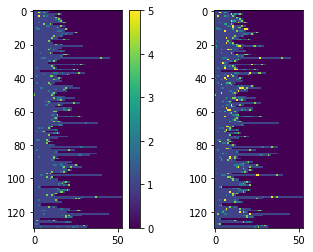

epoch:  168
0.000 perplexity: 1.185 speed: 326 wps
0.077 perplexity: 1.225 speed: 334 wps
0.154 perplexity: 1.195 speed: 335 wps
0.231 perplexity: 1.174 speed: 336 wps
0.308 perplexity: 1.166 speed: 336 wps
0.385 perplexity: 1.160 speed: 336 wps
0.462 perplexity: 1.159 speed: 330 wps
0.538 perplexity: 1.145 speed: 330 wps
0.615 perplexity: 1.136 speed: 329 wps
0.692 perplexity: 1.139 speed: 330 wps
0.769 perplexity: 1.135 speed: 331 wps
0.846 perplexity: 1.133 speed: 331 wps
0.923 perplexity: 1.129 speed: 332 wps


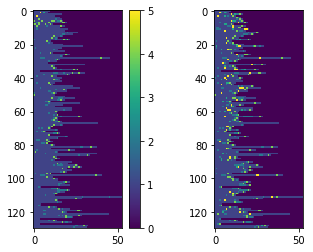

epoch:  169
0.000 perplexity: 1.083 speed: 330 wps
0.077 perplexity: 1.111 speed: 333 wps
0.154 perplexity: 1.128 speed: 334 wps
0.231 perplexity: 1.126 speed: 334 wps
0.308 perplexity: 1.129 speed: 334 wps
0.385 perplexity: 1.124 speed: 335 wps
0.462 perplexity: 1.124 speed: 335 wps
0.538 perplexity: 1.118 speed: 335 wps
0.615 perplexity: 1.115 speed: 335 wps
0.692 perplexity: 1.118 speed: 336 wps
0.769 perplexity: 1.114 speed: 336 wps
0.846 perplexity: 1.113 speed: 336 wps
0.923 perplexity: 1.114 speed: 336 wps


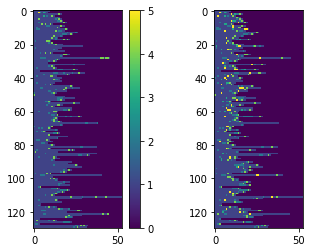

epoch:  170
0.000 perplexity: 1.112 speed: 330 wps
0.077 perplexity: 1.138 speed: 333 wps
0.154 perplexity: 1.144 speed: 333 wps
0.231 perplexity: 1.135 speed: 333 wps
0.308 perplexity: 1.135 speed: 334 wps
0.385 perplexity: 1.137 speed: 334 wps
0.462 perplexity: 1.136 speed: 334 wps
0.538 perplexity: 1.126 speed: 335 wps
0.615 perplexity: 1.119 speed: 335 wps
0.692 perplexity: 1.124 speed: 335 wps
0.769 perplexity: 1.119 speed: 335 wps
0.846 perplexity: 1.121 speed: 335 wps
0.923 perplexity: 1.119 speed: 335 wps


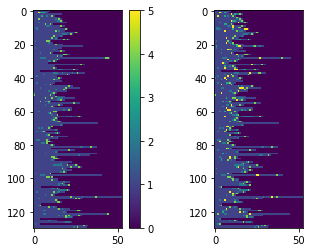

epoch:  171
0.000 perplexity: 1.082 speed: 324 wps
0.077 perplexity: 1.116 speed: 334 wps
0.154 perplexity: 1.126 speed: 332 wps
0.231 perplexity: 1.119 speed: 333 wps
0.308 perplexity: 1.116 speed: 334 wps
0.385 perplexity: 1.119 speed: 334 wps
0.462 perplexity: 1.123 speed: 334 wps
0.538 perplexity: 1.116 speed: 335 wps
0.615 perplexity: 1.110 speed: 334 wps
0.692 perplexity: 1.114 speed: 334 wps
0.769 perplexity: 1.109 speed: 334 wps
0.846 perplexity: 1.111 speed: 334 wps
0.923 perplexity: 1.108 speed: 334 wps


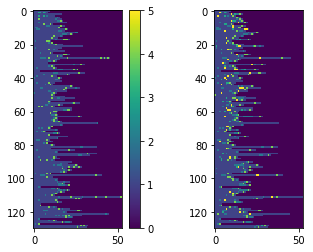

epoch:  172
0.000 perplexity: 1.106 speed: 328 wps
0.077 perplexity: 1.132 speed: 334 wps
0.154 perplexity: 1.139 speed: 333 wps
0.231 perplexity: 1.133 speed: 334 wps
0.308 perplexity: 1.131 speed: 334 wps
0.385 perplexity: 1.128 speed: 334 wps
0.462 perplexity: 1.129 speed: 335 wps
0.538 perplexity: 1.120 speed: 335 wps
0.615 perplexity: 1.114 speed: 335 wps
0.692 perplexity: 1.122 speed: 335 wps
0.769 perplexity: 1.118 speed: 335 wps
0.846 perplexity: 1.116 speed: 335 wps
0.923 perplexity: 1.114 speed: 335 wps


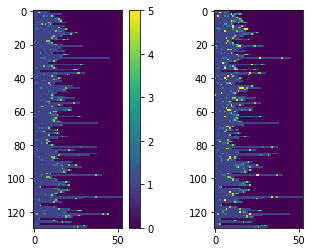

epoch:  173
0.000 perplexity: 1.082 speed: 324 wps
0.077 perplexity: 1.102 speed: 332 wps
0.154 perplexity: 1.121 speed: 332 wps
0.231 perplexity: 1.114 speed: 333 wps
0.308 perplexity: 1.115 speed: 332 wps
0.385 perplexity: 1.116 speed: 333 wps
0.462 perplexity: 1.119 speed: 334 wps
0.538 perplexity: 1.110 speed: 334 wps
0.615 perplexity: 1.106 speed: 334 wps
0.692 perplexity: 1.111 speed: 334 wps
0.769 perplexity: 1.107 speed: 334 wps
0.846 perplexity: 1.109 speed: 334 wps
0.923 perplexity: 1.108 speed: 334 wps


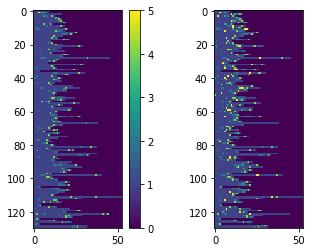

epoch:  174
0.000 perplexity: 1.086 speed: 325 wps
0.077 perplexity: 1.121 speed: 331 wps
0.154 perplexity: 1.121 speed: 329 wps
0.231 perplexity: 1.138 speed: 320 wps
0.308 perplexity: 1.136 speed: 321 wps
0.385 perplexity: 1.137 speed: 323 wps
0.462 perplexity: 1.135 speed: 325 wps
0.538 perplexity: 1.125 speed: 326 wps
0.615 perplexity: 1.119 speed: 327 wps
0.692 perplexity: 1.126 speed: 328 wps
0.769 perplexity: 1.121 speed: 328 wps
0.846 perplexity: 1.121 speed: 328 wps
0.923 perplexity: 1.120 speed: 328 wps


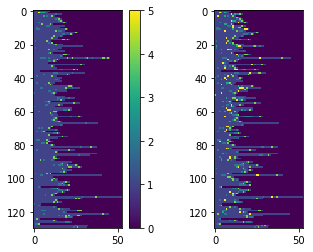

epoch:  175
0.000 perplexity: 1.072 speed: 321 wps
0.077 perplexity: 1.111 speed: 329 wps
0.154 perplexity: 1.116 speed: 330 wps
0.231 perplexity: 1.109 speed: 331 wps
0.308 perplexity: 1.112 speed: 332 wps
0.385 perplexity: 1.114 speed: 331 wps
0.462 perplexity: 1.113 speed: 325 wps
0.538 perplexity: 1.105 speed: 287 wps
0.615 perplexity: 1.100 speed: 292 wps
0.692 perplexity: 1.106 speed: 296 wps
0.769 perplexity: 1.103 speed: 299 wps
0.846 perplexity: 1.103 speed: 302 wps
0.923 perplexity: 1.104 speed: 304 wps


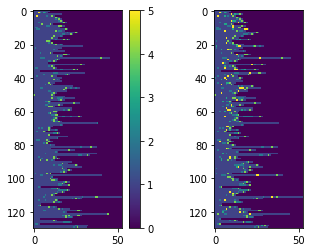

epoch:  176
0.000 perplexity: 1.084 speed: 322 wps
0.077 perplexity: 1.111 speed: 333 wps
0.154 perplexity: 1.118 speed: 334 wps
0.231 perplexity: 1.110 speed: 334 wps
0.308 perplexity: 1.111 speed: 334 wps
0.385 perplexity: 1.110 speed: 334 wps
0.462 perplexity: 1.108 speed: 334 wps
0.538 perplexity: 1.104 speed: 334 wps
0.615 perplexity: 1.100 speed: 335 wps
0.692 perplexity: 1.105 speed: 335 wps
0.769 perplexity: 1.103 speed: 335 wps
0.846 perplexity: 1.102 speed: 335 wps
0.923 perplexity: 1.101 speed: 335 wps


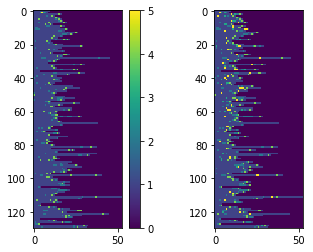

epoch:  177
0.000 perplexity: 1.102 speed: 328 wps
0.077 perplexity: 1.130 speed: 335 wps
0.154 perplexity: 1.136 speed: 335 wps
0.231 perplexity: 1.130 speed: 335 wps
0.308 perplexity: 1.127 speed: 335 wps
0.385 perplexity: 1.123 speed: 335 wps
0.462 perplexity: 1.121 speed: 335 wps
0.538 perplexity: 1.113 speed: 335 wps
0.615 perplexity: 1.107 speed: 335 wps
0.692 perplexity: 1.112 speed: 335 wps
0.769 perplexity: 1.107 speed: 335 wps
0.846 perplexity: 1.108 speed: 335 wps
0.923 perplexity: 1.108 speed: 335 wps


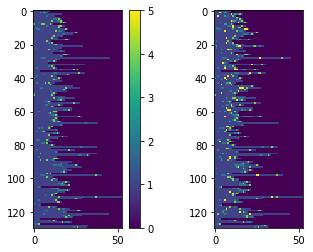

epoch:  178
0.000 perplexity: 1.076 speed: 330 wps
0.077 perplexity: 1.113 speed: 336 wps
0.154 perplexity: 1.121 speed: 336 wps
0.231 perplexity: 1.112 speed: 336 wps
0.308 perplexity: 1.114 speed: 337 wps
0.385 perplexity: 1.111 speed: 337 wps
0.462 perplexity: 1.121 speed: 337 wps
0.538 perplexity: 1.118 speed: 337 wps
0.615 perplexity: 1.112 speed: 337 wps
0.692 perplexity: 1.114 speed: 337 wps
0.769 perplexity: 1.119 speed: 337 wps
0.846 perplexity: 1.119 speed: 336 wps
0.923 perplexity: 1.118 speed: 336 wps


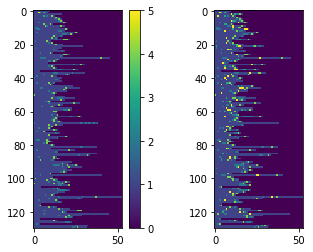

epoch:  179
0.000 perplexity: 1.068 speed: 327 wps
0.077 perplexity: 1.115 speed: 334 wps
0.154 perplexity: 1.125 speed: 336 wps
0.231 perplexity: 1.115 speed: 336 wps
0.308 perplexity: 1.112 speed: 336 wps
0.385 perplexity: 1.111 speed: 336 wps
0.462 perplexity: 1.114 speed: 336 wps
0.538 perplexity: 1.107 speed: 336 wps
0.615 perplexity: 1.103 speed: 337 wps
0.692 perplexity: 1.109 speed: 336 wps
0.769 perplexity: 1.106 speed: 336 wps
0.846 perplexity: 1.107 speed: 334 wps
0.923 perplexity: 1.106 speed: 332 wps


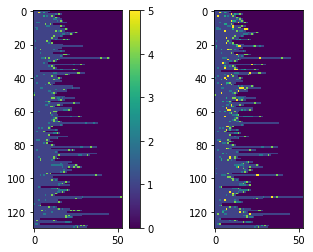

epoch:  180
0.000 perplexity: 1.090 speed: 326 wps
0.077 perplexity: 1.124 speed: 334 wps
0.154 perplexity: 1.134 speed: 335 wps
0.231 perplexity: 1.125 speed: 333 wps
0.308 perplexity: 1.120 speed: 333 wps
0.385 perplexity: 1.119 speed: 334 wps
0.462 perplexity: 1.118 speed: 333 wps
0.538 perplexity: 1.108 speed: 333 wps
0.615 perplexity: 1.103 speed: 334 wps
0.692 perplexity: 1.106 speed: 334 wps
0.769 perplexity: 1.105 speed: 334 wps
0.846 perplexity: 1.106 speed: 334 wps
0.923 perplexity: 1.103 speed: 334 wps


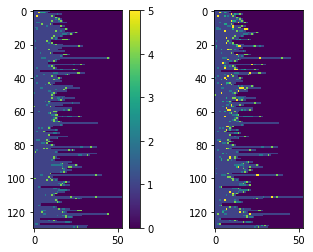

epoch:  181
0.000 perplexity: 1.145 speed: 325 wps
0.077 perplexity: 1.179 speed: 332 wps
0.154 perplexity: 1.181 speed: 334 wps
0.231 perplexity: 1.165 speed: 334 wps
0.308 perplexity: 1.153 speed: 334 wps
0.385 perplexity: 1.155 speed: 335 wps
0.462 perplexity: 1.153 speed: 335 wps
0.538 perplexity: 1.143 speed: 335 wps
0.615 perplexity: 1.137 speed: 335 wps
0.692 perplexity: 1.138 speed: 335 wps
0.769 perplexity: 1.134 speed: 335 wps
0.846 perplexity: 1.131 speed: 335 wps
0.923 perplexity: 1.127 speed: 335 wps


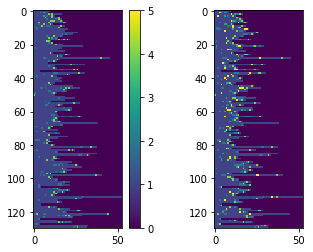

epoch:  182
0.000 perplexity: 1.116 speed: 326 wps
0.077 perplexity: 1.148 speed: 336 wps
0.154 perplexity: 1.156 speed: 336 wps
0.231 perplexity: 1.146 speed: 336 wps
0.308 perplexity: 1.144 speed: 336 wps
0.385 perplexity: 1.142 speed: 335 wps
0.462 perplexity: 1.138 speed: 321 wps
0.538 perplexity: 1.130 speed: 315 wps
0.615 perplexity: 1.123 speed: 306 wps
0.692 perplexity: 1.125 speed: 296 wps
0.769 perplexity: 1.123 speed: 284 wps
0.846 perplexity: 1.123 speed: 274 wps
0.923 perplexity: 1.121 speed: 266 wps


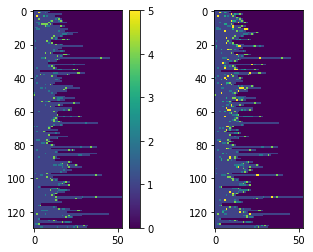

epoch:  183
0.000 perplexity: 1.176 speed: 218 wps
0.077 perplexity: 1.176 speed: 203 wps
0.154 perplexity: 1.178 speed: 204 wps
0.231 perplexity: 1.161 speed: 213 wps
0.308 perplexity: 1.154 speed: 218 wps
0.385 perplexity: 1.150 speed: 229 wps
0.462 perplexity: 1.148 speed: 232 wps
0.538 perplexity: 1.137 speed: 234 wps
0.615 perplexity: 1.128 speed: 231 wps
0.692 perplexity: 1.130 speed: 231 wps
0.769 perplexity: 1.129 speed: 235 wps
0.846 perplexity: 1.130 speed: 231 wps
0.923 perplexity: 1.128 speed: 233 wps


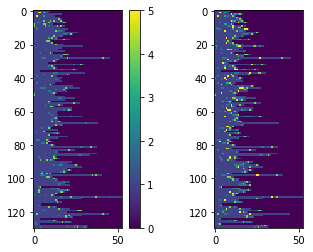

epoch:  184
0.000 perplexity: 1.121 speed: 258 wps
0.077 perplexity: 1.159 speed: 245 wps
0.154 perplexity: 1.152 speed: 232 wps
0.231 perplexity: 1.139 speed: 221 wps
0.308 perplexity: 1.136 speed: 221 wps
0.385 perplexity: 1.133 speed: 217 wps
0.462 perplexity: 1.132 speed: 224 wps
0.538 perplexity: 1.124 speed: 225 wps
0.615 perplexity: 1.119 speed: 223 wps
0.692 perplexity: 1.124 speed: 226 wps
0.769 perplexity: 1.121 speed: 232 wps
0.846 perplexity: 1.119 speed: 236 wps
0.923 perplexity: 1.116 speed: 240 wps


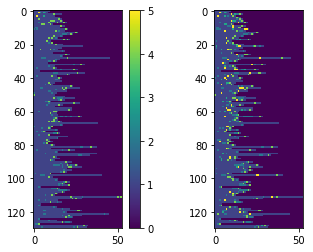

epoch:  185
0.000 perplexity: 1.126 speed: 308 wps
0.077 perplexity: 1.144 speed: 307 wps
0.154 perplexity: 1.149 speed: 299 wps
0.231 perplexity: 1.134 speed: 303 wps
0.308 perplexity: 1.134 speed: 303 wps
0.385 perplexity: 1.132 speed: 306 wps
0.462 perplexity: 1.128 speed: 305 wps
0.538 perplexity: 1.119 speed: 305 wps
0.615 perplexity: 1.114 speed: 287 wps
0.692 perplexity: 1.119 speed: 274 wps
0.769 perplexity: 1.117 speed: 272 wps
0.846 perplexity: 1.116 speed: 271 wps
0.923 perplexity: 1.115 speed: 273 wps


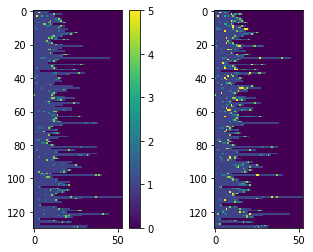

epoch:  186
0.000 perplexity: 1.066 speed: 292 wps
0.077 perplexity: 1.103 speed: 295 wps
0.154 perplexity: 1.124 speed: 295 wps
0.231 perplexity: 1.132 speed: 296 wps
0.308 perplexity: 1.142 speed: 292 wps
0.385 perplexity: 1.145 speed: 293 wps
0.462 perplexity: 1.148 speed: 292 wps
0.538 perplexity: 1.139 speed: 290 wps
0.615 perplexity: 1.132 speed: 290 wps
0.692 perplexity: 1.132 speed: 291 wps
0.769 perplexity: 1.127 speed: 292 wps
0.846 perplexity: 1.125 speed: 292 wps
0.923 perplexity: 1.123 speed: 292 wps


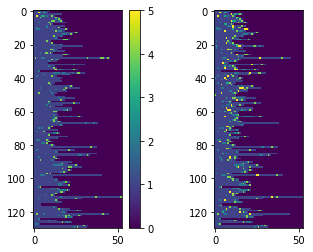

epoch:  187
0.000 perplexity: 1.081 speed: 291 wps
0.077 perplexity: 1.114 speed: 296 wps
0.154 perplexity: 1.127 speed: 297 wps
0.231 perplexity: 1.117 speed: 297 wps
0.308 perplexity: 1.119 speed: 298 wps
0.385 perplexity: 1.121 speed: 298 wps
0.462 perplexity: 1.124 speed: 298 wps
0.538 perplexity: 1.114 speed: 298 wps
0.615 perplexity: 1.112 speed: 298 wps
0.692 perplexity: 1.113 speed: 298 wps
0.769 perplexity: 1.110 speed: 298 wps
0.846 perplexity: 1.107 speed: 298 wps
0.923 perplexity: 1.106 speed: 298 wps


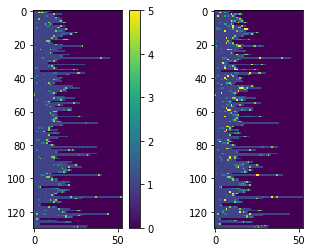

epoch:  188
0.000 perplexity: 1.077 speed: 291 wps
0.077 perplexity: 1.107 speed: 295 wps
0.154 perplexity: 1.115 speed: 296 wps
0.231 perplexity: 1.112 speed: 296 wps
0.308 perplexity: 1.116 speed: 297 wps
0.385 perplexity: 1.115 speed: 297 wps
0.462 perplexity: 1.119 speed: 297 wps
0.538 perplexity: 1.112 speed: 297 wps
0.615 perplexity: 1.107 speed: 297 wps
0.692 perplexity: 1.112 speed: 297 wps
0.769 perplexity: 1.108 speed: 297 wps
0.846 perplexity: 1.107 speed: 297 wps
0.923 perplexity: 1.107 speed: 297 wps


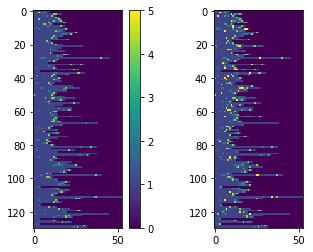

epoch:  189
0.000 perplexity: 1.070 speed: 285 wps
0.077 perplexity: 1.116 speed: 293 wps
0.154 perplexity: 1.125 speed: 295 wps
0.231 perplexity: 1.125 speed: 296 wps
0.308 perplexity: 1.123 speed: 296 wps
0.385 perplexity: 1.129 speed: 296 wps
0.462 perplexity: 1.154 speed: 296 wps
0.538 perplexity: 1.148 speed: 295 wps
0.615 perplexity: 1.141 speed: 291 wps
0.692 perplexity: 1.143 speed: 291 wps
0.769 perplexity: 1.137 speed: 291 wps
0.846 perplexity: 1.135 speed: 292 wps
0.923 perplexity: 1.131 speed: 292 wps


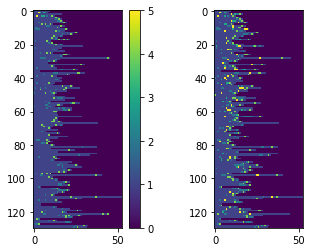

epoch:  190
0.000 perplexity: 1.095 speed: 289 wps
0.077 perplexity: 1.147 speed: 294 wps
0.154 perplexity: 1.152 speed: 295 wps
0.231 perplexity: 1.139 speed: 295 wps
0.308 perplexity: 1.132 speed: 295 wps
0.385 perplexity: 1.135 speed: 296 wps
0.462 perplexity: 1.138 speed: 296 wps
0.538 perplexity: 1.129 speed: 296 wps
0.615 perplexity: 1.122 speed: 296 wps
0.692 perplexity: 1.123 speed: 295 wps
0.769 perplexity: 1.121 speed: 296 wps
0.846 perplexity: 1.120 speed: 287 wps
0.923 perplexity: 1.121 speed: 280 wps


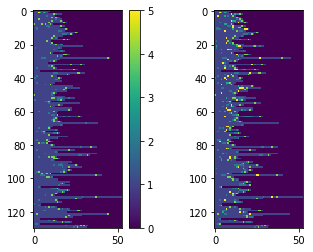

epoch:  191
0.000 perplexity: 1.100 speed: 248 wps
0.077 perplexity: 1.141 speed: 241 wps
0.154 perplexity: 1.142 speed: 259 wps
0.231 perplexity: 1.125 speed: 268 wps
0.308 perplexity: 1.125 speed: 273 wps
0.385 perplexity: 1.122 speed: 277 wps
0.462 perplexity: 1.119 speed: 280 wps
0.538 perplexity: 1.109 speed: 282 wps
0.615 perplexity: 1.104 speed: 283 wps
0.692 perplexity: 1.106 speed: 284 wps
0.769 perplexity: 1.105 speed: 286 wps
0.846 perplexity: 1.104 speed: 286 wps
0.923 perplexity: 1.104 speed: 287 wps


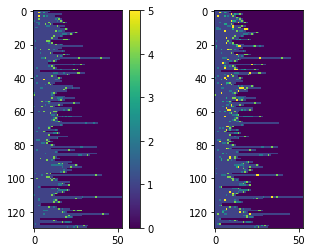

epoch:  192
0.000 perplexity: 1.084 speed: 289 wps
0.077 perplexity: 1.127 speed: 294 wps
0.154 perplexity: 1.142 speed: 295 wps
0.231 perplexity: 1.126 speed: 295 wps
0.308 perplexity: 1.125 speed: 295 wps
0.385 perplexity: 1.124 speed: 295 wps
0.462 perplexity: 1.121 speed: 295 wps
0.538 perplexity: 1.112 speed: 295 wps
0.615 perplexity: 1.108 speed: 295 wps
0.692 perplexity: 1.115 speed: 294 wps
0.769 perplexity: 1.112 speed: 295 wps
0.846 perplexity: 1.110 speed: 294 wps
0.923 perplexity: 1.108 speed: 294 wps


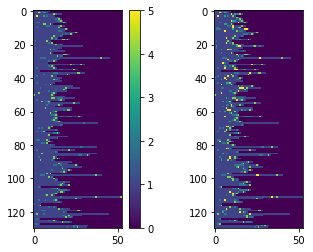

epoch:  193
0.000 perplexity: 1.069 speed: 289 wps
0.077 perplexity: 1.103 speed: 294 wps
0.154 perplexity: 1.123 speed: 296 wps
0.231 perplexity: 1.136 speed: 296 wps
0.308 perplexity: 1.134 speed: 296 wps
0.385 perplexity: 1.132 speed: 296 wps
0.462 perplexity: 1.129 speed: 296 wps
0.538 perplexity: 1.120 speed: 295 wps
0.615 perplexity: 1.116 speed: 295 wps
0.692 perplexity: 1.120 speed: 295 wps
0.769 perplexity: 1.115 speed: 295 wps
0.846 perplexity: 1.112 speed: 295 wps
0.923 perplexity: 1.109 speed: 295 wps


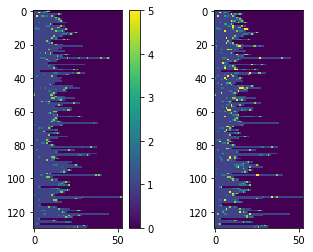

epoch:  194
0.000 perplexity: 1.108 speed: 290 wps
0.077 perplexity: 1.114 speed: 294 wps
0.154 perplexity: 1.118 speed: 295 wps
0.231 perplexity: 1.108 speed: 295 wps
0.308 perplexity: 1.110 speed: 295 wps
0.385 perplexity: 1.106 speed: 295 wps
0.462 perplexity: 1.108 speed: 295 wps
0.538 perplexity: 1.098 speed: 292 wps
0.615 perplexity: 1.095 speed: 290 wps
0.692 perplexity: 1.098 speed: 290 wps
0.769 perplexity: 1.095 speed: 290 wps
0.846 perplexity: 1.093 speed: 291 wps
0.923 perplexity: 1.092 speed: 291 wps


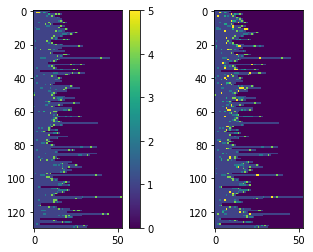

epoch:  195
0.000 perplexity: 1.116 speed: 287 wps
0.077 perplexity: 1.119 speed: 292 wps
0.154 perplexity: 1.130 speed: 293 wps
0.231 perplexity: 1.118 speed: 293 wps
0.308 perplexity: 1.119 speed: 294 wps
0.385 perplexity: 1.117 speed: 294 wps
0.462 perplexity: 1.114 speed: 294 wps
0.538 perplexity: 1.106 speed: 294 wps
0.615 perplexity: 1.101 speed: 294 wps
0.692 perplexity: 1.105 speed: 294 wps
0.769 perplexity: 1.101 speed: 295 wps
0.846 perplexity: 1.101 speed: 295 wps
0.923 perplexity: 1.104 speed: 295 wps


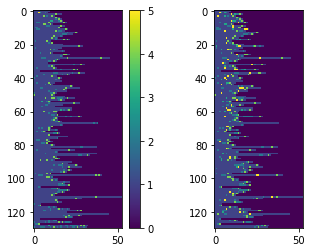

epoch:  196
0.000 perplexity: 1.147 speed: 281 wps
0.077 perplexity: 1.164 speed: 291 wps
0.154 perplexity: 1.149 speed: 291 wps
0.231 perplexity: 1.135 speed: 292 wps
0.308 perplexity: 1.135 speed: 293 wps
0.385 perplexity: 1.130 speed: 293 wps
0.462 perplexity: 1.130 speed: 293 wps
0.538 perplexity: 1.122 speed: 293 wps
0.615 perplexity: 1.114 speed: 293 wps
0.692 perplexity: 1.118 speed: 293 wps
0.769 perplexity: 1.114 speed: 293 wps
0.846 perplexity: 1.115 speed: 293 wps
0.923 perplexity: 1.113 speed: 293 wps


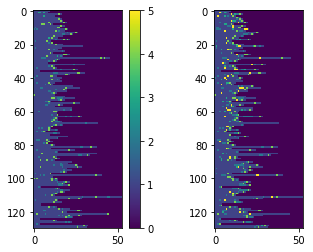

epoch:  197
0.000 perplexity: 1.078 speed: 286 wps
0.077 perplexity: 1.114 speed: 293 wps
0.154 perplexity: 1.122 speed: 293 wps
0.231 perplexity: 1.115 speed: 293 wps
0.308 perplexity: 1.117 speed: 294 wps
0.385 perplexity: 1.118 speed: 294 wps
0.462 perplexity: 1.124 speed: 294 wps
0.538 perplexity: 1.119 speed: 294 wps
0.615 perplexity: 1.114 speed: 294 wps
0.692 perplexity: 1.119 speed: 294 wps
0.769 perplexity: 1.116 speed: 294 wps
0.846 perplexity: 1.118 speed: 294 wps
0.923 perplexity: 1.117 speed: 294 wps


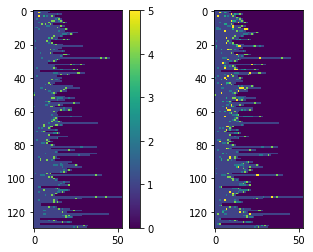

epoch:  198
0.000 perplexity: 1.080 speed: 290 wps
0.077 perplexity: 1.124 speed: 294 wps
0.154 perplexity: 1.136 speed: 295 wps
0.231 perplexity: 1.128 speed: 294 wps
0.308 perplexity: 1.127 speed: 294 wps
0.385 perplexity: 1.125 speed: 294 wps
0.462 perplexity: 1.124 speed: 294 wps
0.538 perplexity: 1.117 speed: 294 wps
0.615 perplexity: 1.111 speed: 294 wps
0.692 perplexity: 1.112 speed: 294 wps
0.769 perplexity: 1.107 speed: 294 wps
0.846 perplexity: 1.106 speed: 294 wps
0.923 perplexity: 1.104 speed: 294 wps


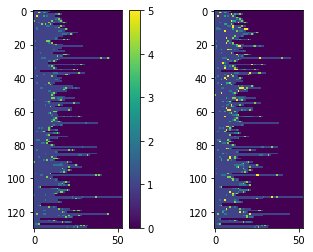

epoch:  199
0.000 perplexity: 1.100 speed: 285 wps
0.077 perplexity: 1.110 speed: 292 wps
0.154 perplexity: 1.124 speed: 293 wps
0.231 perplexity: 1.122 speed: 293 wps
0.308 perplexity: 1.121 speed: 293 wps
0.385 perplexity: 1.119 speed: 293 wps
0.462 perplexity: 1.119 speed: 294 wps
0.538 perplexity: 1.110 speed: 294 wps
0.615 perplexity: 1.105 speed: 288 wps
0.692 perplexity: 1.111 speed: 289 wps
0.769 perplexity: 1.110 speed: 289 wps
0.846 perplexity: 1.108 speed: 289 wps
0.923 perplexity: 1.106 speed: 290 wps


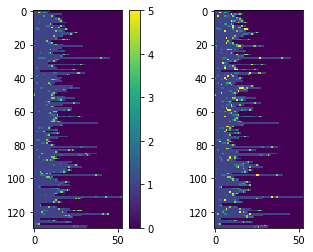

In [11]:
sv = tf.train.Supervisor(logdir="log")
with sv.managed_session() as sess:
    #for i in range(max_epoch):
    for i in range(200):
        print("epoch: %4d" % i)
        p = run_epoch(sess)
        p = np.vstack(p).reshape(-1, 53)
        f1 = plt.subplot(121)
        i1 = f1.imshow(p, vmin=0, vmax=5)
        plt.colorbar(i1)
        f2 = plt.subplot(122)
        f2.imshow(label[: 130], vmin=0, vmax=5)
        plt.show()

In [12]:
ppd = pd.DataFrame(p)

In [13]:
lpd = pd.DataFrame(label[:130])

In [21]:
m = (lpd != 0) 
m.sum().sum()

2461

In [22]:
((ppd == lpd) & m).sum().sum()

2246

In [15]:
m2 = (lpd > 1)

In [16]:
m2.sum().sum()

388

In [17]:
pos_p = lpd[((ppd == lpd) & m2)]

In [18]:
((ppd == lpd) & m2).sum().sum()

218

In [19]:
pos_l = lpd[m2]

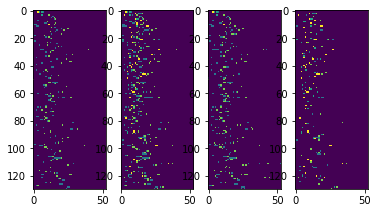

In [20]:
f1 = plt.subplot(141)
i1 = f1.imshow(pos_p.fillna(0).values, vmin=0, vmax=5)
f2 = plt.subplot(142)
f2.imshow(pos_l.fillna(0).values, vmin=0, vmax=5)
f3 = plt.subplot(143)
f3.imshow(ppd[ppd>1].fillna(0).values, vmin=0, vmax=5)
#plt.colorbar(i1)
f4 = plt.subplot(144)
f4.imshow(lpd[((ppd != lpd) & m2)].fillna(0).values, vmin=0, vmax=5)
plt.show()